# A Noter : 
## Nous avons utiliser la version 1.0.0 du package xgboost et nous avons installer le package shap via le channel conda-forge.
## Voici les commandes :
### pip install xgboost == 1.0.0
### conda install -c conda-forge shap

# Importation de la base de donnée

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.getcwd()
np.random.seed(1236)

In [3]:
df = pd.read_csv('high_diamond_ranked_10min.csv',sep = ',')
df

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,4527797466,1,54,0,0,6,4,8,1,1,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,4527713716,0,23,1,0,6,7,5,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


## Analyse des colonnes :
##### Il est intéressant d'observer dans un premier temps l'ensemble des fréquences de nos variables. Pour cela nous créons une fonction 'print_all_hist' qui permet d'afficher un histogramme pour chaque colonne d'un dataframe.

In [4]:
def print_all_hist(data_frame):
    
    list_col = data_frame.columns.values    
    nb_column = len(data_frame.columns.values)
    ax_column = 3
    ax_rows = round((nb_column/ax_column)+0.5)
    fig, axes = plt.subplots(ax_rows, ax_column, figsize=(20, 60))
    counter=0
    for i in range(ax_rows):
        for j in range(ax_column):
            
            ax = axes[i][j]
            
            if counter < nb_column:
                if list_col[counter][0:4] == 'blue':
                    ax.hist(data_frame[data_frame.columns[counter]], color='blue')
                else:
                    if list_col[counter][0:3] == 'red':
                        ax.hist(data_frame[data_frame.columns[counter]], color='red')
                    else:
                        ax.hist(data_frame[data_frame.columns[counter]], color='green')
                ax.set_xlabel(list_col[counter])

            else:
                ax.set_axis_off()
            
            counter=counter+1
    plt.show()

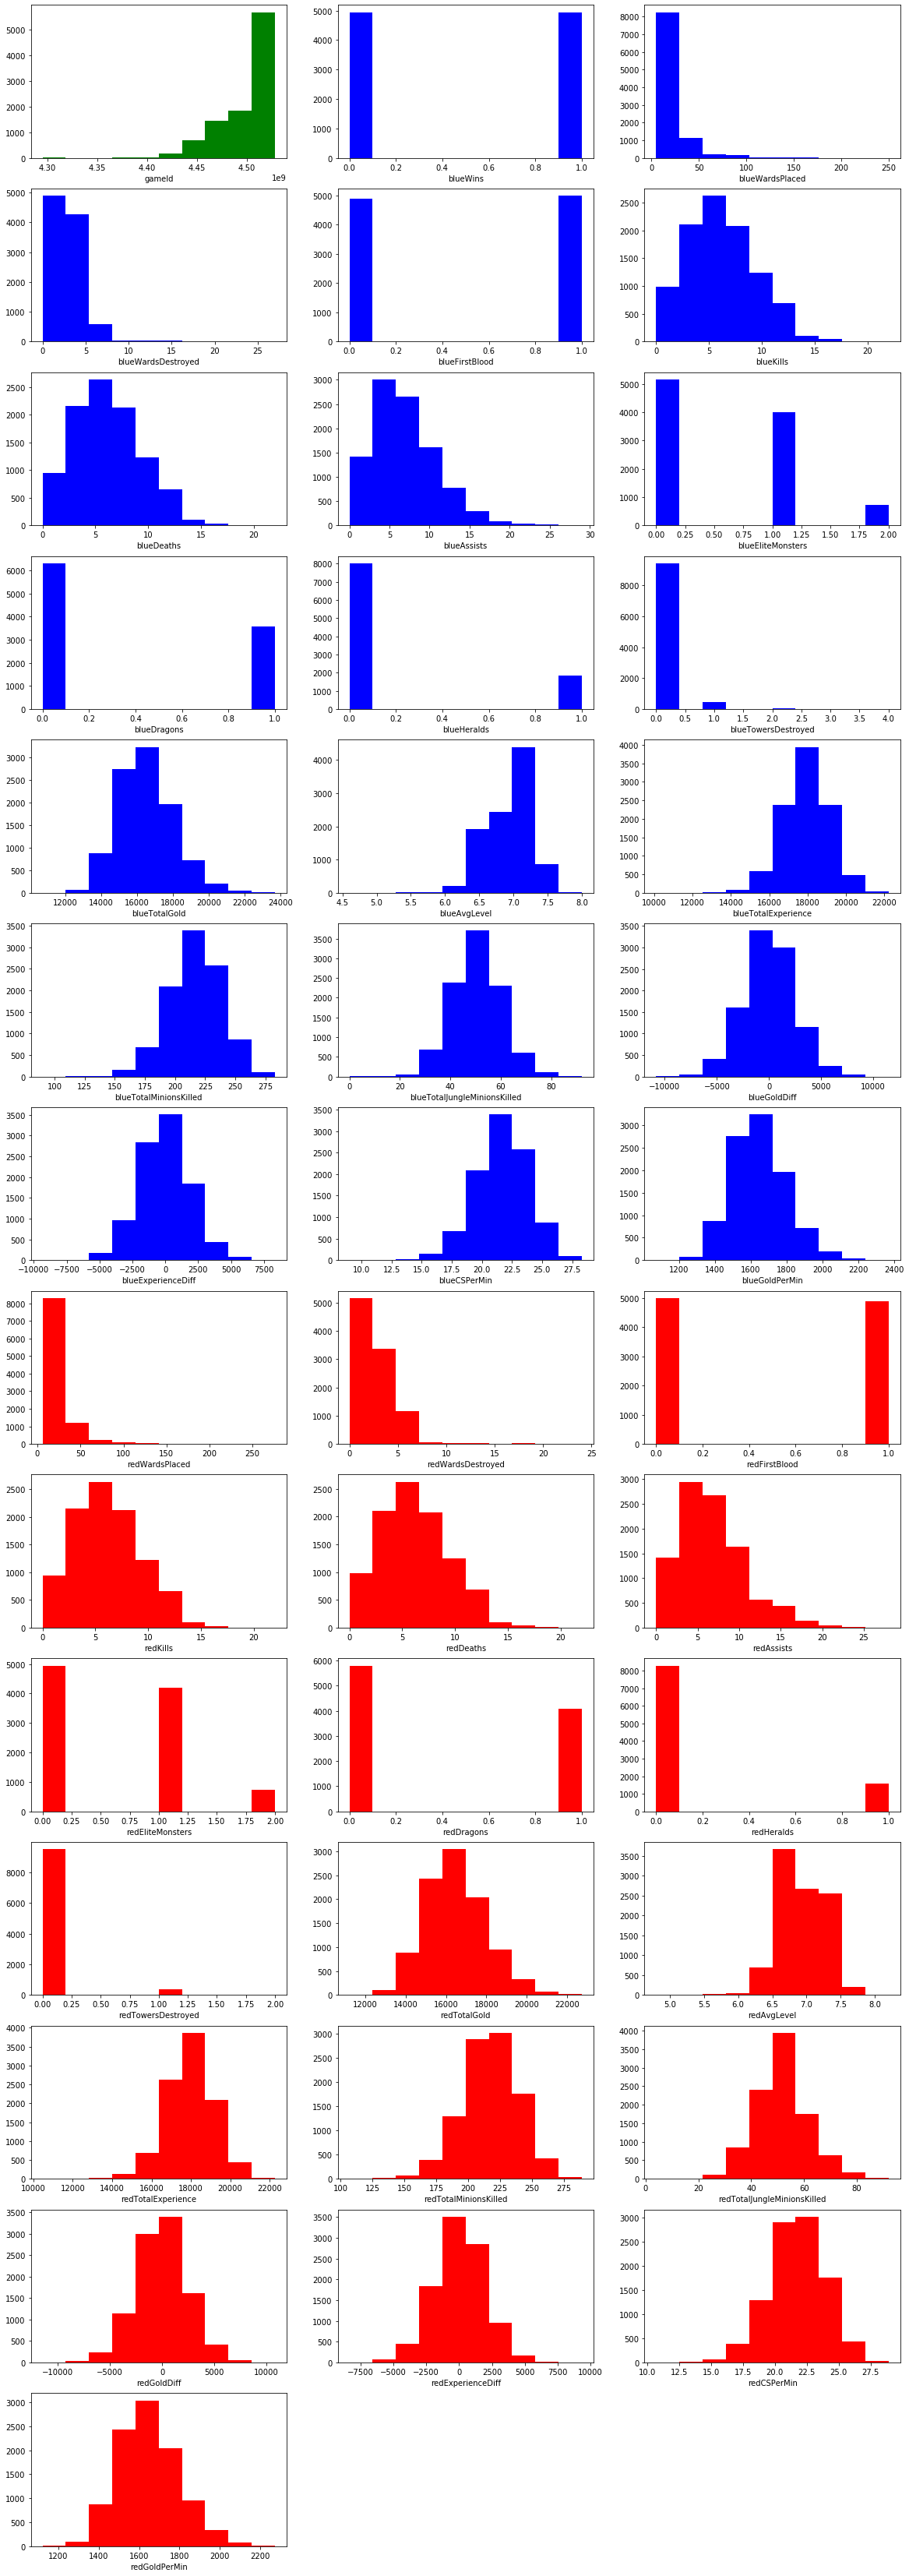

In [5]:
print_all_hist(df)

##### Nous avons en bleu les données relatives à l'équipe bleu, en rouge celles de l'équipe rouge. Enfin lorsqu'une variable n'appartient à aucune équipe celle-ci apparait en vert, c'est le cas de l'identifiant de la partie. 

## Création des indicateurs :
##### Dans une partie de jeu la victoire d'une équipe dépend égallement de la défaite de l'autre. Certaines variables sont donc redondantes car fortement corrélées entres elle. Pour cela nous créons des indicateurs plus pertinent en fusionnant ou retirant des variables.

In [6]:
df = df.rename(columns={'blueWins': 'Win'})
df = df.rename(columns={'blueGoldDiff': 'GoldDiff'})
df = df.rename(columns={'blueExperienceDiff': 'ExpDiff'})


def f(row, x):
    if x == 1:
        if row['blueDragons'] == 1:
            val = 1
        elif row['redDragons'] == 1:
            val = 2
        else:
            val = 0
    elif x ==2:
        if row['blueHeralds'] == 1:
            val = 1
        elif row['redHeralds'] == 1:
            val = 2
        else:
            val = 0
    elif x ==3:
        if row['blueFirstBlood'] == 1:
            val = 1
        else:
            val = 0
    return val

df['Dragon'] = df.apply(f, axis=1, x=1)
df['Herald'] = df.apply(f, axis=1, x=2)
df['FirstBlood'] = df.apply(f, axis=1, x=3)
max_vision = max(df['blueWardsPlaced'].max(axis = 0), df['redWardsPlaced'].max(axis = 0))
df['VisionAdvantage'] = (df['blueWardsPlaced']-df['redWardsPlaced'])/max_vision
max_counter_vision = max(df['blueWardsDestroyed'].max(axis = 0), df['redWardsDestroyed'].max(axis = 0))
df['CounterVisionAdvantage'] = (df['blueWardsDestroyed']-df['redWardsDestroyed'])/max_vision
df['TotalGold'] = df['redTotalGold'] + df['blueTotalGold']
df['TotalExp'] = df['blueTotalExperience'] + df['redTotalExperience']
df['MinionsDiff'] = df['blueTotalMinionsKilled']-df['redTotalMinionsKilled']
df['JungleMinionsDiff'] = df['blueTotalJungleMinionsKilled']-df['redTotalJungleMinionsKilled']

df = df.drop(['blueDragons'], axis=1)
df = df.drop(['redDragons'], axis=1)
df = df.drop(['blueHeralds'], axis=1)
df = df.drop(['redHeralds'], axis=1)
df = df.drop(['blueFirstBlood'], axis=1)
df = df.drop(['redFirstBlood'], axis=1)
df = df.drop(['blueWardsPlaced'], axis=1)
df = df.drop(['redWardsPlaced'], axis=1)
df = df.drop(['blueWardsDestroyed'], axis=1)
df = df.drop(['redWardsDestroyed'], axis=1)
df = df.drop(['redGoldDiff'], axis=1)
df = df.drop(['redExperienceDiff'], axis=1)
df = df.drop(['blueTotalMinionsKilled'], axis=1)
df = df.drop(['redTotalMinionsKilled'], axis=1)
df = df.drop(['blueTotalJungleMinionsKilled'], axis=1)
df = df.drop(['redTotalJungleMinionsKilled'], axis=1)
df = df.drop(['blueGoldPerMin'], axis=1)
df = df.drop(['redGoldPerMin'], axis=1)
df = df.drop(['blueCSPerMin'], axis=1)
df = df.drop(['redCSPerMin'], axis=1)
df = df.drop(['blueTotalExperience'], axis=1)
df = df.drop(['redTotalExperience'], axis=1)
df = df.drop(['redTotalGold'], axis=1)
df = df.drop(['blueTotalGold'], axis=1)
df = df.drop(['redKills'], axis=1)
df = df.drop(['redDeaths'], axis=1)

In [7]:
df = df[['gameId', 'Win', 'GoldDiff', 'ExpDiff', 'TotalGold', 'TotalExp', 'FirstBlood', 'VisionAdvantage', 'CounterVisionAdvantage', 'Dragon', 
         'Herald', 'MinionsDiff', 'JungleMinionsDiff', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 
         'blueTowersDestroyed', 'blueAvgLevel', 'redAssists', 'redEliteMonsters', 'redTowersDestroyed', 'redAvgLevel']]

df

,gameId,Win,GoldDiff,ExpDiff,TotalGold,TotalExp,FirstBlood,VisionAdvantage,CounterVisionAdvantage,Dragon,...,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueTowersDestroyed,blueAvgLevel,redAssists,redEliteMonsters,redTowersDestroyed,redAvgLevel
0,4519157822,0,643,-8,33777,34086,1,0.047101,-0.014493,0,...,9,6,11,0,0,6.6,8,0,0,6.8
1,4523371949,0,-2908,-1173,32332,33703,0,0.000000,0.000000,2,...,5,5,5,0,0,6.6,2,2,1,6.8
2,4521474530,0,-1172,-1033,33398,33475,0,0.000000,-0.010870,1,...,7,11,4,1,0,6.4,14,0,0,6.8
3,4524384067,0,-1321,-7,31635,35915,0,0.101449,-0.003623,0,...,4,5,5,1,0,7.0,10,0,0,7.0
4,4436033771,0,-1004,230,33804,36856,0,0.210145,0.007246,2,...,6,6,6,0,0,7.0,7,1,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,2519,2469,33011,35465,1,-0.105072,-0.003623,1,...,7,4,5,1,0,7.2,7,0,0,6.8
9875,4527797466,1,782,888,31694,37622,0,0.152174,-0.076087,1,...,6,4,8,1,0,7.2,3,0,0,7.0
9876,4527713716,0,-2416,-1877,34222,37941,0,0.032609,0.003623,2,...,6,7,5,0,0,7.0,11,1,0,7.4
9877,4527628313,0,-839,-1085,29757,35543,1,-0.188406,0.000000,1,...,2,3,3,1,0,6.6,1,0,0,7.2


##### On obtient ainsi un dataframe avec 23 colonnes dont 21 indicateurs, notre variable à prédire étant "Win"

# Séparation en train/test

In [8]:
x = df.drop(['Win', 'gameId'], axis=1)
y = df[['Win']]

In [9]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 5, test_size = 0.25)

# Apprentissage des modèles

## Modèle à battre

In [10]:
base_x = test_x.copy()

In [11]:
base_x['y'] = np.where(base_x['GoldDiff']>=0, 1, 0)

In [12]:
base_pred = base_x['y']

In [13]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(test_y, base_pred))

0.2720647773279352


##### Nous savons d'expérience que la victoire d'une équipe dépend de la somme totale de ses "Gold". La variable la plus importante est donc "GoldDiff" qui représente l'écart de "Gold" entre les 2 équipes.
##### Nous faisons donc un modèle très simpliste qui consiste à dire que l'équipe qui va gagner la partie est celle ayant l'avantage à 10min de jeu.
##### L'enjeu sera donc de voir s'il est possible grâce au machine learning de dépasser ce score.

## Application de modèles non "paramètrer" :

##### Nous allons appliquer des modèles sans en modifier les paramètres pour observer les premiers résultats de ceux-ci.

### Logistic Regression :

In [14]:
from sklearn.decomposition import PCA
acp = PCA(3)
acp.fit(train_x, train_y)

PCA(n_components=3)

##### On réduit le nombre de variable à 3 car nous savons que celles-ci sont très corrélées entre-elles.

In [15]:
train_x_acp = acp.transform(train_x)
train_x_acp.shape

(7409, 3)

In [16]:
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(solver='lbfgs')
model_logreg.fit(train_x_acp, train_y.values.ravel())

LogisticRegression()

In [17]:
model_logreg.coef_

array([[-4.81458558e-04,  9.57236496e-06, -3.04538385e-05]])

In [18]:
from sklearn.metrics import mean_absolute_error

test_x_acp = acp.transform(test_x)
pred_LR = model_logreg.predict(test_x_acp)
print(mean_absolute_error(test_y, pred_LR))

0.2676113360323887


##### Nous obtenons une erreur moyenne absolue plus faible pour le modèle à battre ce qui signifie que d'autres variables influences la victoire plus que la différence d'or entre les deux équipes.

### Arbre de Regression :

In [19]:
from sklearn import tree

model_DT = tree.DecisionTreeClassifier()
model_DT.fit(train_x, train_y.values.ravel())

DecisionTreeClassifier()

In [20]:
from sklearn.metrics import mean_absolute_error

pred_DT = model_DT.predict(test_x)
print(mean_absolute_error(test_y, pred_DT))

0.35101214574898787


##### Nous obtenons une MAE plus grande que pour le modèle à battre. C'est intéressant car le modèle à battre est en réalité un simple arbre avec un seul noeud. Cela signifie que les autres variables ajoutent du bruits ne permettant pas à notre arbre d'avoir de bon résultats.

### RandomForest :

In [21]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier()
model_RF.fit(train_x, train_y.values.ravel())

RandomForestClassifier()

In [22]:
from sklearn.metrics import mean_absolute_error

pred_RF = model_RF.predict(test_x)
print(mean_absolute_error(test_y, pred_RF))

0.2651821862348178


##### La MAE est proche de la régression logistique. C'est bon signe car nous pouvons alors ésperer avoir de meilleurs résultats en modifiant les paramètres de l'algorithme. Le fait d'avoir plusieurs abres à supprimer le bruit induit par la présence de variables supplémentaire.

### XGBoost :

In [23]:
from xgboost import XGBClassifier

model_XGBoost = XGBClassifier()
model_XGBoost.fit(train_x, train_y.values.ravel())

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [24]:
from sklearn.metrics import mean_absolute_error

pred_XGBoost = model_XGBoost.predict(test_x)
print(mean_absolute_error(test_y, pred_XGBoost))

0.2890688259109312


##### Nous obtenons une erreur plus forte que pour le RandomForest et la régression logistique. Le modèle XGBoost étant une version plus poussée que le RandomForest. En effet celui-ci accorde un poids plus fort aux observations pour lesquels celui-ci s'est trompé pour la création de l'abre suivant. 
##### Cette augmentation ne peux être résultat que d'un sur-apprentissage de notre modèle.

## Mesure de la performance

##### On souhaite maintenant comparer nos modèles sur plusieurs métriques afin d'assurer notre classement précédent. 

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score    

##### Nous créons une fonction "compar_model" qui va calculer les 3 métriques "accuracy_score", "f1_score", "roc_auc_score" pour modèles en entrée.

In [26]:
def compar_model(list_name_model,
                 list_pred,
                 name_test_y):
    metrics_df = pd.DataFrame(columns=['Metrics', 'Model', 'Values'])
    metrics_df.style.hide_index()
    nb_model = 0
    nb_ligne = 0
    for mod in list_name_model:
        name_pred = list_pred[nb_model]
        score = accuracy_score(name_test_y, name_pred)
        metrics_df.loc[nb_ligne] = ['accuracy', mod ,score]
        nb_ligne = nb_ligne + 1
        score = f1_score(name_test_y, name_pred)
        metrics_df.loc[nb_ligne] = ['f1_score', mod ,score]
        nb_ligne = nb_ligne + 1
        score = roc_auc_score(name_test_y, name_pred)
        metrics_df.loc[nb_ligne] = ['auc', mod ,score]
        nb_ligne = nb_ligne + 1
        nb_model = nb_model + 1        
    return metrics_df

In [27]:
df_compar = compar_model(list_name_model = ['Base', 'model_LR', 'model_DT', 'model_RF', 'model_XGBoost'],
                    list_pred = [base_pred, pred_LR, pred_DT, pred_RF, pred_XGBoost],
                    name_test_y = test_y)

df_label = pd.DataFrame(df_compar['Metrics'], columns=['Metrics'])

##### On calcule nos métriques pour nos 5 modèles, puis nous créons un dataframe contenant uniquement la colonne "Métrics" de notre dataframe en sortie de la fonction car il est nécessaire pour l'affichage graphique que nous allons faire.

In [28]:
df_compar

,Metrics,Model,Values
0,accuracy,Base,0.727935
1,f1_score,Base,0.725266
2,auc,Base,0.728355
3,accuracy,model_LR,0.732389
4,f1_score,model_LR,0.730314
5,auc,model_LR,0.732877
6,accuracy,model_DT,0.648988
7,f1_score,model_DT,0.644818
8,auc,model_DT,0.649265
9,accuracy,model_RF,0.734818


[Text(0, 0, 'accuracy'), Text(0, 0, 'f1_score'), Text(0, 0, 'auc')]

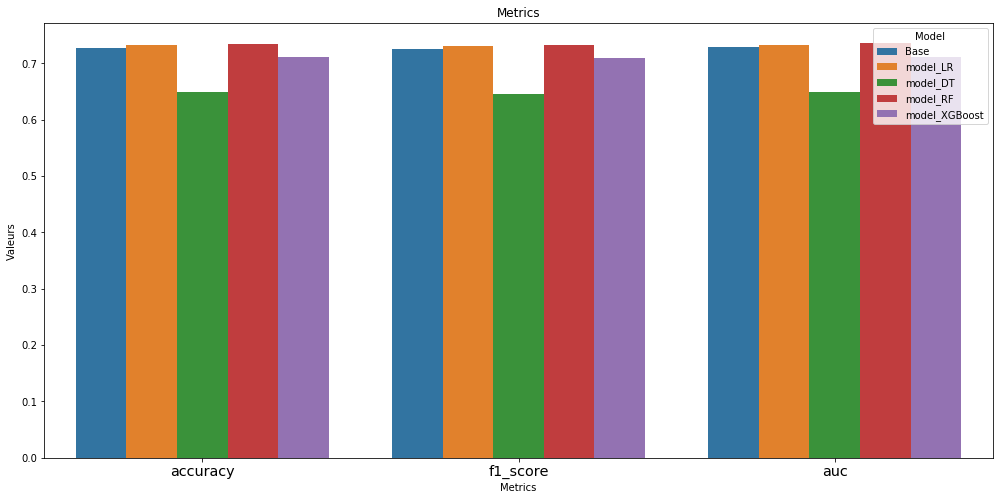

In [29]:
import seaborn as sns

plt.figure(figsize=(17,8))
plt.title("Metrics")
hist = sns.barplot(x=df_label['Metrics'], y=df_compar['Values'], hue=df_compar['Model'])
plt.ylabel("Valeurs")
plt.xlabel("Metrics")

hist.set_xticklabels(hist.get_xticklabels(), fontsize='x-large')

##### On remarque que pour nos 3 métriques la régression logistique et le RandomForest sont meilleurs que notre modèle à battre. Les conclusions précédentes pour les modèles "XGBoost" et "Arbre" reste confirmés ici.

## Matrices de confusions :

#### Pour le modèle à battre :

In [30]:
print("Matrice de confusion : \n",confusion_matrix(test_y, base_pred))

Matrice de confusion : 
 [[911 363]
 [309 887]]


#### Pour la regression logistique :

In [31]:
print("Matrice de confusion : \n",confusion_matrix(test_y, pred_LR))

Matrice de confusion : 
 [[914 360]
 [301 895]]


#### Pour l'arbre de décision :

In [32]:
print("Matrice de confusion : \n",confusion_matrix(test_y, pred_DT))

Matrice de confusion : 
 [[816 458]
 [409 787]]


#### Pour la random forest :

In [33]:
print("Matrice de confusion : \n",confusion_matrix(test_y, pred_RF))

Matrice de confusion : 
 [[920 354]
 [301 895]]


#### Pour le XGBoost :

In [34]:
print("Matrice de confusion : \n",confusion_matrix(test_y, pred_XGBoost))

Matrice de confusion : 
 [[887 387]
 [327 869]]


# Tuning des hyperparamètres :

##### Nous allons maintenant modifier les paramètres en entrer de nos deux modeles : le RandomForest et le XGBoost.
##### Ces modèles étant des modèles non paramétriques, aucune hypothèse n'est nécessaire à l'applicaiton de ceux-ci sur nos données pour avoir un bon résultat. Néanmoins il est possible de les amliorer vis-à-vie de nos données en adaptant les paramètres de ceux-ci.

## Modèle RandomForest :

In [35]:
model_RF.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier()>

In [36]:
from sklearn.model_selection import GridSearchCV

param_test_RF = {'min_samples_split':range(2, 6),
                 'max_depth' : range(1, 6),
                 'min_samples_leaf' : range(1, 10)
}

gsearch_RF = GridSearchCV(estimator = RandomForestClassifier(), 
param_grid = param_test_RF, scoring='accuracy', cv=4)
gsearch_RF.fit(train_x, train_y.values.ravel())

gsearch_RF.best_score_, gsearch_RF.best_params_

(0.7312729255809562,
 {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 3})

##### Le GridSearch va créer tous les modèles possible pour nos valeurs de paramètres définis dans le dictionnaire "param_test_RF". A la fin des executions l'algorithme gardera le meilleur modèle sur nos valeurs "test" selon la métrique définie par la variable "scoring".
##### Pour le RandomForest nos paramètres optimaux sont donc 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2. Un RandomForest avec ces paramètres nous donnera une accuracy de 73%.

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_nb_estimators_RF(model,
                         name_gsearch,
                         nb_estim_values,
                         f_test_x,
                         f_test_y,
                         f_train_x,
                         f_train_y):
    
    resultats = {}    
    test_auc = []
    train_auc = []
    test_f1 = []
    train_f1 = []
    test_accuracy = []
    train_accuracy = []
    for i in nb_estim_values:
        test = {}
        train= {}
        mod = model(min_samples_split = gsearch_RF.best_params_['min_samples_split'],
                    max_depth = gsearch_RF.best_params_['max_depth'],
                    min_samples_leaf = gsearch_RF.best_params_['min_samples_leaf'],
                    n_estimators = i)    
        mod.fit(f_train_x, f_train_y.values.ravel())
        pred_mod_test = mod.predict(f_test_x)
        pred_mod_train = mod.predict(f_train_x)
        
        test_auc.append(roc_auc_score(f_test_y, pred_mod_test))
        train_auc.append(roc_auc_score(f_train_y, pred_mod_train))
        
        test_f1.append(f1_score(f_test_y, pred_mod_test))
        train_f1.append(f1_score(f_train_y, pred_mod_train))
        
        test_accuracy.append(accuracy_score(f_test_y, pred_mod_test))
        train_accuracy.append(accuracy_score(f_train_y, pred_mod_train))
        
    test['auc'] = test_auc
    train['auc'] = train_auc
    test['f1'] = test_f1
    train['f1'] = train_f1
    test['accuracy'] = test_accuracy
    train['accuracy'] = train_accuracy
        
    resultats['test'] = test
    resultats['train'] = train
        
    return resultats

##### Le dernier paramètre dont nous souhaitions chercher la valeur optimale est le paramètre "n_estimators" qui correspond au nombre d'arbre que le modèle utilisera pour prédire notre variable. 
##### Nous souhaitions faire une optimisation manuelle et plus graphique. Pour cela nous avons créer une fonction qui va garder nos paramètres optimaux issues du GridSearch et boucler sur plusieurs valeurs possibles de "n_estimators". Pour chaque itérations nous calculons les valeurs des métriques "auc", "accuracy" et f1-score" sur nos données de train et de test. Nous stockons l'ensemble des résultats dans un dictionnaire.

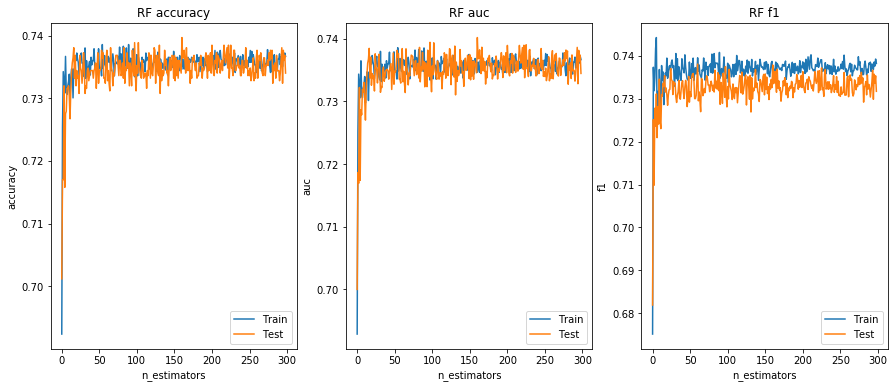

In [38]:
nb_estim = get_nb_estimators_RF(RandomForestClassifier,
                                gsearch_RF,
                                range(1, 300),
                                test_x,
                                test_y,
                                train_x,
                                train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(0, nb_iterations)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('RF accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('RF auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('RF f1')
plt.show()

##### On se sert des résultats de notre fonction pour sélectionner la valeur du paramètre "n_estimators" qui permet au modèle de ne pas sur-apprendre selon nos métriques. Ici on remarque que le modèle sur-apprend très rapidement. On décide de refaire la même procédure mais avec une range plus petite pour pouvoir mieux cibler.

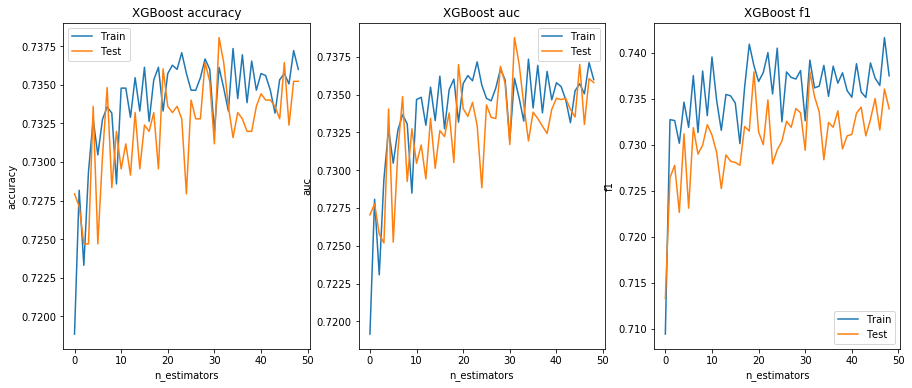

In [39]:
nb_estim = get_nb_estimators_RF(RandomForestClassifier,
                                gsearch_RF,
                                range(1, 50),
                                test_x,
                                test_y,
                                train_x,
                                train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(0, nb_iterations)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('XGBoost accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('XGBoost auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('XGBoost f1')
plt.show()

In [40]:
model_RF_tun = RandomForestClassifier(min_samples_split = gsearch_RF.best_params_['min_samples_split'],
                             max_depth = gsearch_RF.best_params_['max_depth'],
                             min_samples_leaf = gsearch_RF.best_params_['min_samples_leaf'],
                             n_estimators = 10)

model_RF_tun.fit(train_x, train_y.values.ravel())

RandomForestClassifier(max_depth=4, min_samples_leaf=8, min_samples_split=3,
                       n_estimators=10)

##### Ici on remarque que notre modèle sur-apprend dès le premier arbre. Les métriques pour nos données de test semblent avoir convergés vers une valeur optimale au bout de 10 arbres.
##### Nous retenons donc un "n_estimators" égal à 10 pour notre modèle.

## Tuning des hyperparamètres pour le modèle XGBoost

Nous allons appliquer une méthode assez similaire pour notre modèle XGBoost.

In [41]:
model_XGBoost.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)>

In [42]:
from sklearn.model_selection import GridSearchCV

eval_set = [(train_x, train_y), (test_x, test_y)]

param_test = {'colsample_bytree':[0.4, 0.6, 0.8],
              'max_depth' : [2, 4, 6, 8, 10, 12],
              'subsample' : [0.4, 0.6, 0.8]
}

gsearch_XG = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.05,
                                                    n_estimators = 500), 
 param_grid = param_test, scoring='accuracy', cv=4)
gsearch_XG.fit(train_x,
               train_y.values.ravel(),
               eval_metric='auc',
               eval_set=eval_set,
               early_stopping_rounds=10)

[0]	validation_0-auc:0.70541	validation_1-auc:0.71034
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.75555	validation_1-auc:0.76840
[2]	validation_0-auc:0.75310	validation_1-auc:0.76459
[3]	validation_0-auc:0.75839	validation_1-auc:0.77088
[4]	validation_0-auc:0.78075	validation_1-auc:0.78958
[5]	validation_0-auc:0.79020	validation_1-auc:0.79766
[6]	validation_0-auc:0.79448	validation_1-auc:0.80215
[7]	validation_0-auc:0.79685	validation_1-auc:0.80347
[8]	validation_0-auc:0.79847	validation_1-auc:0.80203


C:\Users\Proprietaire\.conda\envs\test\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[9]	validation_0-auc:0.79841	validation_1-auc:0.80020
[10]	validation_0-auc:0.79765	validation_1-auc:0.79963
[11]	validation_0-auc:0.79915	validation_1-auc:0.80089
[12]	validation_0-auc:0.80004	validation_1-auc:0.80229
[13]	validation_0-auc:0.80089	validation_1-auc:0.80399
[14]	validation_0-auc:0.80158	validation_1-auc:0.80464
[15]	validation_0-auc:0.80206	validation_1-auc:0.80539
[16]	validation_0-auc:0.80300	validation_1-auc:0.80658
[17]	validation_0-auc:0.80334	validation_1-auc:0.80688
[18]	validation_0-auc:0.80425	validation_1-auc:0.80668
[19]	validation_0-auc:0.80469	validation_1-auc:0.80767
[20]	validation_0-auc:0.80498	validation_1-auc:0.80807
[21]	validation_0-auc:0.80544	validation_1-auc:0.80838
[22]	validation_0-auc:0.80565	validation_1-auc:0.80864
[23]	validation_0-auc:0.80583	validation_1-auc:0.80928
[24]	validation_0-auc:0.80575	validation_1-auc:0.80899
[25]	validation_0-auc:0.80577	validation_1-auc:0.80915
[26]	validation_0-auc:0.80584	validation_1-auc:0.80936
[27]	valida

[33]	validation_0-auc:0.80802	validation_1-auc:0.81037
[34]	validation_0-auc:0.80824	validation_1-auc:0.81043
Stopping. Best iteration:
[24]	validation_0-auc:0.80640	validation_1-auc:0.81103

[0]	validation_0-auc:0.69242	validation_1-auc:0.69877
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78117	validation_1-auc:0.78225
[2]	validation_0-auc:0.79033	validation_1-auc:0.79329
[3]	validation_0-auc:0.79193	validation_1-auc:0.79651
[4]	validation_0-auc:0.79657	validation_1-auc:0.80072
[5]	validation_0-auc:0.80105	validation_1-auc:0.80494
[6]	validation_0-auc:0.80012	validation_1-auc:0.80450
[7]	validation_0-auc:0.80362	validation_1-auc:0.80562
[8]	validation_0-auc:0.80509	validation_1-auc:0.80658
[9]	validation_0-auc:0.80478	validation_1-auc:0.80741
[10]	validation_0-auc:0.80491	validation_1-auc:0.80811
[11]	validation_0-auc:0.80535	validation_1-auc:0.80857
[

[41]	validation_0-auc:0.80909	validation_1-auc:0.81002
[42]	validation_0-auc:0.80923	validation_1-auc:0.81028
[43]	validation_0-auc:0.80948	validation_1-auc:0.81045
[44]	validation_0-auc:0.80975	validation_1-auc:0.81037
Stopping. Best iteration:
[34]	validation_0-auc:0.80807	validation_1-auc:0.81065

[0]	validation_0-auc:0.71136	validation_1-auc:0.71693
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78011	validation_1-auc:0.78663
[2]	validation_0-auc:0.78938	validation_1-auc:0.79397
[3]	validation_0-auc:0.78991	validation_1-auc:0.79482
[4]	validation_0-auc:0.79609	validation_1-auc:0.79874
[5]	validation_0-auc:0.79995	validation_1-auc:0.80279
[6]	validation_0-auc:0.79990	validation_1-auc:0.80259
[7]	validation_0-auc:0.80042	validation_1-auc:0.80388
[8]	validation_0-auc:0.80190	validation_1-auc:0.80535
[9]	validation_0-auc:0.80249	validation_1-auc:0.80694
[

[11]	validation_0-auc:0.80105	validation_1-auc:0.80751
[12]	validation_0-auc:0.80158	validation_1-auc:0.80772
[13]	validation_0-auc:0.80117	validation_1-auc:0.80739
[14]	validation_0-auc:0.80127	validation_1-auc:0.80741
[15]	validation_0-auc:0.80120	validation_1-auc:0.80756
[16]	validation_0-auc:0.80118	validation_1-auc:0.80713
[17]	validation_0-auc:0.80097	validation_1-auc:0.80693
[18]	validation_0-auc:0.80180	validation_1-auc:0.80774
Stopping. Best iteration:
[8]	validation_0-auc:0.80167	validation_1-auc:0.80820

[0]	validation_0-auc:0.71486	validation_1-auc:0.71807
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78623	validation_1-auc:0.79147
[2]	validation_0-auc:0.79230	validation_1-auc:0.79789
[3]	validation_0-auc:0.79223	validation_1-auc:0.79831
[4]	validation_0-auc:0.79792	validation_1-auc:0.80161
[5]	validation_0-auc:0.80088	validation_1-auc:0.8044

[18]	validation_0-auc:0.81397	validation_1-auc:0.80839
[19]	validation_0-auc:0.81415	validation_1-auc:0.80836
[20]	validation_0-auc:0.81487	validation_1-auc:0.80881
[21]	validation_0-auc:0.81538	validation_1-auc:0.80932
[22]	validation_0-auc:0.81568	validation_1-auc:0.80994
[23]	validation_0-auc:0.81610	validation_1-auc:0.81027
[24]	validation_0-auc:0.81669	validation_1-auc:0.81033
[25]	validation_0-auc:0.81701	validation_1-auc:0.80990
[26]	validation_0-auc:0.81720	validation_1-auc:0.80990
[27]	validation_0-auc:0.81736	validation_1-auc:0.80965
[28]	validation_0-auc:0.81776	validation_1-auc:0.80904
[29]	validation_0-auc:0.81783	validation_1-auc:0.80900
[30]	validation_0-auc:0.81819	validation_1-auc:0.80876
[31]	validation_0-auc:0.81825	validation_1-auc:0.80880
[32]	validation_0-auc:0.81832	validation_1-auc:0.80845
[33]	validation_0-auc:0.81842	validation_1-auc:0.80853
[34]	validation_0-auc:0.81869	validation_1-auc:0.80869
Stopping. Best iteration:
[24]	validation_0-auc:0.81669	validatio

[7]	validation_0-auc:0.81351	validation_1-auc:0.80795
[8]	validation_0-auc:0.81523	validation_1-auc:0.80932
[9]	validation_0-auc:0.81588	validation_1-auc:0.81084
[10]	validation_0-auc:0.81659	validation_1-auc:0.81048
[11]	validation_0-auc:0.81622	validation_1-auc:0.80978
[12]	validation_0-auc:0.81615	validation_1-auc:0.80975
[13]	validation_0-auc:0.81642	validation_1-auc:0.80962
[14]	validation_0-auc:0.81627	validation_1-auc:0.80974
[15]	validation_0-auc:0.81621	validation_1-auc:0.80926
[16]	validation_0-auc:0.81624	validation_1-auc:0.80906
[17]	validation_0-auc:0.81628	validation_1-auc:0.80836
[18]	validation_0-auc:0.81700	validation_1-auc:0.80884
[19]	validation_0-auc:0.81764	validation_1-auc:0.80904
Stopping. Best iteration:
[9]	validation_0-auc:0.81588	validation_1-auc:0.81084

[0]	validation_0-auc:0.75167	validation_1-auc:0.74791
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 roun

[7]	validation_0-auc:0.82491	validation_1-auc:0.80453
[8]	validation_0-auc:0.82461	validation_1-auc:0.80404
[9]	validation_0-auc:0.82525	validation_1-auc:0.80395
[10]	validation_0-auc:0.82626	validation_1-auc:0.80381
[11]	validation_0-auc:0.82743	validation_1-auc:0.80426
[12]	validation_0-auc:0.82884	validation_1-auc:0.80445
[13]	validation_0-auc:0.82945	validation_1-auc:0.80563
[14]	validation_0-auc:0.83017	validation_1-auc:0.80600
[15]	validation_0-auc:0.83131	validation_1-auc:0.80642
[16]	validation_0-auc:0.83194	validation_1-auc:0.80810
[17]	validation_0-auc:0.83254	validation_1-auc:0.80806
[18]	validation_0-auc:0.83310	validation_1-auc:0.80758
[19]	validation_0-auc:0.83363	validation_1-auc:0.80793
[20]	validation_0-auc:0.83426	validation_1-auc:0.80765
[21]	validation_0-auc:0.83510	validation_1-auc:0.80811
[22]	validation_0-auc:0.83586	validation_1-auc:0.80818
[23]	validation_0-auc:0.83639	validation_1-auc:0.80801
[24]	validation_0-auc:0.83636	validation_1-auc:0.80813
[25]	validati

[27]	validation_0-auc:0.84199	validation_1-auc:0.81018
[28]	validation_0-auc:0.84269	validation_1-auc:0.81007
[29]	validation_0-auc:0.84317	validation_1-auc:0.80936
[30]	validation_0-auc:0.84364	validation_1-auc:0.80967
[31]	validation_0-auc:0.84428	validation_1-auc:0.80956
[32]	validation_0-auc:0.84477	validation_1-auc:0.80947
[33]	validation_0-auc:0.84500	validation_1-auc:0.80930
[34]	validation_0-auc:0.84555	validation_1-auc:0.80919
[35]	validation_0-auc:0.84581	validation_1-auc:0.80922
[36]	validation_0-auc:0.84636	validation_1-auc:0.80954
[37]	validation_0-auc:0.84675	validation_1-auc:0.80956
Stopping. Best iteration:
[27]	validation_0-auc:0.84199	validation_1-auc:0.81018

[0]	validation_0-auc:0.76489	validation_1-auc:0.73043
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81376	validation_1-auc:0.78478
[2]	validation_0-auc:0.82140	validation_1-auc:0.

[1]	validation_0-auc:0.81631	validation_1-auc:0.79000
[2]	validation_0-auc:0.82456	validation_1-auc:0.79832
[3]	validation_0-auc:0.82769	validation_1-auc:0.80078
[4]	validation_0-auc:0.83055	validation_1-auc:0.80064
[5]	validation_0-auc:0.83342	validation_1-auc:0.80583
[6]	validation_0-auc:0.83411	validation_1-auc:0.80648
[7]	validation_0-auc:0.83553	validation_1-auc:0.80891
[8]	validation_0-auc:0.83786	validation_1-auc:0.80992
[9]	validation_0-auc:0.83838	validation_1-auc:0.81088
[10]	validation_0-auc:0.83931	validation_1-auc:0.81031
[11]	validation_0-auc:0.83983	validation_1-auc:0.80971
[12]	validation_0-auc:0.84019	validation_1-auc:0.80968
[13]	validation_0-auc:0.84038	validation_1-auc:0.80985
[14]	validation_0-auc:0.84066	validation_1-auc:0.80994
[15]	validation_0-auc:0.84121	validation_1-auc:0.80931
[16]	validation_0-auc:0.84141	validation_1-auc:0.80908
[17]	validation_0-auc:0.84196	validation_1-auc:0.80872
[18]	validation_0-auc:0.84252	validation_1-auc:0.80871
[19]	validation_0-a

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80559	validation_1-auc:0.76325
[2]	validation_0-auc:0.82076	validation_1-auc:0.78222
[3]	validation_0-auc:0.82724	validation_1-auc:0.79181
[4]	validation_0-auc:0.83025	validation_1-auc:0.79147
[5]	validation_0-auc:0.83600	validation_1-auc:0.79515
[6]	validation_0-auc:0.83917	validation_1-auc:0.79576
[7]	validation_0-auc:0.84039	validation_1-auc:0.79890
[8]	validation_0-auc:0.84332	validation_1-auc:0.80169
[9]	validation_0-auc:0.84404	validation_1-auc:0.80185
[10]	validation_0-auc:0.84579	validation_1-auc:0.80078
[11]	validation_0-auc:0.84741	validation_1-auc:0.80127
[12]	validation_0-auc:0.84880	validation_1-auc:0.80197
[13]	validation_0-auc:0.85032	validation_1-auc:0.80220
[14]	validation_0-auc:0.85090	validation_1-auc:0.80361
[15]	validation_0-auc:0.85168	validation_1-auc:0.80355
[16]	validation_0-auc:0.85189	validation_1-auc:0.80397
[17]	validation_0-auc:0.85258	validation_1-auc:0.80325
[18]	valid

[42]	validation_0-auc:0.88482	validation_1-auc:0.80578
[43]	validation_0-auc:0.88554	validation_1-auc:0.80546
[44]	validation_0-auc:0.88605	validation_1-auc:0.80587
[45]	validation_0-auc:0.88624	validation_1-auc:0.80609
[46]	validation_0-auc:0.88638	validation_1-auc:0.80624
[47]	validation_0-auc:0.88739	validation_1-auc:0.80632
[48]	validation_0-auc:0.88822	validation_1-auc:0.80635
Stopping. Best iteration:
[38]	validation_0-auc:0.88080	validation_1-auc:0.80683

[0]	validation_0-auc:0.77699	validation_1-auc:0.70666
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82878	validation_1-auc:0.76538
[2]	validation_0-auc:0.84347	validation_1-auc:0.78424
[3]	validation_0-auc:0.84616	validation_1-auc:0.79350
[4]	validation_0-auc:0.85243	validation_1-auc:0.79414
[5]	validation_0-auc:0.85692	validation_1-auc:0.80018
[6]	validation_0-auc:0.85824	validation_1-auc:0.8019

[17]	validation_0-auc:0.87615	validation_1-auc:0.80672
[18]	validation_0-auc:0.87735	validation_1-auc:0.80533
[19]	validation_0-auc:0.87855	validation_1-auc:0.80519
[20]	validation_0-auc:0.87950	validation_1-auc:0.80522
[21]	validation_0-auc:0.88027	validation_1-auc:0.80557
[22]	validation_0-auc:0.88089	validation_1-auc:0.80611
[23]	validation_0-auc:0.88234	validation_1-auc:0.80639
[24]	validation_0-auc:0.88271	validation_1-auc:0.80648
[25]	validation_0-auc:0.88374	validation_1-auc:0.80631
[26]	validation_0-auc:0.88477	validation_1-auc:0.80607
[27]	validation_0-auc:0.88577	validation_1-auc:0.80633
Stopping. Best iteration:
[17]	validation_0-auc:0.87615	validation_1-auc:0.80672

[0]	validation_0-auc:0.78892	validation_1-auc:0.71505
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83710	validation_1-auc:0.77077
[2]	validation_0-auc:0.84866	validation_1-auc:0.

[27]	validation_0-auc:0.87871	validation_1-auc:0.80607
[28]	validation_0-auc:0.87950	validation_1-auc:0.80540
[29]	validation_0-auc:0.88064	validation_1-auc:0.80461
[30]	validation_0-auc:0.88123	validation_1-auc:0.80470
[31]	validation_0-auc:0.88196	validation_1-auc:0.80469
[32]	validation_0-auc:0.88252	validation_1-auc:0.80422
[33]	validation_0-auc:0.88347	validation_1-auc:0.80468
[34]	validation_0-auc:0.88401	validation_1-auc:0.80485
[35]	validation_0-auc:0.88483	validation_1-auc:0.80530
[36]	validation_0-auc:0.88524	validation_1-auc:0.80562
[37]	validation_0-auc:0.88599	validation_1-auc:0.80494
Stopping. Best iteration:
[27]	validation_0-auc:0.87871	validation_1-auc:0.80607

[0]	validation_0-auc:0.75171	validation_1-auc:0.69316
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80818	validation_1-auc:0.75457
[2]	validation_0-auc:0.82796	validation_1-auc:0.

[25]	validation_0-auc:0.87880	validation_1-auc:0.80250
[26]	validation_0-auc:0.88025	validation_1-auc:0.80143
[27]	validation_0-auc:0.88102	validation_1-auc:0.80208
[28]	validation_0-auc:0.88169	validation_1-auc:0.80229
[29]	validation_0-auc:0.88202	validation_1-auc:0.80283
[30]	validation_0-auc:0.88351	validation_1-auc:0.80225
[31]	validation_0-auc:0.88445	validation_1-auc:0.80213
[32]	validation_0-auc:0.88546	validation_1-auc:0.80183
[33]	validation_0-auc:0.88619	validation_1-auc:0.80155
[34]	validation_0-auc:0.88688	validation_1-auc:0.80159
Stopping. Best iteration:
[24]	validation_0-auc:0.87741	validation_1-auc:0.80302

[0]	validation_0-auc:0.78261	validation_1-auc:0.70944
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83407	validation_1-auc:0.74968
[2]	validation_0-auc:0.85140	validation_1-auc:0.76026
[3]	validation_0-auc:0.85957	validation_1-auc:0.7

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83893	validation_1-auc:0.76232
[2]	validation_0-auc:0.85414	validation_1-auc:0.78102
[3]	validation_0-auc:0.86045	validation_1-auc:0.78720
[4]	validation_0-auc:0.86722	validation_1-auc:0.78459
[5]	validation_0-auc:0.87098	validation_1-auc:0.79041
[6]	validation_0-auc:0.87289	validation_1-auc:0.78895
[7]	validation_0-auc:0.87632	validation_1-auc:0.79055
[8]	validation_0-auc:0.88044	validation_1-auc:0.79340
[9]	validation_0-auc:0.88250	validation_1-auc:0.79596
[10]	validation_0-auc:0.88533	validation_1-auc:0.79730
[11]	validation_0-auc:0.88725	validation_1-auc:0.79824
[12]	validation_0-auc:0.88848	validation_1-auc:0.79878
[13]	validation_0-auc:0.88990	validation_1-auc:0.79829
[14]	validation_0-auc:0.89111	validation_1-auc:0.79875
[15]	validation_0-auc:0.89185	validation_1-auc:0.79938
[16]	validation_0-auc:0.89234	validation_1-auc:0.80009
[17]	validation_0-auc:0.89302	validation_1-auc:0.79988
[18]	valid

[32]	validation_0-auc:0.92252	validation_1-auc:0.80632
[33]	validation_0-auc:0.92307	validation_1-auc:0.80586
[34]	validation_0-auc:0.92410	validation_1-auc:0.80520
[35]	validation_0-auc:0.92490	validation_1-auc:0.80533
[36]	validation_0-auc:0.92550	validation_1-auc:0.80538
[37]	validation_0-auc:0.92627	validation_1-auc:0.80508
[38]	validation_0-auc:0.92740	validation_1-auc:0.80520
[39]	validation_0-auc:0.92778	validation_1-auc:0.80536
[40]	validation_0-auc:0.92852	validation_1-auc:0.80562
[41]	validation_0-auc:0.92900	validation_1-auc:0.80526
Stopping. Best iteration:
[31]	validation_0-auc:0.92182	validation_1-auc:0.80649

[0]	validation_0-auc:0.80515	validation_1-auc:0.70860
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.85767	validation_1-auc:0.76585
[2]	validation_0-auc:0.87445	validation_1-auc:0.78107
[3]	validation_0-auc:0.87494	validation_1-auc:0.7

[0]	validation_0-auc:0.76338	validation_1-auc:0.69977
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81856	validation_1-auc:0.75422
[2]	validation_0-auc:0.83798	validation_1-auc:0.77244
[3]	validation_0-auc:0.84591	validation_1-auc:0.78187
[4]	validation_0-auc:0.85273	validation_1-auc:0.77941
[5]	validation_0-auc:0.85771	validation_1-auc:0.78675
[6]	validation_0-auc:0.86014	validation_1-auc:0.78807
[7]	validation_0-auc:0.86408	validation_1-auc:0.79268
[8]	validation_0-auc:0.86657	validation_1-auc:0.79580
[9]	validation_0-auc:0.86812	validation_1-auc:0.79736
[10]	validation_0-auc:0.87016	validation_1-auc:0.79769
[11]	validation_0-auc:0.87236	validation_1-auc:0.79570
[12]	validation_0-auc:0.87418	validation_1-auc:0.79526
[13]	validation_0-auc:0.87612	validation_1-auc:0.79475
[14]	validation_0-auc:0.87766	validation_1-auc:0.79498
[15]	validation_0-auc:0.8786

[26]	validation_0-auc:0.92039	validation_1-auc:0.80384
[27]	validation_0-auc:0.92140	validation_1-auc:0.80365
[28]	validation_0-auc:0.92257	validation_1-auc:0.80354
[29]	validation_0-auc:0.92289	validation_1-auc:0.80399
[30]	validation_0-auc:0.92388	validation_1-auc:0.80361
[31]	validation_0-auc:0.92514	validation_1-auc:0.80391
[32]	validation_0-auc:0.92594	validation_1-auc:0.80349
[33]	validation_0-auc:0.92678	validation_1-auc:0.80335
[34]	validation_0-auc:0.92752	validation_1-auc:0.80373
Stopping. Best iteration:
[24]	validation_0-auc:0.91783	validation_1-auc:0.80435

[0]	validation_0-auc:0.79019	validation_1-auc:0.68530
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.84383	validation_1-auc:0.75192
[2]	validation_0-auc:0.86196	validation_1-auc:0.77416
[3]	validation_0-auc:0.86901	validation_1-auc:0.78080
[4]	validation_0-auc:0.87589	validation_1-auc:0.77

[10]	validation_0-auc:0.91962	validation_1-auc:0.79726
[11]	validation_0-auc:0.92219	validation_1-auc:0.79688
[12]	validation_0-auc:0.92358	validation_1-auc:0.79801
[13]	validation_0-auc:0.92548	validation_1-auc:0.79839
[14]	validation_0-auc:0.92685	validation_1-auc:0.79909
[15]	validation_0-auc:0.92818	validation_1-auc:0.79938
[16]	validation_0-auc:0.92916	validation_1-auc:0.79914
[17]	validation_0-auc:0.92984	validation_1-auc:0.79933
[18]	validation_0-auc:0.93086	validation_1-auc:0.79968
[19]	validation_0-auc:0.93236	validation_1-auc:0.80022
[20]	validation_0-auc:0.93275	validation_1-auc:0.80067
[21]	validation_0-auc:0.93336	validation_1-auc:0.80142
[22]	validation_0-auc:0.93390	validation_1-auc:0.80258
[23]	validation_0-auc:0.93429	validation_1-auc:0.80363
[24]	validation_0-auc:0.93494	validation_1-auc:0.80392
[25]	validation_0-auc:0.93614	validation_1-auc:0.80400
[26]	validation_0-auc:0.93785	validation_1-auc:0.80400
[27]	validation_0-auc:0.93866	validation_1-auc:0.80369
[28]	valid

Stopping. Best iteration:
[27]	validation_0-auc:0.93863	validation_1-auc:0.80104

[0]	validation_0-auc:0.75888	validation_1-auc:0.76193
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79405	validation_1-auc:0.79727
[2]	validation_0-auc:0.79658	validation_1-auc:0.80215
[3]	validation_0-auc:0.79656	validation_1-auc:0.80194
[4]	validation_0-auc:0.79923	validation_1-auc:0.80512
[5]	validation_0-auc:0.80091	validation_1-auc:0.80586
[6]	validation_0-auc:0.80121	validation_1-auc:0.80596
[7]	validation_0-auc:0.80381	validation_1-auc:0.80727
[8]	validation_0-auc:0.80310	validation_1-auc:0.80712
[9]	validation_0-auc:0.80366	validation_1-auc:0.80709
[10]	validation_0-auc:0.80473	validation_1-auc:0.80862
[11]	validation_0-auc:0.80493	validation_1-auc:0.80856
[12]	validation_0-auc:0.80526	validation_1-auc:0.80907
[13]	validation_0-auc:0.80579	validation_1-auc:0.80962
[

[22]	validation_0-auc:0.80793	validation_1-auc:0.80881
[23]	validation_0-auc:0.80793	validation_1-auc:0.80880
[24]	validation_0-auc:0.80879	validation_1-auc:0.80890
[25]	validation_0-auc:0.80947	validation_1-auc:0.80946
[26]	validation_0-auc:0.80995	validation_1-auc:0.80942
[27]	validation_0-auc:0.80989	validation_1-auc:0.80957
[28]	validation_0-auc:0.81028	validation_1-auc:0.80942
[29]	validation_0-auc:0.81025	validation_1-auc:0.80953
[30]	validation_0-auc:0.81057	validation_1-auc:0.80943
[31]	validation_0-auc:0.81066	validation_1-auc:0.80955
[32]	validation_0-auc:0.81057	validation_1-auc:0.80947
[33]	validation_0-auc:0.81058	validation_1-auc:0.80957
[34]	validation_0-auc:0.81072	validation_1-auc:0.80941
[35]	validation_0-auc:0.81063	validation_1-auc:0.80949
[36]	validation_0-auc:0.81058	validation_1-auc:0.80964
[37]	validation_0-auc:0.81078	validation_1-auc:0.80986
[38]	validation_0-auc:0.81097	validation_1-auc:0.81017
[39]	validation_0-auc:0.81108	validation_1-auc:0.81001
[40]	valid

[59]	validation_0-auc:0.81167	validation_1-auc:0.81247
[60]	validation_0-auc:0.81166	validation_1-auc:0.81254
[61]	validation_0-auc:0.81170	validation_1-auc:0.81263
[62]	validation_0-auc:0.81181	validation_1-auc:0.81271
[63]	validation_0-auc:0.81181	validation_1-auc:0.81272
[64]	validation_0-auc:0.81180	validation_1-auc:0.81271
[65]	validation_0-auc:0.81197	validation_1-auc:0.81258
[66]	validation_0-auc:0.81203	validation_1-auc:0.81251
[67]	validation_0-auc:0.81212	validation_1-auc:0.81235
[68]	validation_0-auc:0.81228	validation_1-auc:0.81231
[69]	validation_0-auc:0.81228	validation_1-auc:0.81236
[70]	validation_0-auc:0.81241	validation_1-auc:0.81228
[71]	validation_0-auc:0.81250	validation_1-auc:0.81231
[72]	validation_0-auc:0.81253	validation_1-auc:0.81238
[73]	validation_0-auc:0.81271	validation_1-auc:0.81242
Stopping. Best iteration:
[63]	validation_0-auc:0.81181	validation_1-auc:0.81272

[0]	validation_0-auc:0.76553	validation_1-auc:0.77047
Multiple eval metrics have been passed:

[27]	validation_0-auc:0.80897	validation_1-auc:0.81102
[28]	validation_0-auc:0.80914	validation_1-auc:0.81154
[29]	validation_0-auc:0.80955	validation_1-auc:0.81146
[30]	validation_0-auc:0.80950	validation_1-auc:0.81159
[31]	validation_0-auc:0.80988	validation_1-auc:0.81161
[32]	validation_0-auc:0.81035	validation_1-auc:0.81137
[33]	validation_0-auc:0.81039	validation_1-auc:0.81145
[34]	validation_0-auc:0.81080	validation_1-auc:0.81158
[35]	validation_0-auc:0.81076	validation_1-auc:0.81164
[36]	validation_0-auc:0.81077	validation_1-auc:0.81172
[37]	validation_0-auc:0.81110	validation_1-auc:0.81148
[38]	validation_0-auc:0.81110	validation_1-auc:0.81154
[39]	validation_0-auc:0.81111	validation_1-auc:0.81154
[40]	validation_0-auc:0.81114	validation_1-auc:0.81154
[41]	validation_0-auc:0.81150	validation_1-auc:0.81191
[42]	validation_0-auc:0.81148	validation_1-auc:0.81201
[43]	validation_0-auc:0.81148	validation_1-auc:0.81210
[44]	validation_0-auc:0.81146	validation_1-auc:0.81212
[45]	valid

[0]	validation_0-auc:0.76368	validation_1-auc:0.77216
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79519	validation_1-auc:0.79959
[2]	validation_0-auc:0.79851	validation_1-auc:0.80269
[3]	validation_0-auc:0.79874	validation_1-auc:0.80148
[4]	validation_0-auc:0.80202	validation_1-auc:0.80320
[5]	validation_0-auc:0.80317	validation_1-auc:0.80551
[6]	validation_0-auc:0.80264	validation_1-auc:0.80430
[7]	validation_0-auc:0.80264	validation_1-auc:0.80392
[8]	validation_0-auc:0.80350	validation_1-auc:0.80513
[9]	validation_0-auc:0.80406	validation_1-auc:0.80575
[10]	validation_0-auc:0.80422	validation_1-auc:0.80621
[11]	validation_0-auc:0.80452	validation_1-auc:0.80668
[12]	validation_0-auc:0.80448	validation_1-auc:0.80685
[13]	validation_0-auc:0.80622	validation_1-auc:0.80673
[14]	validation_0-auc:0.80599	validation_1-auc:0.80681
[15]	validation_0-auc:0.8064

[24]	validation_0-auc:0.81913	validation_1-auc:0.81198
[25]	validation_0-auc:0.81939	validation_1-auc:0.81178
[26]	validation_0-auc:0.81966	validation_1-auc:0.81188
[27]	validation_0-auc:0.81973	validation_1-auc:0.81149
[28]	validation_0-auc:0.81972	validation_1-auc:0.81122
[29]	validation_0-auc:0.81989	validation_1-auc:0.81096
[30]	validation_0-auc:0.82000	validation_1-auc:0.81077
[31]	validation_0-auc:0.82027	validation_1-auc:0.81068
[32]	validation_0-auc:0.82071	validation_1-auc:0.81101
[33]	validation_0-auc:0.82099	validation_1-auc:0.81104
[34]	validation_0-auc:0.82154	validation_1-auc:0.81108
Stopping. Best iteration:
[24]	validation_0-auc:0.81913	validation_1-auc:0.81198

[0]	validation_0-auc:0.78717	validation_1-auc:0.78293
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80511	validation_1-auc:0.79929
[2]	validation_0-auc:0.80964	validation_1-auc:0.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80768	validation_1-auc:0.80306
[2]	validation_0-auc:0.81308	validation_1-auc:0.80338
[3]	validation_0-auc:0.81217	validation_1-auc:0.80389
[4]	validation_0-auc:0.81257	validation_1-auc:0.80145
[5]	validation_0-auc:0.81441	validation_1-auc:0.80368
[6]	validation_0-auc:0.81384	validation_1-auc:0.80317
[7]	validation_0-auc:0.81441	validation_1-auc:0.80502
[8]	validation_0-auc:0.81558	validation_1-auc:0.80689
[9]	validation_0-auc:0.81637	validation_1-auc:0.80738
[10]	validation_0-auc:0.81717	validation_1-auc:0.80808
[11]	validation_0-auc:0.81738	validation_1-auc:0.80825
[12]	validation_0-auc:0.81762	validation_1-auc:0.80849
[13]	validation_0-auc:0.81772	validation_1-auc:0.80913
[14]	validation_0-auc:0.81793	validation_1-auc:0.80925
[15]	validation_0-auc:0.81827	validation_1-auc:0.80884
[16]	validation_0-auc:0.81869	validation_1-auc:0.80923
[17]	validation_0-auc:0.81876	validation_1-auc:0.80901
[18]	valid

[0]	validation_0-auc:0.79350	validation_1-auc:0.79023
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81063	validation_1-auc:0.80438
[2]	validation_0-auc:0.81337	validation_1-auc:0.80702
[3]	validation_0-auc:0.81228	validation_1-auc:0.80531
[4]	validation_0-auc:0.81287	validation_1-auc:0.80254
[5]	validation_0-auc:0.81525	validation_1-auc:0.80592
[6]	validation_0-auc:0.81477	validation_1-auc:0.80504
[7]	validation_0-auc:0.81523	validation_1-auc:0.80554
[8]	validation_0-auc:0.81651	validation_1-auc:0.80671
[9]	validation_0-auc:0.81749	validation_1-auc:0.80708
[10]	validation_0-auc:0.81832	validation_1-auc:0.80737
[11]	validation_0-auc:0.81872	validation_1-auc:0.80789
[12]	validation_0-auc:0.81887	validation_1-auc:0.80836
[13]	validation_0-auc:0.81931	validation_1-auc:0.80852
[14]	validation_0-auc:0.81933	validation_1-auc:0.80830
[15]	validation_0-auc:0.8194

[3]	validation_0-auc:0.81985	validation_1-auc:0.79762
[4]	validation_0-auc:0.82148	validation_1-auc:0.79725
[5]	validation_0-auc:0.82468	validation_1-auc:0.80134
[6]	validation_0-auc:0.82518	validation_1-auc:0.80123
[7]	validation_0-auc:0.82601	validation_1-auc:0.80077
[8]	validation_0-auc:0.82717	validation_1-auc:0.80131
[9]	validation_0-auc:0.82856	validation_1-auc:0.80261
[10]	validation_0-auc:0.82995	validation_1-auc:0.80336
[11]	validation_0-auc:0.83095	validation_1-auc:0.80273
[12]	validation_0-auc:0.83182	validation_1-auc:0.80275
[13]	validation_0-auc:0.83282	validation_1-auc:0.80290
[14]	validation_0-auc:0.83307	validation_1-auc:0.80376
[15]	validation_0-auc:0.83367	validation_1-auc:0.80414
[16]	validation_0-auc:0.83389	validation_1-auc:0.80421
[17]	validation_0-auc:0.83505	validation_1-auc:0.80381
[18]	validation_0-auc:0.83590	validation_1-auc:0.80437
[19]	validation_0-auc:0.83667	validation_1-auc:0.80426
[20]	validation_0-auc:0.83716	validation_1-auc:0.80451
[21]	validation_0

[4]	validation_0-auc:0.82877	validation_1-auc:0.79616
[5]	validation_0-auc:0.83134	validation_1-auc:0.79862
[6]	validation_0-auc:0.83221	validation_1-auc:0.79847
[7]	validation_0-auc:0.83298	validation_1-auc:0.79834
[8]	validation_0-auc:0.83506	validation_1-auc:0.80045
[9]	validation_0-auc:0.83649	validation_1-auc:0.80160
[10]	validation_0-auc:0.83742	validation_1-auc:0.80237
[11]	validation_0-auc:0.83835	validation_1-auc:0.80268
[12]	validation_0-auc:0.83883	validation_1-auc:0.80298
[13]	validation_0-auc:0.83954	validation_1-auc:0.80352
[14]	validation_0-auc:0.84017	validation_1-auc:0.80391
[15]	validation_0-auc:0.84064	validation_1-auc:0.80366
[16]	validation_0-auc:0.84103	validation_1-auc:0.80463
[17]	validation_0-auc:0.84192	validation_1-auc:0.80392
[18]	validation_0-auc:0.84200	validation_1-auc:0.80435
[19]	validation_0-auc:0.84288	validation_1-auc:0.80471
[20]	validation_0-auc:0.84318	validation_1-auc:0.80438
[21]	validation_0-auc:0.84322	validation_1-auc:0.80425
[22]	validation_

[22]	validation_0-auc:0.84672	validation_1-auc:0.80863
[23]	validation_0-auc:0.84740	validation_1-auc:0.80892
[24]	validation_0-auc:0.84820	validation_1-auc:0.80829
[25]	validation_0-auc:0.84888	validation_1-auc:0.80812
[26]	validation_0-auc:0.84946	validation_1-auc:0.80823
[27]	validation_0-auc:0.84969	validation_1-auc:0.80821
[28]	validation_0-auc:0.85023	validation_1-auc:0.80786
[29]	validation_0-auc:0.85059	validation_1-auc:0.80811
[30]	validation_0-auc:0.85092	validation_1-auc:0.80785
[31]	validation_0-auc:0.85136	validation_1-auc:0.80788
[32]	validation_0-auc:0.85205	validation_1-auc:0.80754
[33]	validation_0-auc:0.85235	validation_1-auc:0.80806
Stopping. Best iteration:
[23]	validation_0-auc:0.84740	validation_1-auc:0.80892

[0]	validation_0-auc:0.78393	validation_1-auc:0.75963
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81377	validation_1-auc:0

[28]	validation_0-auc:0.87077	validation_1-auc:0.80161
[29]	validation_0-auc:0.87126	validation_1-auc:0.80232
[30]	validation_0-auc:0.87173	validation_1-auc:0.80218
[31]	validation_0-auc:0.87203	validation_1-auc:0.80221
[32]	validation_0-auc:0.87266	validation_1-auc:0.80239
[33]	validation_0-auc:0.87323	validation_1-auc:0.80268
[34]	validation_0-auc:0.87377	validation_1-auc:0.80239
[35]	validation_0-auc:0.87413	validation_1-auc:0.80271
[36]	validation_0-auc:0.87464	validation_1-auc:0.80289
[37]	validation_0-auc:0.87580	validation_1-auc:0.80207
[38]	validation_0-auc:0.87634	validation_1-auc:0.80266
[39]	validation_0-auc:0.87670	validation_1-auc:0.80299
[40]	validation_0-auc:0.87708	validation_1-auc:0.80306
[41]	validation_0-auc:0.87799	validation_1-auc:0.80273
[42]	validation_0-auc:0.87805	validation_1-auc:0.80318
[43]	validation_0-auc:0.87831	validation_1-auc:0.80294
[44]	validation_0-auc:0.87864	validation_1-auc:0.80293
[45]	validation_0-auc:0.87888	validation_1-auc:0.80341
[46]	valid

[56]	validation_0-auc:0.89876	validation_1-auc:0.80732
[57]	validation_0-auc:0.89890	validation_1-auc:0.80759
[58]	validation_0-auc:0.89942	validation_1-auc:0.80758
[59]	validation_0-auc:0.89954	validation_1-auc:0.80748
[60]	validation_0-auc:0.90052	validation_1-auc:0.80785
[61]	validation_0-auc:0.90077	validation_1-auc:0.80795
[62]	validation_0-auc:0.90136	validation_1-auc:0.80824
[63]	validation_0-auc:0.90188	validation_1-auc:0.80827
[64]	validation_0-auc:0.90229	validation_1-auc:0.80833
[65]	validation_0-auc:0.90298	validation_1-auc:0.80786
[66]	validation_0-auc:0.90376	validation_1-auc:0.80813
[67]	validation_0-auc:0.90425	validation_1-auc:0.80796
[68]	validation_0-auc:0.90547	validation_1-auc:0.80746
[69]	validation_0-auc:0.90561	validation_1-auc:0.80734
[70]	validation_0-auc:0.90614	validation_1-auc:0.80686
[71]	validation_0-auc:0.90636	validation_1-auc:0.80675
[72]	validation_0-auc:0.90638	validation_1-auc:0.80683
[73]	validation_0-auc:0.90724	validation_1-auc:0.80669
[74]	valid

[12]	validation_0-auc:0.87650	validation_1-auc:0.80836
[13]	validation_0-auc:0.87806	validation_1-auc:0.80915
[14]	validation_0-auc:0.87876	validation_1-auc:0.80891
[15]	validation_0-auc:0.87931	validation_1-auc:0.80811
[16]	validation_0-auc:0.88038	validation_1-auc:0.80812
[17]	validation_0-auc:0.88118	validation_1-auc:0.80768
[18]	validation_0-auc:0.88194	validation_1-auc:0.80737
[19]	validation_0-auc:0.88288	validation_1-auc:0.80727
[20]	validation_0-auc:0.88398	validation_1-auc:0.80721
[21]	validation_0-auc:0.88557	validation_1-auc:0.80729
[22]	validation_0-auc:0.88623	validation_1-auc:0.80753
[23]	validation_0-auc:0.88704	validation_1-auc:0.80814
Stopping. Best iteration:
[13]	validation_0-auc:0.87806	validation_1-auc:0.80915

[0]	validation_0-auc:0.81302	validation_1-auc:0.75450
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.84238	validation_1-auc:0

[28]	validation_0-auc:0.88867	validation_1-auc:0.80558
[29]	validation_0-auc:0.88967	validation_1-auc:0.80549
[30]	validation_0-auc:0.89069	validation_1-auc:0.80570
Stopping. Best iteration:
[20]	validation_0-auc:0.88084	validation_1-auc:0.80797

[0]	validation_0-auc:0.78428	validation_1-auc:0.74216
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81967	validation_1-auc:0.77435
[2]	validation_0-auc:0.83432	validation_1-auc:0.78624
[3]	validation_0-auc:0.84264	validation_1-auc:0.79151
[4]	validation_0-auc:0.84749	validation_1-auc:0.79185
[5]	validation_0-auc:0.85255	validation_1-auc:0.79454
[6]	validation_0-auc:0.85543	validation_1-auc:0.79650
[7]	validation_0-auc:0.85801	validation_1-auc:0.79700
[8]	validation_0-auc:0.86087	validation_1-auc:0.79970
[9]	validation_0-auc:0.86303	validation_1-auc:0.80172
[10]	validation_0-auc:0.86593	validation_1-auc:0.80150
[

[23]	validation_0-auc:0.90509	validation_1-auc:0.80495
[24]	validation_0-auc:0.90599	validation_1-auc:0.80515
[25]	validation_0-auc:0.90754	validation_1-auc:0.80486
[26]	validation_0-auc:0.90843	validation_1-auc:0.80559
[27]	validation_0-auc:0.90980	validation_1-auc:0.80489
[28]	validation_0-auc:0.91048	validation_1-auc:0.80468
[29]	validation_0-auc:0.91112	validation_1-auc:0.80515
[30]	validation_0-auc:0.91136	validation_1-auc:0.80498
[31]	validation_0-auc:0.91254	validation_1-auc:0.80408
[32]	validation_0-auc:0.91341	validation_1-auc:0.80371
[33]	validation_0-auc:0.91461	validation_1-auc:0.80348
[34]	validation_0-auc:0.91468	validation_1-auc:0.80360
[35]	validation_0-auc:0.91520	validation_1-auc:0.80446
[36]	validation_0-auc:0.91648	validation_1-auc:0.80454
Stopping. Best iteration:
[26]	validation_0-auc:0.90843	validation_1-auc:0.80559

[0]	validation_0-auc:0.80963	validation_1-auc:0.73907
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

W

[9]	validation_0-auc:0.90465	validation_1-auc:0.80267
[10]	validation_0-auc:0.90586	validation_1-auc:0.80321
[11]	validation_0-auc:0.90740	validation_1-auc:0.80410
[12]	validation_0-auc:0.90754	validation_1-auc:0.80404
[13]	validation_0-auc:0.90988	validation_1-auc:0.80420
[14]	validation_0-auc:0.91052	validation_1-auc:0.80493
[15]	validation_0-auc:0.91186	validation_1-auc:0.80451
[16]	validation_0-auc:0.91357	validation_1-auc:0.80424
[17]	validation_0-auc:0.91425	validation_1-auc:0.80405
[18]	validation_0-auc:0.91569	validation_1-auc:0.80391
[19]	validation_0-auc:0.91661	validation_1-auc:0.80426
[20]	validation_0-auc:0.91796	validation_1-auc:0.80421
[21]	validation_0-auc:0.91930	validation_1-auc:0.80414
[22]	validation_0-auc:0.92027	validation_1-auc:0.80488
[23]	validation_0-auc:0.92129	validation_1-auc:0.80501
[24]	validation_0-auc:0.92217	validation_1-auc:0.80510
[25]	validation_0-auc:0.92347	validation_1-auc:0.80525
[26]	validation_0-auc:0.92471	validation_1-auc:0.80540
[27]	valida

[2]	validation_0-auc:0.83894	validation_1-auc:0.78426
[3]	validation_0-auc:0.84500	validation_1-auc:0.78764
[4]	validation_0-auc:0.85194	validation_1-auc:0.79139
[5]	validation_0-auc:0.85872	validation_1-auc:0.79467
[6]	validation_0-auc:0.86344	validation_1-auc:0.79709
[7]	validation_0-auc:0.86626	validation_1-auc:0.79618
[8]	validation_0-auc:0.86991	validation_1-auc:0.79958
[9]	validation_0-auc:0.87251	validation_1-auc:0.80146
[10]	validation_0-auc:0.87523	validation_1-auc:0.80217
[11]	validation_0-auc:0.87759	validation_1-auc:0.80366
[12]	validation_0-auc:0.87964	validation_1-auc:0.80268
[13]	validation_0-auc:0.88150	validation_1-auc:0.80390
[14]	validation_0-auc:0.88305	validation_1-auc:0.80356
[15]	validation_0-auc:0.88394	validation_1-auc:0.80383
[16]	validation_0-auc:0.88584	validation_1-auc:0.80418
[17]	validation_0-auc:0.88737	validation_1-auc:0.80457
[18]	validation_0-auc:0.88883	validation_1-auc:0.80469
[19]	validation_0-auc:0.89018	validation_1-auc:0.80460
[20]	validation_0-

[51]	validation_0-auc:0.91668	validation_1-auc:0.80317
[52]	validation_0-auc:0.91745	validation_1-auc:0.80269
[53]	validation_0-auc:0.91799	validation_1-auc:0.80267
[54]	validation_0-auc:0.91856	validation_1-auc:0.80265
[55]	validation_0-auc:0.91921	validation_1-auc:0.80215
Stopping. Best iteration:
[45]	validation_0-auc:0.91293	validation_1-auc:0.80363

[0]	validation_0-auc:0.81670	validation_1-auc:0.74750
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.85887	validation_1-auc:0.77181
[2]	validation_0-auc:0.87304	validation_1-auc:0.77790
[3]	validation_0-auc:0.88029	validation_1-auc:0.77856
[4]	validation_0-auc:0.88649	validation_1-auc:0.78805
[5]	validation_0-auc:0.89189	validation_1-auc:0.79078
[6]	validation_0-auc:0.89548	validation_1-auc:0.79055
[7]	validation_0-auc:0.89797	validation_1-auc:0.79376
[8]	validation_0-auc:0.89992	validation_1-auc:0.79495


[17]	validation_0-auc:0.91469	validation_1-auc:0.79730
[18]	validation_0-auc:0.91504	validation_1-auc:0.79732
[19]	validation_0-auc:0.91724	validation_1-auc:0.79709
[20]	validation_0-auc:0.91844	validation_1-auc:0.79690
[21]	validation_0-auc:0.91993	validation_1-auc:0.79739
[22]	validation_0-auc:0.92118	validation_1-auc:0.79772
[23]	validation_0-auc:0.92265	validation_1-auc:0.79827
[24]	validation_0-auc:0.92350	validation_1-auc:0.79860
[25]	validation_0-auc:0.92442	validation_1-auc:0.79880
[26]	validation_0-auc:0.92539	validation_1-auc:0.79910
[27]	validation_0-auc:0.92639	validation_1-auc:0.79947
[28]	validation_0-auc:0.92734	validation_1-auc:0.79974
[29]	validation_0-auc:0.92783	validation_1-auc:0.79954
[30]	validation_0-auc:0.92879	validation_1-auc:0.79873
[31]	validation_0-auc:0.92992	validation_1-auc:0.79908
[32]	validation_0-auc:0.93072	validation_1-auc:0.79951
[33]	validation_0-auc:0.93136	validation_1-auc:0.79976
[34]	validation_0-auc:0.93162	validation_1-auc:0.79934
[35]	valid

[8]	validation_0-auc:0.91634	validation_1-auc:0.79386
[9]	validation_0-auc:0.91921	validation_1-auc:0.79396
[10]	validation_0-auc:0.92155	validation_1-auc:0.79405
[11]	validation_0-auc:0.92331	validation_1-auc:0.79613
[12]	validation_0-auc:0.92436	validation_1-auc:0.79645
[13]	validation_0-auc:0.92691	validation_1-auc:0.79650
[14]	validation_0-auc:0.92774	validation_1-auc:0.79731
[15]	validation_0-auc:0.92890	validation_1-auc:0.79787
[16]	validation_0-auc:0.92918	validation_1-auc:0.79861
[17]	validation_0-auc:0.93052	validation_1-auc:0.79845
[18]	validation_0-auc:0.93067	validation_1-auc:0.79876
[19]	validation_0-auc:0.93200	validation_1-auc:0.79966
[20]	validation_0-auc:0.93314	validation_1-auc:0.79958
[21]	validation_0-auc:0.93420	validation_1-auc:0.79997
[22]	validation_0-auc:0.93495	validation_1-auc:0.80061
[23]	validation_0-auc:0.93661	validation_1-auc:0.80124
[24]	validation_0-auc:0.93746	validation_1-auc:0.80205
[25]	validation_0-auc:0.93880	validation_1-auc:0.80213
[26]	validat

[29]	validation_0-auc:0.80868	validation_1-auc:0.81050
[30]	validation_0-auc:0.80875	validation_1-auc:0.81044
[31]	validation_0-auc:0.80886	validation_1-auc:0.81049
[32]	validation_0-auc:0.80922	validation_1-auc:0.81034
Stopping. Best iteration:
[22]	validation_0-auc:0.80647	validation_1-auc:0.81063

[0]	validation_0-auc:0.76459	validation_1-auc:0.76535
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79283	validation_1-auc:0.79446
[2]	validation_0-auc:0.79919	validation_1-auc:0.80082
[3]	validation_0-auc:0.80012	validation_1-auc:0.80250
[4]	validation_0-auc:0.79973	validation_1-auc:0.79910
[5]	validation_0-auc:0.80089	validation_1-auc:0.80161
[6]	validation_0-auc:0.80130	validation_1-auc:0.80271
[7]	validation_0-auc:0.80193	validation_1-auc:0.80279
[8]	validation_0-auc:0.80224	validation_1-auc:0.80376
[9]	validation_0-auc:0.80250	validation_1-auc:0.80372
[

[35]	validation_0-auc:0.80947	validation_1-auc:0.81143
[36]	validation_0-auc:0.80949	validation_1-auc:0.81135
[37]	validation_0-auc:0.80968	validation_1-auc:0.81167
[38]	validation_0-auc:0.80976	validation_1-auc:0.81160
[39]	validation_0-auc:0.81017	validation_1-auc:0.81162
[40]	validation_0-auc:0.81018	validation_1-auc:0.81162
[41]	validation_0-auc:0.81046	validation_1-auc:0.81176
[42]	validation_0-auc:0.81051	validation_1-auc:0.81190
[43]	validation_0-auc:0.81080	validation_1-auc:0.81185
[44]	validation_0-auc:0.81086	validation_1-auc:0.81188
[45]	validation_0-auc:0.81089	validation_1-auc:0.81190
[46]	validation_0-auc:0.81093	validation_1-auc:0.81193
[47]	validation_0-auc:0.81087	validation_1-auc:0.81198
[48]	validation_0-auc:0.81107	validation_1-auc:0.81205
[49]	validation_0-auc:0.81106	validation_1-auc:0.81210
[50]	validation_0-auc:0.81114	validation_1-auc:0.81215
[51]	validation_0-auc:0.81131	validation_1-auc:0.81211
[52]	validation_0-auc:0.81143	validation_1-auc:0.81224
[53]	valid

[24]	validation_0-auc:0.80902	validation_1-auc:0.81261
[25]	validation_0-auc:0.80896	validation_1-auc:0.81260
[26]	validation_0-auc:0.80955	validation_1-auc:0.81230
[27]	validation_0-auc:0.80985	validation_1-auc:0.81214
[28]	validation_0-auc:0.80981	validation_1-auc:0.81219
[29]	validation_0-auc:0.81023	validation_1-auc:0.81208
[30]	validation_0-auc:0.81020	validation_1-auc:0.81211
[31]	validation_0-auc:0.81025	validation_1-auc:0.81200
[32]	validation_0-auc:0.81061	validation_1-auc:0.81181
Stopping. Best iteration:
[22]	validation_0-auc:0.80863	validation_1-auc:0.81266

[0]	validation_0-auc:0.76478	validation_1-auc:0.77011
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79287	validation_1-auc:0.79896
[2]	validation_0-auc:0.79451	validation_1-auc:0.80217
[3]	validation_0-auc:0.79571	validation_1-auc:0.80283
[4]	validation_0-auc:0.79871	validation_1-auc:0.80

[17]	validation_0-auc:0.81894	validation_1-auc:0.80869
[18]	validation_0-auc:0.81922	validation_1-auc:0.80906
[19]	validation_0-auc:0.81953	validation_1-auc:0.80970
[20]	validation_0-auc:0.81970	validation_1-auc:0.80960
[21]	validation_0-auc:0.81997	validation_1-auc:0.80925
[22]	validation_0-auc:0.82018	validation_1-auc:0.80871
[23]	validation_0-auc:0.82066	validation_1-auc:0.80893
[24]	validation_0-auc:0.82087	validation_1-auc:0.80916
[25]	validation_0-auc:0.82103	validation_1-auc:0.80944
[26]	validation_0-auc:0.82122	validation_1-auc:0.80924
[27]	validation_0-auc:0.82123	validation_1-auc:0.80932
[28]	validation_0-auc:0.82142	validation_1-auc:0.80951
[29]	validation_0-auc:0.82152	validation_1-auc:0.80944
Stopping. Best iteration:
[19]	validation_0-auc:0.81953	validation_1-auc:0.80970

[0]	validation_0-auc:0.78343	validation_1-auc:0.77854
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 

[19]	validation_0-auc:0.81967	validation_1-auc:0.81183
[20]	validation_0-auc:0.81978	validation_1-auc:0.81164
[21]	validation_0-auc:0.82026	validation_1-auc:0.81165
[22]	validation_0-auc:0.82049	validation_1-auc:0.81136
[23]	validation_0-auc:0.82069	validation_1-auc:0.81135
[24]	validation_0-auc:0.82092	validation_1-auc:0.81146
[25]	validation_0-auc:0.82118	validation_1-auc:0.81118
[26]	validation_0-auc:0.82152	validation_1-auc:0.81108
[27]	validation_0-auc:0.82167	validation_1-auc:0.81070
[28]	validation_0-auc:0.82193	validation_1-auc:0.81048
Stopping. Best iteration:
[18]	validation_0-auc:0.81953	validation_1-auc:0.81194

[0]	validation_0-auc:0.79155	validation_1-auc:0.78474
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80789	validation_1-auc:0.79872
[2]	validation_0-auc:0.81232	validation_1-auc:0.80197
[3]	validation_0-auc:0.81301	validation_1-auc:0.8

[9]	validation_0-auc:0.81681	validation_1-auc:0.80972
[10]	validation_0-auc:0.81737	validation_1-auc:0.80986
[11]	validation_0-auc:0.81742	validation_1-auc:0.81029
[12]	validation_0-auc:0.81766	validation_1-auc:0.81036
[13]	validation_0-auc:0.81791	validation_1-auc:0.81043
[14]	validation_0-auc:0.81836	validation_1-auc:0.81070
[15]	validation_0-auc:0.81881	validation_1-auc:0.81066
[16]	validation_0-auc:0.81913	validation_1-auc:0.81053
[17]	validation_0-auc:0.81931	validation_1-auc:0.81057
[18]	validation_0-auc:0.81950	validation_1-auc:0.81054
[19]	validation_0-auc:0.81971	validation_1-auc:0.81025
[20]	validation_0-auc:0.81995	validation_1-auc:0.81049
[21]	validation_0-auc:0.82012	validation_1-auc:0.81024
[22]	validation_0-auc:0.82024	validation_1-auc:0.81004
[23]	validation_0-auc:0.82053	validation_1-auc:0.81014
[24]	validation_0-auc:0.82078	validation_1-auc:0.81017
Stopping. Best iteration:
[14]	validation_0-auc:0.81836	validation_1-auc:0.81070

[0]	validation_0-auc:0.79051	validation

[11]	validation_0-auc:0.83239	validation_1-auc:0.80415
[12]	validation_0-auc:0.83302	validation_1-auc:0.80383
[13]	validation_0-auc:0.83377	validation_1-auc:0.80359
[14]	validation_0-auc:0.83399	validation_1-auc:0.80387
[15]	validation_0-auc:0.83486	validation_1-auc:0.80417
[16]	validation_0-auc:0.83537	validation_1-auc:0.80397
[17]	validation_0-auc:0.83656	validation_1-auc:0.80430
[18]	validation_0-auc:0.83688	validation_1-auc:0.80459
[19]	validation_0-auc:0.83743	validation_1-auc:0.80479
[20]	validation_0-auc:0.83817	validation_1-auc:0.80544
[21]	validation_0-auc:0.83876	validation_1-auc:0.80595
[22]	validation_0-auc:0.83920	validation_1-auc:0.80579
[23]	validation_0-auc:0.83952	validation_1-auc:0.80498
[24]	validation_0-auc:0.84003	validation_1-auc:0.80530
[25]	validation_0-auc:0.84078	validation_1-auc:0.80498
[26]	validation_0-auc:0.84116	validation_1-auc:0.80508
[27]	validation_0-auc:0.84227	validation_1-auc:0.80526
[28]	validation_0-auc:0.84282	validation_1-auc:0.80572
[29]	valid

[16]	validation_0-auc:0.84223	validation_1-auc:0.80778
[17]	validation_0-auc:0.84274	validation_1-auc:0.80764
[18]	validation_0-auc:0.84297	validation_1-auc:0.80817
[19]	validation_0-auc:0.84358	validation_1-auc:0.80811
[20]	validation_0-auc:0.84401	validation_1-auc:0.80812
[21]	validation_0-auc:0.84452	validation_1-auc:0.80800
[22]	validation_0-auc:0.84526	validation_1-auc:0.80824
[23]	validation_0-auc:0.84562	validation_1-auc:0.80810
[24]	validation_0-auc:0.84619	validation_1-auc:0.80792
[25]	validation_0-auc:0.84678	validation_1-auc:0.80813
[26]	validation_0-auc:0.84732	validation_1-auc:0.80835
[27]	validation_0-auc:0.84842	validation_1-auc:0.80778
[28]	validation_0-auc:0.84932	validation_1-auc:0.80777
[29]	validation_0-auc:0.84979	validation_1-auc:0.80760
[30]	validation_0-auc:0.84998	validation_1-auc:0.80742
[31]	validation_0-auc:0.85039	validation_1-auc:0.80759
[32]	validation_0-auc:0.85140	validation_1-auc:0.80754
[33]	validation_0-auc:0.85181	validation_1-auc:0.80728
[34]	valid

[10]	validation_0-auc:0.84246	validation_1-auc:0.80440
[11]	validation_0-auc:0.84312	validation_1-auc:0.80529
[12]	validation_0-auc:0.84403	validation_1-auc:0.80570
[13]	validation_0-auc:0.84414	validation_1-auc:0.80553
[14]	validation_0-auc:0.84527	validation_1-auc:0.80659
[15]	validation_0-auc:0.84589	validation_1-auc:0.80647
[16]	validation_0-auc:0.84630	validation_1-auc:0.80687
[17]	validation_0-auc:0.84666	validation_1-auc:0.80700
[18]	validation_0-auc:0.84666	validation_1-auc:0.80690
[19]	validation_0-auc:0.84680	validation_1-auc:0.80688
[20]	validation_0-auc:0.84751	validation_1-auc:0.80717
[21]	validation_0-auc:0.84830	validation_1-auc:0.80699
[22]	validation_0-auc:0.84894	validation_1-auc:0.80709
[23]	validation_0-auc:0.84932	validation_1-auc:0.80724
[24]	validation_0-auc:0.84982	validation_1-auc:0.80770
[25]	validation_0-auc:0.85026	validation_1-auc:0.80738
[26]	validation_0-auc:0.85064	validation_1-auc:0.80734
[27]	validation_0-auc:0.85139	validation_1-auc:0.80739
[28]	valid

[7]	validation_0-auc:0.84750	validation_1-auc:0.79896
[8]	validation_0-auc:0.85044	validation_1-auc:0.79944
[9]	validation_0-auc:0.85139	validation_1-auc:0.80074
[10]	validation_0-auc:0.85276	validation_1-auc:0.80080
[11]	validation_0-auc:0.85458	validation_1-auc:0.80131
[12]	validation_0-auc:0.85668	validation_1-auc:0.80012
[13]	validation_0-auc:0.85725	validation_1-auc:0.80078
[14]	validation_0-auc:0.85857	validation_1-auc:0.80131
[15]	validation_0-auc:0.85898	validation_1-auc:0.80177
[16]	validation_0-auc:0.86016	validation_1-auc:0.80166
[17]	validation_0-auc:0.86071	validation_1-auc:0.80155
[18]	validation_0-auc:0.86207	validation_1-auc:0.80176
[19]	validation_0-auc:0.86326	validation_1-auc:0.80207
[20]	validation_0-auc:0.86423	validation_1-auc:0.80295
[21]	validation_0-auc:0.86495	validation_1-auc:0.80252
[22]	validation_0-auc:0.86551	validation_1-auc:0.80214
[23]	validation_0-auc:0.86541	validation_1-auc:0.80211
[24]	validation_0-auc:0.86672	validation_1-auc:0.80205
[25]	validati

[6]	validation_0-auc:0.86349	validation_1-auc:0.79500
[7]	validation_0-auc:0.86487	validation_1-auc:0.79790
[8]	validation_0-auc:0.86616	validation_1-auc:0.79988
[9]	validation_0-auc:0.86695	validation_1-auc:0.80046
[10]	validation_0-auc:0.86804	validation_1-auc:0.80235
[11]	validation_0-auc:0.86975	validation_1-auc:0.80278
[12]	validation_0-auc:0.87066	validation_1-auc:0.80248
[13]	validation_0-auc:0.87155	validation_1-auc:0.80277
[14]	validation_0-auc:0.87210	validation_1-auc:0.80326
[15]	validation_0-auc:0.87338	validation_1-auc:0.80397
[16]	validation_0-auc:0.87427	validation_1-auc:0.80285
[17]	validation_0-auc:0.87531	validation_1-auc:0.80294
[18]	validation_0-auc:0.87626	validation_1-auc:0.80262
[19]	validation_0-auc:0.87689	validation_1-auc:0.80340
[20]	validation_0-auc:0.87752	validation_1-auc:0.80350
[21]	validation_0-auc:0.87854	validation_1-auc:0.80349
[22]	validation_0-auc:0.87922	validation_1-auc:0.80433
[23]	validation_0-auc:0.87973	validation_1-auc:0.80453
[24]	validatio

[10]	validation_0-auc:0.87937	validation_1-auc:0.79929
[11]	validation_0-auc:0.87973	validation_1-auc:0.80066
[12]	validation_0-auc:0.88121	validation_1-auc:0.80122
[13]	validation_0-auc:0.88179	validation_1-auc:0.80134
[14]	validation_0-auc:0.88220	validation_1-auc:0.80193
[15]	validation_0-auc:0.88326	validation_1-auc:0.80230
[16]	validation_0-auc:0.88414	validation_1-auc:0.80274
[17]	validation_0-auc:0.88513	validation_1-auc:0.80293
[18]	validation_0-auc:0.88565	validation_1-auc:0.80264
[19]	validation_0-auc:0.88636	validation_1-auc:0.80265
[20]	validation_0-auc:0.88725	validation_1-auc:0.80245
[21]	validation_0-auc:0.88794	validation_1-auc:0.80244
[22]	validation_0-auc:0.88851	validation_1-auc:0.80255
[23]	validation_0-auc:0.88941	validation_1-auc:0.80235
[24]	validation_0-auc:0.89044	validation_1-auc:0.80237
[25]	validation_0-auc:0.89105	validation_1-auc:0.80253
[26]	validation_0-auc:0.89220	validation_1-auc:0.80256
[27]	validation_0-auc:0.89287	validation_1-auc:0.80256
Stopping. 

[52]	validation_0-auc:0.90948	validation_1-auc:0.80002
[53]	validation_0-auc:0.91034	validation_1-auc:0.79988
Stopping. Best iteration:
[43]	validation_0-auc:0.90508	validation_1-auc:0.80046

[0]	validation_0-auc:0.78916	validation_1-auc:0.74730
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82338	validation_1-auc:0.77389
[2]	validation_0-auc:0.83739	validation_1-auc:0.78005
[3]	validation_0-auc:0.84495	validation_1-auc:0.78381
[4]	validation_0-auc:0.85276	validation_1-auc:0.78783
[5]	validation_0-auc:0.85719	validation_1-auc:0.79288
[6]	validation_0-auc:0.85830	validation_1-auc:0.79438
[7]	validation_0-auc:0.86166	validation_1-auc:0.79811
[8]	validation_0-auc:0.86399	validation_1-auc:0.79778
[9]	validation_0-auc:0.86637	validation_1-auc:0.79767
[10]	validation_0-auc:0.86906	validation_1-auc:0.80024
[11]	validation_0-auc:0.87029	validation_1-auc:0.80141
[

[28]	validation_0-auc:0.88903	validation_1-auc:0.79714
[29]	validation_0-auc:0.88948	validation_1-auc:0.79690
[30]	validation_0-auc:0.89046	validation_1-auc:0.79659
[31]	validation_0-auc:0.89106	validation_1-auc:0.79726
[32]	validation_0-auc:0.89179	validation_1-auc:0.79730
[33]	validation_0-auc:0.89236	validation_1-auc:0.79769
[34]	validation_0-auc:0.89344	validation_1-auc:0.79719
[35]	validation_0-auc:0.89363	validation_1-auc:0.79799
[36]	validation_0-auc:0.89400	validation_1-auc:0.79794
[37]	validation_0-auc:0.89536	validation_1-auc:0.79800
[38]	validation_0-auc:0.89617	validation_1-auc:0.79806
[39]	validation_0-auc:0.89673	validation_1-auc:0.79855
[40]	validation_0-auc:0.89698	validation_1-auc:0.79916
[41]	validation_0-auc:0.89806	validation_1-auc:0.79965
[42]	validation_0-auc:0.89832	validation_1-auc:0.79946
[43]	validation_0-auc:0.89909	validation_1-auc:0.79917
[44]	validation_0-auc:0.89949	validation_1-auc:0.79946
[45]	validation_0-auc:0.90002	validation_1-auc:0.79980
[46]	valid

[33]	validation_0-auc:0.91697	validation_1-auc:0.80188
[34]	validation_0-auc:0.91801	validation_1-auc:0.80204
[35]	validation_0-auc:0.91874	validation_1-auc:0.80190
[36]	validation_0-auc:0.91889	validation_1-auc:0.80207
[37]	validation_0-auc:0.91940	validation_1-auc:0.80242
[38]	validation_0-auc:0.92034	validation_1-auc:0.80262
[39]	validation_0-auc:0.92158	validation_1-auc:0.80219
[40]	validation_0-auc:0.92193	validation_1-auc:0.80228
[41]	validation_0-auc:0.92282	validation_1-auc:0.80244
[42]	validation_0-auc:0.92311	validation_1-auc:0.80318
[43]	validation_0-auc:0.92334	validation_1-auc:0.80348
[44]	validation_0-auc:0.92396	validation_1-auc:0.80344
[45]	validation_0-auc:0.92411	validation_1-auc:0.80320
[46]	validation_0-auc:0.92485	validation_1-auc:0.80307
[47]	validation_0-auc:0.92529	validation_1-auc:0.80296
[48]	validation_0-auc:0.92578	validation_1-auc:0.80340
[49]	validation_0-auc:0.92693	validation_1-auc:0.80329
[50]	validation_0-auc:0.92740	validation_1-auc:0.80341
[51]	valid

[0]	validation_0-auc:0.83091	validation_1-auc:0.73202
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87060	validation_1-auc:0.76015
[2]	validation_0-auc:0.88394	validation_1-auc:0.77659
[3]	validation_0-auc:0.89160	validation_1-auc:0.78350
[4]	validation_0-auc:0.89958	validation_1-auc:0.78596
[5]	validation_0-auc:0.90185	validation_1-auc:0.78788
[6]	validation_0-auc:0.90399	validation_1-auc:0.78996
[7]	validation_0-auc:0.90418	validation_1-auc:0.79345
[8]	validation_0-auc:0.90595	validation_1-auc:0.79520
[9]	validation_0-auc:0.90795	validation_1-auc:0.79611
[10]	validation_0-auc:0.90942	validation_1-auc:0.79536
[11]	validation_0-auc:0.91004	validation_1-auc:0.79579
[12]	validation_0-auc:0.91048	validation_1-auc:0.79653
[13]	validation_0-auc:0.91272	validation_1-auc:0.79625
[14]	validation_0-auc:0.91405	validation_1-auc:0.79763
[15]	validation_0-auc:0.9158

[18]	validation_0-auc:0.89095	validation_1-auc:0.80203
[19]	validation_0-auc:0.89250	validation_1-auc:0.80190
[20]	validation_0-auc:0.89363	validation_1-auc:0.80273
[21]	validation_0-auc:0.89504	validation_1-auc:0.80322
[22]	validation_0-auc:0.89545	validation_1-auc:0.80318
[23]	validation_0-auc:0.89677	validation_1-auc:0.80390
[24]	validation_0-auc:0.89782	validation_1-auc:0.80344
[25]	validation_0-auc:0.89884	validation_1-auc:0.80356
[26]	validation_0-auc:0.89981	validation_1-auc:0.80313
[27]	validation_0-auc:0.90045	validation_1-auc:0.80276
[28]	validation_0-auc:0.90080	validation_1-auc:0.80290
[29]	validation_0-auc:0.90202	validation_1-auc:0.80259
[30]	validation_0-auc:0.90329	validation_1-auc:0.80219
[31]	validation_0-auc:0.90446	validation_1-auc:0.80251
[32]	validation_0-auc:0.90552	validation_1-auc:0.80221
[33]	validation_0-auc:0.90648	validation_1-auc:0.80261
Stopping. Best iteration:
[23]	validation_0-auc:0.89677	validation_1-auc:0.80390

[0]	validation_0-auc:0.78564	validatio

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.86188	validation_1-auc:0.76860
[2]	validation_0-auc:0.87414	validation_1-auc:0.77872
[3]	validation_0-auc:0.88301	validation_1-auc:0.78165
[4]	validation_0-auc:0.88883	validation_1-auc:0.78678
[5]	validation_0-auc:0.89404	validation_1-auc:0.78925
[6]	validation_0-auc:0.89713	validation_1-auc:0.79192
[7]	validation_0-auc:0.89974	validation_1-auc:0.79358
[8]	validation_0-auc:0.90208	validation_1-auc:0.79456
[9]	validation_0-auc:0.90577	validation_1-auc:0.79539
[10]	validation_0-auc:0.90738	validation_1-auc:0.79728
[11]	validation_0-auc:0.91029	validation_1-auc:0.79819
[12]	validation_0-auc:0.91206	validation_1-auc:0.79802
[13]	validation_0-auc:0.91338	validation_1-auc:0.79792
[14]	validation_0-auc:0.91483	validation_1-auc:0.79786
[15]	validation_0-auc:0.91612	validation_1-auc:0.79836
[16]	validation_0-auc:0.916

[18]	validation_0-auc:0.91508	validation_1-auc:0.79660
[19]	validation_0-auc:0.91644	validation_1-auc:0.79708
[20]	validation_0-auc:0.91750	validation_1-auc:0.79699
[21]	validation_0-auc:0.91886	validation_1-auc:0.79739
[22]	validation_0-auc:0.92023	validation_1-auc:0.79724
[23]	validation_0-auc:0.92079	validation_1-auc:0.79724
[24]	validation_0-auc:0.92191	validation_1-auc:0.79791
[25]	validation_0-auc:0.92269	validation_1-auc:0.79837
[26]	validation_0-auc:0.92354	validation_1-auc:0.79869
[27]	validation_0-auc:0.92424	validation_1-auc:0.79867
[28]	validation_0-auc:0.92557	validation_1-auc:0.79842
[29]	validation_0-auc:0.92670	validation_1-auc:0.79878
[30]	validation_0-auc:0.92759	validation_1-auc:0.79898
[31]	validation_0-auc:0.92828	validation_1-auc:0.79891
[32]	validation_0-auc:0.92931	validation_1-auc:0.79842
[33]	validation_0-auc:0.93035	validation_1-auc:0.79818
[34]	validation_0-auc:0.93108	validation_1-auc:0.79866
[35]	validation_0-auc:0.93161	validation_1-auc:0.79918
[36]	valid

Stopping. Best iteration:
[47]	validation_0-auc:0.95420	validation_1-auc:0.79758

[0]	validation_0-auc:0.84269	validation_1-auc:0.72331
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.88399	validation_1-auc:0.75547
[2]	validation_0-auc:0.89841	validation_1-auc:0.77221
[3]	validation_0-auc:0.90697	validation_1-auc:0.77737
[4]	validation_0-auc:0.91445	validation_1-auc:0.77980
[5]	validation_0-auc:0.91726	validation_1-auc:0.78314
[6]	validation_0-auc:0.91970	validation_1-auc:0.78688
[7]	validation_0-auc:0.92062	validation_1-auc:0.79090
[8]	validation_0-auc:0.92255	validation_1-auc:0.79319
[9]	validation_0-auc:0.92440	validation_1-auc:0.79522
[10]	validation_0-auc:0.92588	validation_1-auc:0.79459
[11]	validation_0-auc:0.92763	validation_1-auc:0.79533
[12]	validation_0-auc:0.92826	validation_1-auc:0.79600
[13]	validation_0-auc:0.93066	validation_1-auc:0.79579
[

[12]	validation_0-auc:0.81578	validation_1-auc:0.80839
[13]	validation_0-auc:0.81635	validation_1-auc:0.80860
[14]	validation_0-auc:0.81661	validation_1-auc:0.80913
[15]	validation_0-auc:0.81683	validation_1-auc:0.80910
[16]	validation_0-auc:0.81704	validation_1-auc:0.80885
[17]	validation_0-auc:0.81718	validation_1-auc:0.80889
[18]	validation_0-auc:0.81749	validation_1-auc:0.80849
[19]	validation_0-auc:0.81775	validation_1-auc:0.80832
[20]	validation_0-auc:0.81789	validation_1-auc:0.80883
[21]	validation_0-auc:0.81811	validation_1-auc:0.80900
[22]	validation_0-auc:0.81831	validation_1-auc:0.80879
[23]	validation_0-auc:0.81845	validation_1-auc:0.80906
[24]	validation_0-auc:0.81874	validation_1-auc:0.80921
[25]	validation_0-auc:0.81897	validation_1-auc:0.80923
[26]	validation_0-auc:0.81916	validation_1-auc:0.80949
[27]	validation_0-auc:0.81934	validation_1-auc:0.80961
[28]	validation_0-auc:0.81955	validation_1-auc:0.80956
[29]	validation_0-auc:0.82008	validation_1-auc:0.80982
[30]	valid

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=500, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [43]:
gsearch_XG.best_score_, gsearch_XG.best_params_

(0.7291128798201271,
 {'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4})

##### Nous décidons d'optimiser 3 paramètres pour notre modèle :
##### "colsample_bytree" représente le nombre de colonne en pourcentage séléctionné pour chaque arbre.
##### "subsample" suit le même principe que "colsample_bytree", mais pour les lignes.
##### "max_depth" représente la profondeur maximale d'un arbre.
##### Nous définissons également un learning_rate assez bas ce qui va pénaliser le résultat de chaque arbre. Ce paramètre est inversement proportionnel aux nombre d'arbres nécessaire pour trouver notre prédiction optimale. Nous définissons un nombre d'arbre très grand pour être sur de depasser la valeur optimale. Grâce à l'early stopping le modèle s'arretera de creer des arbres si jamais la métrique choisie arrête de s'améliorer sur un nombre de rounds définis. Ici nous choisissons la métrique "auc" qui se calcule en divisant le nombre de mauvais cas par le nombre total de cas. Le modèle arretera donc d'itérer si cette métrique n'a plus diminuer depuis 10 nouveau arbres.
##### Au final nous obtenons une accuracy de 73% pour le meilleur modèle avec les paramètres suivants : {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.8}.

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_nb_estimators_XGB(model,
                          name_gsearch,
                          nb_estim_values,
                          f_test_x,
                          f_test_y,
                          f_train_x,
                          f_train_y):
    
    resultats = {}    
    test_auc = []
    train_auc = []
    test_f1 = []
    train_f1 = []
    test_accuracy = []
    train_accuracy = []
    for i in nb_estim_values:
        test = {}
        train= {}
        mod = model(max_depth = name_gsearch.best_params_['max_depth'],
                    subsample = name_gsearch.best_params_['subsample'],
                    colsample_bytree = name_gsearch.best_params_['colsample_bytree'],
                    learning_rate = 0.05,
                    n_estimators = i)    
        mod.fit(f_train_x, f_train_y.values.ravel())
        pred_mod_test = mod.predict(f_test_x)
        pred_mod_train = mod.predict(f_train_x)
        
        test_auc.append(roc_auc_score(f_test_y, pred_mod_test))
        train_auc.append(roc_auc_score(f_train_y, pred_mod_train))
        
        test_f1.append(f1_score(f_test_y, pred_mod_test))
        train_f1.append(f1_score(f_train_y, pred_mod_train))
        
        test_accuracy.append(accuracy_score(f_test_y, pred_mod_test))
        train_accuracy.append(accuracy_score(f_train_y, pred_mod_train))
        
    test['auc'] = test_auc
    train['auc'] = train_auc
    test['f1'] = test_f1
    train['f1'] = train_f1
    test['accuracy'] = test_accuracy
    train['accuracy'] = train_accuracy
        
    resultats['test'] = test
    resultats['train'] = train
        
    return resultats

##### Cette fonction est très semblable à get_nb_estimators_RF, seulement les paramètres issus du GridSearch pour nos modèles n'étant pas les mêmes nous créons une fonction pour chacun.
##### Nous allons comme précédement chercher la valeur optimale de "n_estimators" avec les paramètres ainsi obtenus.

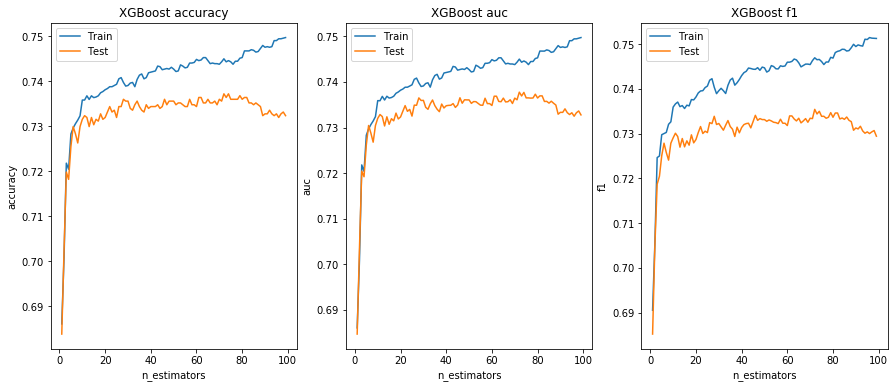

In [45]:
nb_estim = get_nb_estimators_XGB(XGBClassifier,
                                 gsearch_XG,
                                 range(1, 100),
                                 test_x,
                                 test_y,
                                 train_x,
                                 train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(1, 100)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('XGBoost accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('XGBoost auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('XGBoost f1')
plt.show()

##### Le modèle sur-apprend très tôt. Comme pour le RandomForest nous allons donc cibler les premieres possibilités pour le paramètre "n_estimators".

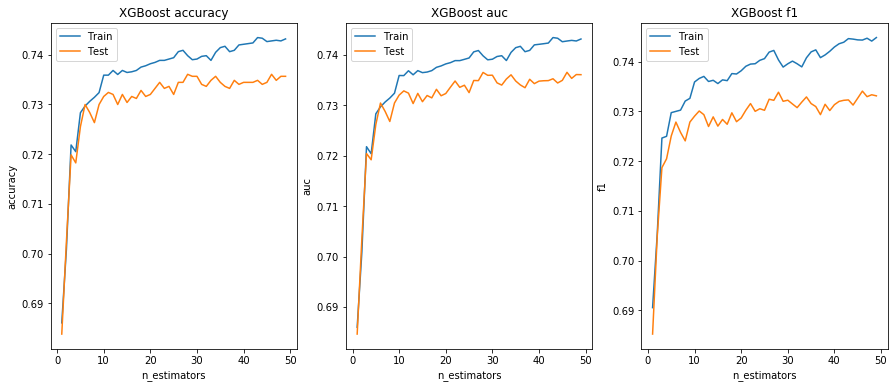

In [46]:
nb_estim = get_nb_estimators_XGB(XGBClassifier,
                                 gsearch_XG,
                                 range(1, 50),
                                 test_x,
                                 test_y,
                                 train_x,
                                 train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(1, 50)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('XGBoost accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('XGBoost auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('XGBoost f1')
plt.show()

In [47]:
model_XGB_tun = XGBClassifier(max_depth = gsearch_XG.best_params_['max_depth'],
                              subsample = gsearch_XG.best_params_['subsample'],
                              colsample_bytree = gsearch_XG.best_params_['colsample_bytree'],
                              learning_rate = 0.05,
                              n_estimators = 9)
 
model_XGB_tun.fit(train_x, train_y.values.ravel())

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=9, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method=None, validate_parameters=False, verbosity=None)

##### On choisit une valeur pour laquelle les 3 métriques sont assez rapprochés sans pour autant chercher le croisement entre les 2 courbes. Ainsi nous gardons 9 comme valeur optimale pour le paramètre "n_estimators".

# Évaluation des variables :

##  Modèle RForest :

In [48]:
model_RF_tun.feature_importances_

array([3.30936057e-01, 1.56956075e-01, 6.40439742e-04, 3.78331656e-03,
       4.76647361e-03, 1.77344987e-03, 9.73626042e-05, 2.81456921e-02,
       0.00000000e+00, 2.99700505e-02, 3.98441329e-03, 2.69824422e-02,
       5.77872864e-02, 1.10592382e-02, 2.62422956e-03, 0.00000000e+00,
       1.43455265e-01, 2.04030585e-03, 2.37059958e-02, 0.00000000e+00,
       1.71291907e-01])

In [49]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names=df.columns

perm = PermutationImportance(model_RF_tun, random_state=1).fit(train_x, train_y)
eli5.show_weights(perm, feature_names = train_x.columns.tolist())

C:\Users\Proprietaire\.conda\envs\test\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Proprietaire\.conda\envs\test\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0468 ± 0.0074,GoldDiff
0.0134 ± 0.0024,ExpDiff
0.0057 ± 0.0013,blueDeaths
0.0033 ± 0.0039,redAvgLevel
0.0027 ± 0.0028,blueAvgLevel
0.0027 ± 0.0013,redEliteMonsters
0.0021 ± 0.0017,Dragon
0.0011 ± 0.0011,blueAssists
0.0011 ± 0.0007,JungleMinionsDiff
0.0010 ± 0.0013,blueEliteMonsters


##### Le package "eli5" permet d'obtenir une importance pour chaque variable de notre dataframe. Plus une variable est séléctionnée souvent dans les arbres du modèle, plus son importance sera forte.
##### Ici nos variables "GoldDiff" et "ExpDiff" semblent expliquer l'ensemble de la prédiction de notre modèle.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


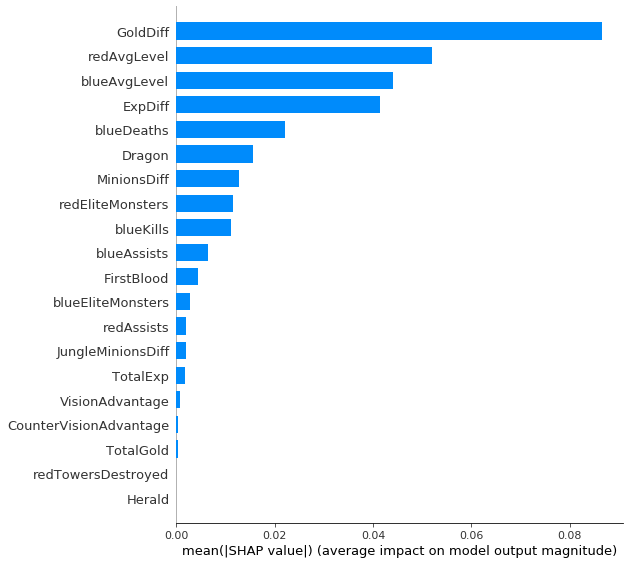

In [50]:
import shap

explainer_RF = shap.TreeExplainer(model_RF_tun)

shap_values_RF = explainer_RF.shap_values(test_x)

shap.summary_plot(shap_values_RF[1], test_x, plot_type="bar")

##### Les valeurs de shap permettent de montrer l'influence d'une variable sur la probabilité de notre variable à prédire.
##### Ici nos indicateurs qui influence le plus la probabilité de gagner sont les mêmes que pour l'importance. La variable "ExpDiff" semblent être plus souvent présente dans les arbres du modèle, cependant elle semblent avoir moins d'impact sur la probabilité que les variables "redAvgLevel" et "blueAvgLevel". 

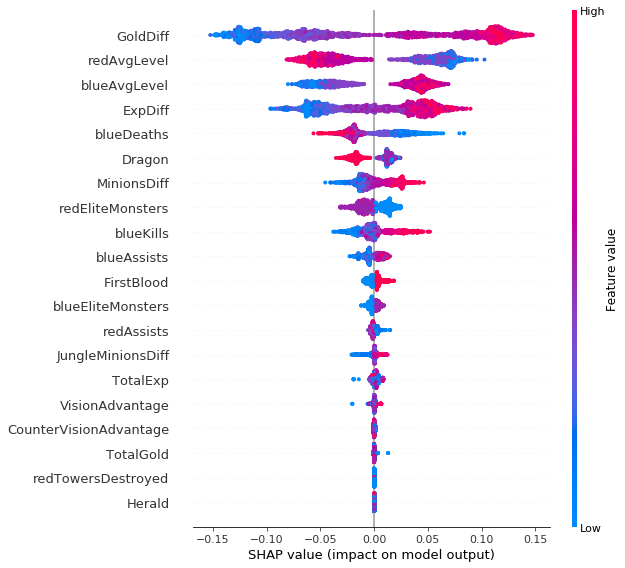

In [51]:
shap.summary_plot(shap_values_RF[1],
                  test_x)

##### Ce graphique présente les propos énoncer plus haut mais avec une dimension supplémentaire qui est la valeur de la variable elle-même.
##### On voit que pour la plupart de nos variables les valeurs fortes et faibles sont très peu confondues dans l'influence sur la probabilité de gagner. Une valeur forte de "GoldDiff" va ainsi influencer toujours à la hausse la victoire. Inversement, une faible valeur va toujours augmenter la probabilité de perdre.

## Modèle XGBoost :

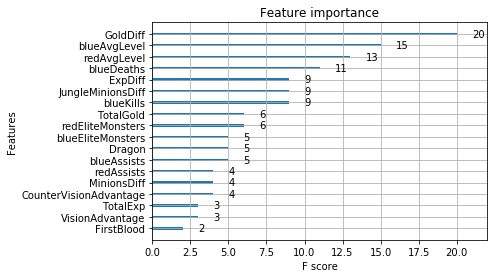

In [52]:
from xgboost import plot_importance

plot_importance(model_XGB_tun)
plt.show()

##### Le package xgboost contient directement une fonction "plot_importance" permettant d'afficher l'importance de chaque variables de notre modèle.
##### Les variables dominante sont plus ou moins les mêmes pour nos deux modèles. La "GoldDiff" et les variables "redAvgLevel" et "blueAvgLevel" sont les plus souvent choisis dans les arbres du modèle.

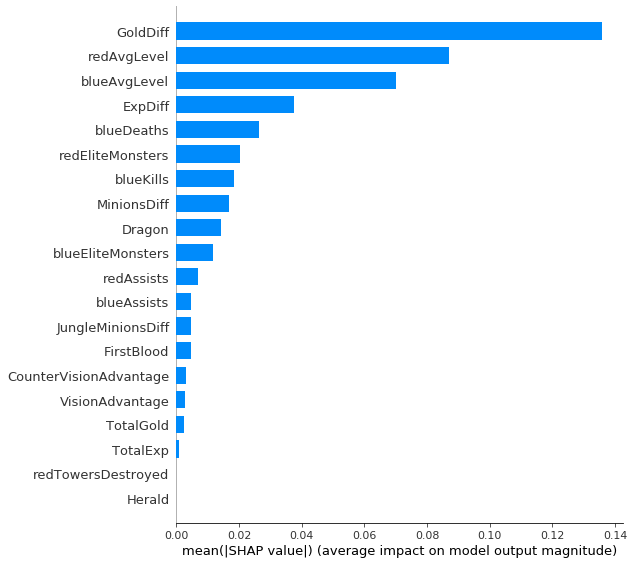

In [53]:
import shap

explainer_XG = shap.TreeExplainer(model_XGB_tun)

shap_values_XG = explainer_XG.shap_values(test_x)

shap.summary_plot(shap_values_XG, test_x, plot_type="bar")

##### Le graphique présentant les valeurs de shap pour notre modèle montre des similitudes avec l'importance dans l'ordre des variables. La variable GoldDiff écrase completement les autres variables en terme d'influence sur la probabilité.

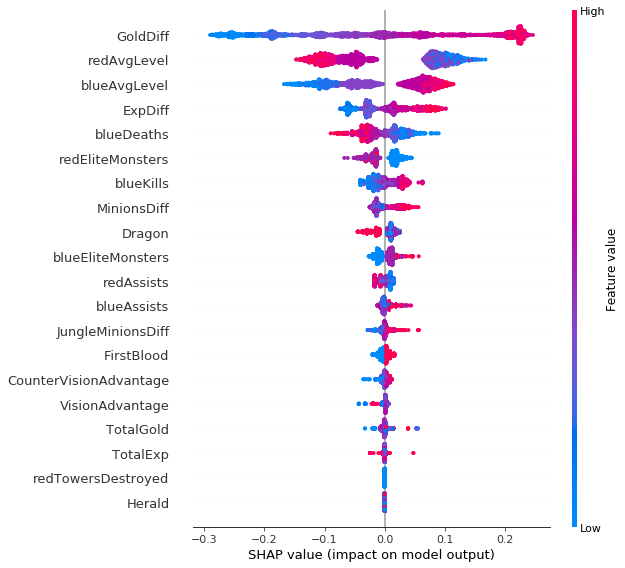

In [54]:
shap.summary_plot(shap_values_XG, test_x)

##### On constate que même si les résultats semblent assez similaire entre le RandomForest et le XGBoost. Le XGBoost accorde plus de poids à la variable "GoldDiff" que le RandomForest.

# Cross-Validation des modèles

##### Il est à présent important de vérifier que nos modèles ne sont pas corrélés au split de nos données en train et test. Ainsi nous allons proceder à une cross-validation pour vérifier cela.

In [55]:
from sklearn.model_selection import cross_val_score

def eval_model(list_model,
               list_metrics):
    score_df = pd.DataFrame(columns=['Metrics', 'Model', 'Min_Value', 'Max_Value'])
    score_df.style.hide_index()
    counter = 0
    for met in list_metrics:
        for mod in list_model:
            nom_model = type(mod).__name__
            score = cross_val_score(mod,
                                    x,
                                    y.values.ravel(),
                                    cv = 4,
                                    scoring = met)
            score_min = score.min()
            score_max = score.max()
            score_df.loc[counter] = [met, nom_model ,score_min, score_max]
            counter = counter + 1
    return score_df

##### La fonction "eval_model" va creer un dataframe pour les métriques du paramètre "list_metrics" pour les modèles du paramètre "list_model". Nous aurons comme valeur de la metrique son min et son max pour tous les split. Ainsi si nous obtenons un min et un max assez similaire nous pourrons conclure que notre modèle ne dépend pas du split des données. 

In [56]:
df_eval = eval_model(list_model = [model_RF_tun, model_XGB_tun, model_logreg],
          list_metrics = ['accuracy', 'precision', 'recall', 'roc_auc'])

df_eval

,Metrics,Model,Min_Value,Max_Value
0,accuracy,RandomForestClassifier,0.723077,0.734008
1,accuracy,XGBClassifier,0.718510,0.731579
2,accuracy,LogisticRegression,0.724696,0.733198
3,precision,RandomForestClassifier,0.702888,0.746759
4,precision,XGBClassifier,0.713944,0.737500
5,precision,LogisticRegression,0.724980,0.735415
6,recall,RandomForestClassifier,0.692620,0.729927
7,recall,XGBClassifier,0.702922,0.727273
8,recall,LogisticRegression,0.722628,0.736201
9,roc_auc,RandomForestClassifier,0.795576,0.806318


##### Seul le RandomForest semble avoir un recall très instable selon le split des données. Le XGBoost et la Régression Logistique possèdent des valeurs plutôt similaire. 
##### On peut donc conclure que nos meilleurs modèles sont la Régression Logistique et le XGBoost. Si l'on prend en compte le temps de calcul la Régression Logistique l'emporte largement.

# Création d'un modèle sans GoldDiff et sans ExpDiff :

##### Au vu des résultats précédents nous voulons désormais challenger nos 3 modèles sur les mêmes données mais retirés de la variable principalement utilisée par ceux-ci. Il s'agit de la variable "GoldDiff". Nous retirons égallement "ExpDiff" car celle ci porte des informations similaire aux variables "redAvgLevel" et "blueAvgLevel".

In [57]:
train_x_wtgd = train_x.copy()
test_x_wtgd = test_x.copy()

In [58]:
train_x_wtgd = train_x_wtgd.drop(['GoldDiff', 'ExpDiff'], axis=1)
test_x_wtgd = test_x_wtgd.drop(['GoldDiff', 'ExpDiff'], axis=1)

##### Nous gardons notre même split pour avoir des comparaison sur le même périmètre.

## Régression Logistique

In [59]:
acp_wtgd = PCA(3)
acp_wtgd.fit(train_x_wtgd, train_y)

train_x_wtgd_acp = acp_wtgd.transform(train_x_wtgd)
train_x_wtgd_acp.shape

(7409, 3)

In [60]:
model_logreg_wtdg = LogisticRegression(solver='lbfgs')
model_logreg_wtdg.fit(train_x_wtgd_acp, train_y.values.ravel())

model_logreg_wtdg.coef_

test_x_wtgd_acp = acp_wtgd.transform(test_x_wtgd)
pred_LR_wtgd = model_logreg_wtdg.predict(test_x_wtgd_acp)
print(mean_absolute_error(test_y, pred_LR_wtgd))

0.3659919028340081


##### La procédure reste la même pour la Régression Logistique. Néanmoins les résultats semblent moins bon que sur les anciennes données.

## RandomForest

### Tuning du model :

In [61]:
from sklearn.model_selection import GridSearchCV

param_test_RF = {'min_samples_split':range(2, 6),
              'max_depth' : range(1, 6),
              'min_samples_leaf' : range(1, 10)
}

gsearch_RF_wtgd = GridSearchCV(estimator = RandomForestClassifier(), 
param_grid = param_test_RF, scoring='accuracy', cv=4)
gsearch_RF_wtgd.fit(train_x_wtgd, train_y.values.ravel())

gsearch_RF_wtgd.best_score_, gsearch_RF_wtgd.best_params_

(0.7173704220230109,
 {'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 3})

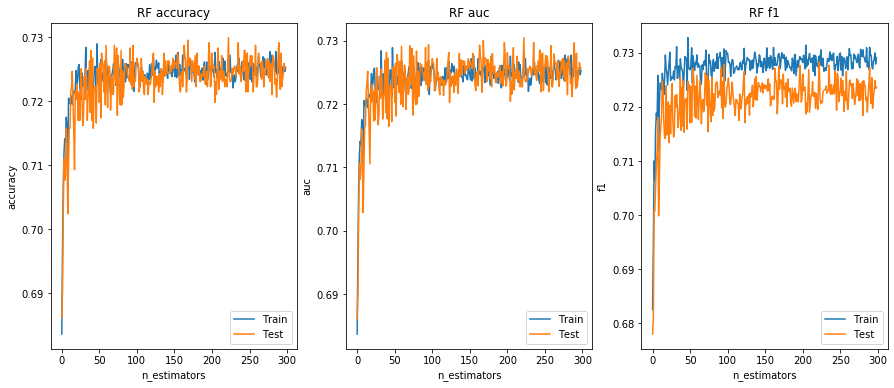

In [62]:
nb_estim = get_nb_estimators_RF(RandomForestClassifier,
                                gsearch_RF_wtgd,
                                range(1, 300),
                                test_x_wtgd,
                                test_y,
                                train_x_wtgd,
                                train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(0, nb_iterations)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('RF accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('RF auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('RF f1')
plt.show()

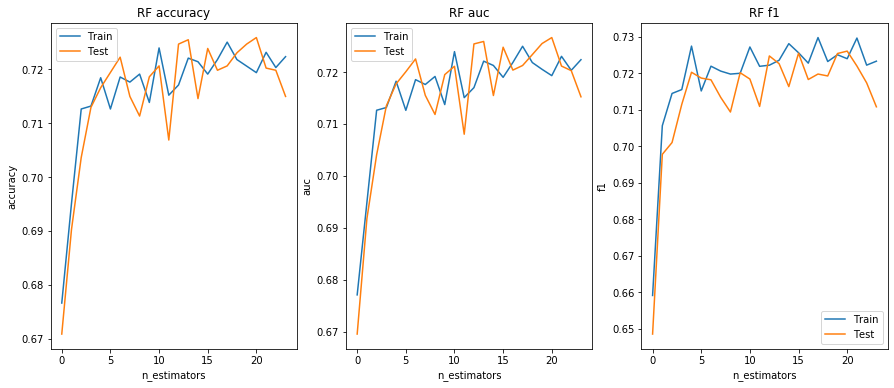

In [63]:
nb_estim = get_nb_estimators_RF(RandomForestClassifier,
                                gsearch_RF_wtgd,
                                range(1, 25),
                                test_x_wtgd,
                                test_y,
                                train_x_wtgd,
                                train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(0, nb_iterations)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('RF accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('RF auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('RF f1')
plt.show()

In [64]:
model_RF_tun_wtgd = RandomForestClassifier(min_samples_split = gsearch_RF_wtgd.best_params_['min_samples_split'],
                                           max_depth = gsearch_RF_wtgd.best_params_['max_depth'],
                                           min_samples_leaf = gsearch_RF_wtgd.best_params_['min_samples_leaf'],
                                           n_estimators = 5)

model_RF_tun_wtgd.fit(train_x_wtgd, train_y.values.ravel())

RandomForestClassifier(max_depth=4, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=5)

##### Comme précédement le modèle converge très vite, une valeur de 5 arbres suffit donc pour obtenir la valeur optimale de prédiction.

### Variables : 

In [65]:
feature_names=df.drop(['GoldDiff', 'ExpDiff'], axis=1).columns

perm = PermutationImportance(model_RF_tun_wtgd, random_state=1).fit(train_x_wtgd, train_y)
eli5.show_weights(perm, feature_names = train_x_wtgd.columns.tolist())

Weight,Feature
0.0330 ± 0.0055,redAvgLevel
0.0239 ± 0.0040,blueAvgLevel
0.0159 ± 0.0092,blueDeaths
0.0150 ± 0.0041,blueKills
0.0055 ± 0.0030,redEliteMonsters
0.0036 ± 0.0033,MinionsDiff
0.0030 ± 0.0027,FirstBlood
0.0028 ± 0.0037,redAssists
0.0023 ± 0.0008,blueEliteMonsters
0.0007 ± 0.0030,Dragon


##### Nos indicateurs les plus importants sont sans surprise ceux qui étaient déjà les plus souvent présent dans les arbres sur les variables restantes. Néanmoins on remarque que "blueDeaths" et "blueKills" sont devenues beaucoup plus présentes que précédement.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


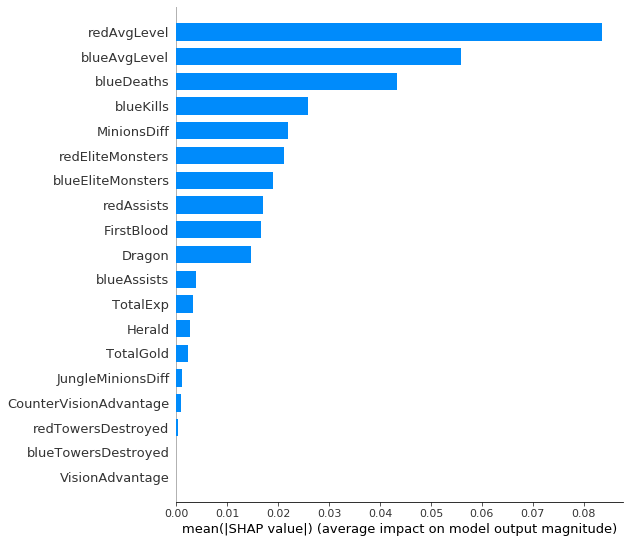

In [66]:
explainer_RF = shap.TreeExplainer(model_RF_tun_wtgd)

shap_values_RF = explainer_RF.shap_values(test_x_wtgd)

shap.summary_plot(shap_values_RF[1], test_x_wtgd, plot_type="bar")

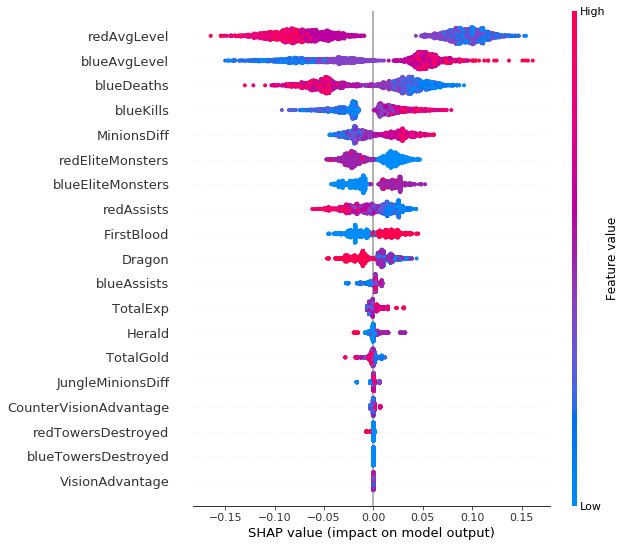

In [67]:
shap.summary_plot(shap_values_RF[1],
                  test_x_wtgd)

##### Les valeurs de shap sont globalement semblables à l'importance pour le RandomForest.

## XGBOOST

In [68]:
from xgboost import XGBClassifier

model_XGBoost_wtgd = XGBClassifier()
model_XGBoost_wtgd.fit(train_x_wtgd, train_y.values.ravel())

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [69]:
from sklearn.metrics import mean_absolute_error

pred_wtgd_XGBoost = model_XGBoost_wtgd.predict(test_x_wtgd)
print(mean_absolute_error(test_y, pred_wtgd_XGBoost))

0.297165991902834


### Tuning du model :

In [70]:
from sklearn.model_selection import GridSearchCV

eval_set_wtgd = [(train_x_wtgd, train_y), (test_x_wtgd, test_y)]

param_test = {'colsample_bytree':[0.4, 0.6, 0.8],
              'max_depth' : [2, 4, 6, 8, 10, 12],
              'subsample' : [0.4, 0.6, 0.8]
}
gsearch_XG_wtgd = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.05,
                                                         n_estimators = 500),
                               param_grid = param_test,
                               scoring='accuracy',
                               cv=4)

gsearch_XG_wtgd.fit(train_x_wtgd,
                    train_y.values.ravel(),
                    eval_metric='auc',
                    eval_set=eval_set_wtgd,
                    early_stopping_rounds=10)

[0]	validation_0-auc:0.69170	validation_1-auc:0.69539
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.69995	validation_1-auc:0.70983
[2]	validation_0-auc:0.73539	validation_1-auc:0.74661
[3]	validation_0-auc:0.74469	validation_1-auc:0.75163
[4]	validation_0-auc:0.75309	validation_1-auc:0.75582
[5]	validation_0-auc:0.75411	validation_1-auc:0.75929
[6]	validation_0-auc:0.76824	validation_1-auc:0.77297
[7]	validation_0-auc:0.77463	validation_1-auc:0.77743
[8]	validation_0-auc:0.77772	validation_1-auc:0.77887
[9]	validation_0-auc:0.78225	validation_1-auc:0.78547
[10]	validation_0-auc:0.78456	validation_1-auc:0.78842
[11]	validation_0-auc:0.78548	validation_1-auc:0.79074
[12]	validation_0-auc:0.78600	validation_1-auc:0.79085


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13]	validation_0-auc:0.78560	validation_1-auc:0.78985
[14]	validation_0-auc:0.78578	validation_1-auc:0.79017
[15]	validation_0-auc:0.78700	validation_1-auc:0.79168
[16]	validation_0-auc:0.78797	validation_1-auc:0.79286
[17]	validation_0-auc:0.78838	validation_1-auc:0.79290
[18]	validation_0-auc:0.78799	validation_1-auc:0.79255
[19]	validation_0-auc:0.78825	validation_1-auc:0.79301
[20]	validation_0-auc:0.78956	validation_1-auc:0.79331
[21]	validation_0-auc:0.79064	validation_1-auc:0.79385
[22]	validation_0-auc:0.79073	validation_1-auc:0.79371
[23]	validation_0-auc:0.79104	validation_1-auc:0.79297
[24]	validation_0-auc:0.79144	validation_1-auc:0.79383
[25]	validation_0-auc:0.79196	validation_1-auc:0.79515
[26]	validation_0-auc:0.79205	validation_1-auc:0.79575
[27]	validation_0-auc:0.79234	validation_1-auc:0.79644
[28]	validation_0-auc:0.79261	validation_1-auc:0.79647
[29]	validation_0-auc:0.79307	validation_1-auc:0.79622
[30]	validation_0-auc:0.79264	validation_1-auc:0.79665
[31]	valid

[43]	validation_0-auc:0.79511	validation_1-auc:0.79578
[44]	validation_0-auc:0.79549	validation_1-auc:0.79621
[45]	validation_0-auc:0.79595	validation_1-auc:0.79604
[46]	validation_0-auc:0.79612	validation_1-auc:0.79668
[47]	validation_0-auc:0.79611	validation_1-auc:0.79709
[48]	validation_0-auc:0.79614	validation_1-auc:0.79680
[49]	validation_0-auc:0.79671	validation_1-auc:0.79731
[50]	validation_0-auc:0.79692	validation_1-auc:0.79739
[51]	validation_0-auc:0.79741	validation_1-auc:0.79727
[52]	validation_0-auc:0.79783	validation_1-auc:0.79719
[53]	validation_0-auc:0.79820	validation_1-auc:0.79719
[54]	validation_0-auc:0.79839	validation_1-auc:0.79775
[55]	validation_0-auc:0.79849	validation_1-auc:0.79817
[56]	validation_0-auc:0.79892	validation_1-auc:0.79848
[57]	validation_0-auc:0.79935	validation_1-auc:0.79860
[58]	validation_0-auc:0.79941	validation_1-auc:0.79880
[59]	validation_0-auc:0.79933	validation_1-auc:0.79882
[60]	validation_0-auc:0.79970	validation_1-auc:0.79905
[61]	valid

[49]	validation_0-auc:0.79915	validation_1-auc:0.79981
[50]	validation_0-auc:0.79936	validation_1-auc:0.80009
[51]	validation_0-auc:0.79978	validation_1-auc:0.79972
[52]	validation_0-auc:0.79999	validation_1-auc:0.79974
[53]	validation_0-auc:0.80022	validation_1-auc:0.79936
[54]	validation_0-auc:0.80047	validation_1-auc:0.79963
[55]	validation_0-auc:0.80066	validation_1-auc:0.79987
[56]	validation_0-auc:0.80079	validation_1-auc:0.79990
[57]	validation_0-auc:0.80121	validation_1-auc:0.80028
[58]	validation_0-auc:0.80133	validation_1-auc:0.80062
[59]	validation_0-auc:0.80136	validation_1-auc:0.80024
[60]	validation_0-auc:0.80161	validation_1-auc:0.80069
[61]	validation_0-auc:0.80178	validation_1-auc:0.80105
[62]	validation_0-auc:0.80182	validation_1-auc:0.80131
[63]	validation_0-auc:0.80192	validation_1-auc:0.80096
[64]	validation_0-auc:0.80205	validation_1-auc:0.80062
[65]	validation_0-auc:0.80212	validation_1-auc:0.80062
[66]	validation_0-auc:0.80215	validation_1-auc:0.80059
[67]	valid

[4]	validation_0-auc:0.75535	validation_1-auc:0.75335
[5]	validation_0-auc:0.76019	validation_1-auc:0.75875
[6]	validation_0-auc:0.77440	validation_1-auc:0.77361
[7]	validation_0-auc:0.77919	validation_1-auc:0.77839
[8]	validation_0-auc:0.78135	validation_1-auc:0.77836
[9]	validation_0-auc:0.78440	validation_1-auc:0.78358
[10]	validation_0-auc:0.78773	validation_1-auc:0.78815
[11]	validation_0-auc:0.78747	validation_1-auc:0.78946
[12]	validation_0-auc:0.78841	validation_1-auc:0.79016
[13]	validation_0-auc:0.78782	validation_1-auc:0.78999
[14]	validation_0-auc:0.78617	validation_1-auc:0.78823
[15]	validation_0-auc:0.78711	validation_1-auc:0.78987
[16]	validation_0-auc:0.78781	validation_1-auc:0.79060
[17]	validation_0-auc:0.78875	validation_1-auc:0.79054
[18]	validation_0-auc:0.78930	validation_1-auc:0.79088
[19]	validation_0-auc:0.79061	validation_1-auc:0.79142
[20]	validation_0-auc:0.79161	validation_1-auc:0.79247
[21]	validation_0-auc:0.79246	validation_1-auc:0.79229
[22]	validation_

[34]	validation_0-auc:0.79245	validation_1-auc:0.79337
[35]	validation_0-auc:0.79301	validation_1-auc:0.79394
[36]	validation_0-auc:0.79326	validation_1-auc:0.79356
[37]	validation_0-auc:0.79339	validation_1-auc:0.79418
[38]	validation_0-auc:0.79380	validation_1-auc:0.79477
[39]	validation_0-auc:0.79401	validation_1-auc:0.79477
[40]	validation_0-auc:0.79437	validation_1-auc:0.79472
[41]	validation_0-auc:0.79453	validation_1-auc:0.79448
[42]	validation_0-auc:0.79469	validation_1-auc:0.79477
[43]	validation_0-auc:0.79486	validation_1-auc:0.79468
[44]	validation_0-auc:0.79513	validation_1-auc:0.79495
[45]	validation_0-auc:0.79555	validation_1-auc:0.79467
[46]	validation_0-auc:0.79591	validation_1-auc:0.79555
[47]	validation_0-auc:0.79629	validation_1-auc:0.79578
[48]	validation_0-auc:0.79617	validation_1-auc:0.79601
[49]	validation_0-auc:0.79670	validation_1-auc:0.79659
[50]	validation_0-auc:0.79728	validation_1-auc:0.79716
[51]	validation_0-auc:0.79758	validation_1-auc:0.79704
[52]	valid

[29]	validation_0-auc:0.79428	validation_1-auc:0.79348
[30]	validation_0-auc:0.79473	validation_1-auc:0.79314
[31]	validation_0-auc:0.79519	validation_1-auc:0.79419
[32]	validation_0-auc:0.79546	validation_1-auc:0.79474
[33]	validation_0-auc:0.79550	validation_1-auc:0.79491
[34]	validation_0-auc:0.79579	validation_1-auc:0.79497
[35]	validation_0-auc:0.79609	validation_1-auc:0.79556
[36]	validation_0-auc:0.79602	validation_1-auc:0.79525
[37]	validation_0-auc:0.79680	validation_1-auc:0.79572
[38]	validation_0-auc:0.79692	validation_1-auc:0.79566
[39]	validation_0-auc:0.79719	validation_1-auc:0.79574
[40]	validation_0-auc:0.79717	validation_1-auc:0.79601
[41]	validation_0-auc:0.79718	validation_1-auc:0.79559
[42]	validation_0-auc:0.79728	validation_1-auc:0.79532
[43]	validation_0-auc:0.79724	validation_1-auc:0.79533
[44]	validation_0-auc:0.79741	validation_1-auc:0.79580
[45]	validation_0-auc:0.79762	validation_1-auc:0.79525
[46]	validation_0-auc:0.79789	validation_1-auc:0.79581
[47]	valid

[67]	validation_0-auc:0.80194	validation_1-auc:0.80075
[68]	validation_0-auc:0.80214	validation_1-auc:0.80096
[69]	validation_0-auc:0.80226	validation_1-auc:0.80103
[70]	validation_0-auc:0.80228	validation_1-auc:0.80116
[71]	validation_0-auc:0.80240	validation_1-auc:0.80140
[72]	validation_0-auc:0.80230	validation_1-auc:0.80143
[73]	validation_0-auc:0.80250	validation_1-auc:0.80162
[74]	validation_0-auc:0.80269	validation_1-auc:0.80184
[75]	validation_0-auc:0.80292	validation_1-auc:0.80192
[76]	validation_0-auc:0.80307	validation_1-auc:0.80211
[77]	validation_0-auc:0.80324	validation_1-auc:0.80226
[78]	validation_0-auc:0.80338	validation_1-auc:0.80234
[79]	validation_0-auc:0.80346	validation_1-auc:0.80224
[80]	validation_0-auc:0.80361	validation_1-auc:0.80240
[81]	validation_0-auc:0.80367	validation_1-auc:0.80224
[82]	validation_0-auc:0.80387	validation_1-auc:0.80249
[83]	validation_0-auc:0.80400	validation_1-auc:0.80257
[84]	validation_0-auc:0.80410	validation_1-auc:0.80251
[85]	valid

[55]	validation_0-auc:0.79783	validation_1-auc:0.79793
[56]	validation_0-auc:0.79787	validation_1-auc:0.79813
[57]	validation_0-auc:0.79838	validation_1-auc:0.79827
[58]	validation_0-auc:0.79845	validation_1-auc:0.79849
[59]	validation_0-auc:0.79853	validation_1-auc:0.79855
[60]	validation_0-auc:0.79892	validation_1-auc:0.79893
[61]	validation_0-auc:0.79902	validation_1-auc:0.79894
[62]	validation_0-auc:0.79914	validation_1-auc:0.79903
[63]	validation_0-auc:0.79934	validation_1-auc:0.79891
[64]	validation_0-auc:0.79949	validation_1-auc:0.79900
[65]	validation_0-auc:0.79957	validation_1-auc:0.79892
[66]	validation_0-auc:0.79978	validation_1-auc:0.79895
[67]	validation_0-auc:0.79990	validation_1-auc:0.79893
[68]	validation_0-auc:0.80008	validation_1-auc:0.79886
[69]	validation_0-auc:0.80012	validation_1-auc:0.79883
[70]	validation_0-auc:0.80034	validation_1-auc:0.79925
[71]	validation_0-auc:0.80070	validation_1-auc:0.79948
[72]	validation_0-auc:0.80082	validation_1-auc:0.79937
[73]	valid

[61]	validation_0-auc:0.80106	validation_1-auc:0.79934
[62]	validation_0-auc:0.80120	validation_1-auc:0.79942
[63]	validation_0-auc:0.80131	validation_1-auc:0.79907
[64]	validation_0-auc:0.80147	validation_1-auc:0.79894
[65]	validation_0-auc:0.80156	validation_1-auc:0.79912
[66]	validation_0-auc:0.80159	validation_1-auc:0.79899
[67]	validation_0-auc:0.80163	validation_1-auc:0.79876
[68]	validation_0-auc:0.80161	validation_1-auc:0.79844
[69]	validation_0-auc:0.80176	validation_1-auc:0.79849
[70]	validation_0-auc:0.80202	validation_1-auc:0.79853
[71]	validation_0-auc:0.80225	validation_1-auc:0.79855
[72]	validation_0-auc:0.80232	validation_1-auc:0.79864
Stopping. Best iteration:
[62]	validation_0-auc:0.80120	validation_1-auc:0.79942

[0]	validation_0-auc:0.68659	validation_1-auc:0.70211
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.74041	validation_1-auc:0

[23]	validation_0-auc:0.80803	validation_1-auc:0.79956
[24]	validation_0-auc:0.80829	validation_1-auc:0.79983
[25]	validation_0-auc:0.80851	validation_1-auc:0.80044
[26]	validation_0-auc:0.80862	validation_1-auc:0.80088
[27]	validation_0-auc:0.80934	validation_1-auc:0.80167
[28]	validation_0-auc:0.80972	validation_1-auc:0.80139
[29]	validation_0-auc:0.81018	validation_1-auc:0.80183
[30]	validation_0-auc:0.81030	validation_1-auc:0.80210
[31]	validation_0-auc:0.81070	validation_1-auc:0.80235
[32]	validation_0-auc:0.81088	validation_1-auc:0.80249
[33]	validation_0-auc:0.81075	validation_1-auc:0.80229
[34]	validation_0-auc:0.81099	validation_1-auc:0.80195
[35]	validation_0-auc:0.81098	validation_1-auc:0.80150
[36]	validation_0-auc:0.81147	validation_1-auc:0.80161
[37]	validation_0-auc:0.81151	validation_1-auc:0.80175
[38]	validation_0-auc:0.81170	validation_1-auc:0.80214
[39]	validation_0-auc:0.81204	validation_1-auc:0.80224
[40]	validation_0-auc:0.81229	validation_1-auc:0.80253
[41]	valid

[0]	validation_0-auc:0.73918	validation_1-auc:0.71901
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.75274	validation_1-auc:0.74237
[2]	validation_0-auc:0.77019	validation_1-auc:0.75961
[3]	validation_0-auc:0.77740	validation_1-auc:0.76736
[4]	validation_0-auc:0.78262	validation_1-auc:0.76948
[5]	validation_0-auc:0.78722	validation_1-auc:0.77386
[6]	validation_0-auc:0.79274	validation_1-auc:0.78085
[7]	validation_0-auc:0.79677	validation_1-auc:0.78512
[8]	validation_0-auc:0.79949	validation_1-auc:0.78715
[9]	validation_0-auc:0.80074	validation_1-auc:0.78941
[10]	validation_0-auc:0.80248	validation_1-auc:0.79219
[11]	validation_0-auc:0.80358	validation_1-auc:0.79280
[12]	validation_0-auc:0.80363	validation_1-auc:0.79329
[13]	validation_0-auc:0.80480	validation_1-auc:0.79355
[14]	validation_0-auc:0.80456	validation_1-auc:0.79311
[15]	validation_0-auc:0.8056

[34]	validation_0-auc:0.81312	validation_1-auc:0.79851
[35]	validation_0-auc:0.81349	validation_1-auc:0.79902
[36]	validation_0-auc:0.81352	validation_1-auc:0.79910
[37]	validation_0-auc:0.81362	validation_1-auc:0.79977
[38]	validation_0-auc:0.81386	validation_1-auc:0.79986
[39]	validation_0-auc:0.81387	validation_1-auc:0.79975
[40]	validation_0-auc:0.81397	validation_1-auc:0.79996
[41]	validation_0-auc:0.81418	validation_1-auc:0.80012
[42]	validation_0-auc:0.81438	validation_1-auc:0.80022
[43]	validation_0-auc:0.81461	validation_1-auc:0.80027
[44]	validation_0-auc:0.81469	validation_1-auc:0.80061
[45]	validation_0-auc:0.81495	validation_1-auc:0.80036
[46]	validation_0-auc:0.81505	validation_1-auc:0.80067
[47]	validation_0-auc:0.81537	validation_1-auc:0.80053
[48]	validation_0-auc:0.81576	validation_1-auc:0.80075
[49]	validation_0-auc:0.81629	validation_1-auc:0.80069
[50]	validation_0-auc:0.81647	validation_1-auc:0.80088
[51]	validation_0-auc:0.81665	validation_1-auc:0.80086
[52]	valid

[30]	validation_0-auc:0.81313	validation_1-auc:0.80132
[31]	validation_0-auc:0.81388	validation_1-auc:0.80207
[32]	validation_0-auc:0.81403	validation_1-auc:0.80223
[33]	validation_0-auc:0.81402	validation_1-auc:0.80206
[34]	validation_0-auc:0.81426	validation_1-auc:0.80183
[35]	validation_0-auc:0.81423	validation_1-auc:0.80116
[36]	validation_0-auc:0.81452	validation_1-auc:0.80146
[37]	validation_0-auc:0.81456	validation_1-auc:0.80205
[38]	validation_0-auc:0.81498	validation_1-auc:0.80232
[39]	validation_0-auc:0.81550	validation_1-auc:0.80246
[40]	validation_0-auc:0.81575	validation_1-auc:0.80282
[41]	validation_0-auc:0.81609	validation_1-auc:0.80324
[42]	validation_0-auc:0.81634	validation_1-auc:0.80362
[43]	validation_0-auc:0.81653	validation_1-auc:0.80339
[44]	validation_0-auc:0.81696	validation_1-auc:0.80333
[45]	validation_0-auc:0.81717	validation_1-auc:0.80333
[46]	validation_0-auc:0.81738	validation_1-auc:0.80298
[47]	validation_0-auc:0.81753	validation_1-auc:0.80286
[48]	valid

[43]	validation_0-auc:0.81643	validation_1-auc:0.80195
[44]	validation_0-auc:0.81656	validation_1-auc:0.80205
[45]	validation_0-auc:0.81689	validation_1-auc:0.80190
[46]	validation_0-auc:0.81713	validation_1-auc:0.80207
[47]	validation_0-auc:0.81743	validation_1-auc:0.80178
[48]	validation_0-auc:0.81777	validation_1-auc:0.80207
Stopping. Best iteration:
[38]	validation_0-auc:0.81561	validation_1-auc:0.80216

[0]	validation_0-auc:0.74012	validation_1-auc:0.72244
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.76843	validation_1-auc:0.75358
[2]	validation_0-auc:0.78323	validation_1-auc:0.77492
[3]	validation_0-auc:0.79239	validation_1-auc:0.78229
[4]	validation_0-auc:0.79082	validation_1-auc:0.77865
[5]	validation_0-auc:0.79155	validation_1-auc:0.77717
[6]	validation_0-auc:0.79132	validation_1-auc:0.77963
[7]	validation_0-auc:0.79251	validation_1-auc:0.77931

[28]	validation_0-auc:0.83066	validation_1-auc:0.79655
[29]	validation_0-auc:0.83078	validation_1-auc:0.79674
[30]	validation_0-auc:0.83137	validation_1-auc:0.79688
Stopping. Best iteration:
[20]	validation_0-auc:0.82575	validation_1-auc:0.79746

[0]	validation_0-auc:0.74192	validation_1-auc:0.71720
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.77130	validation_1-auc:0.75119
[2]	validation_0-auc:0.79021	validation_1-auc:0.77535
[3]	validation_0-auc:0.80291	validation_1-auc:0.78268
[4]	validation_0-auc:0.80329	validation_1-auc:0.78026
[5]	validation_0-auc:0.80516	validation_1-auc:0.77706
[6]	validation_0-auc:0.80724	validation_1-auc:0.78358
[7]	validation_0-auc:0.80919	validation_1-auc:0.78330
[8]	validation_0-auc:0.81398	validation_1-auc:0.78919
[9]	validation_0-auc:0.81524	validation_1-auc:0.79113
[10]	validation_0-auc:0.81792	validation_1-auc:0.79278
[

[10]	validation_0-auc:0.82411	validation_1-auc:0.78997
[11]	validation_0-auc:0.82645	validation_1-auc:0.79146
[12]	validation_0-auc:0.82783	validation_1-auc:0.79301
[13]	validation_0-auc:0.82784	validation_1-auc:0.79335
[14]	validation_0-auc:0.82896	validation_1-auc:0.79392
[15]	validation_0-auc:0.82979	validation_1-auc:0.79426
[16]	validation_0-auc:0.83026	validation_1-auc:0.79474
[17]	validation_0-auc:0.83137	validation_1-auc:0.79566
[18]	validation_0-auc:0.83257	validation_1-auc:0.79528
[19]	validation_0-auc:0.83307	validation_1-auc:0.79502
[20]	validation_0-auc:0.83452	validation_1-auc:0.79510
[21]	validation_0-auc:0.83533	validation_1-auc:0.79465
[22]	validation_0-auc:0.83583	validation_1-auc:0.79510
[23]	validation_0-auc:0.83693	validation_1-auc:0.79572
[24]	validation_0-auc:0.83709	validation_1-auc:0.79555
[25]	validation_0-auc:0.83794	validation_1-auc:0.79550
[26]	validation_0-auc:0.83816	validation_1-auc:0.79542
[27]	validation_0-auc:0.83860	validation_1-auc:0.79547
[28]	valid

[23]	validation_0-auc:0.83612	validation_1-auc:0.80112
[24]	validation_0-auc:0.83637	validation_1-auc:0.80110
[25]	validation_0-auc:0.83706	validation_1-auc:0.80154
[26]	validation_0-auc:0.83758	validation_1-auc:0.80169
[27]	validation_0-auc:0.83888	validation_1-auc:0.80187
[28]	validation_0-auc:0.83925	validation_1-auc:0.80187
[29]	validation_0-auc:0.83979	validation_1-auc:0.80188
[30]	validation_0-auc:0.84060	validation_1-auc:0.80213
[31]	validation_0-auc:0.84118	validation_1-auc:0.80283
[32]	validation_0-auc:0.84176	validation_1-auc:0.80296
[33]	validation_0-auc:0.84179	validation_1-auc:0.80296
[34]	validation_0-auc:0.84223	validation_1-auc:0.80275
[35]	validation_0-auc:0.84218	validation_1-auc:0.80217
[36]	validation_0-auc:0.84283	validation_1-auc:0.80212
[37]	validation_0-auc:0.84317	validation_1-auc:0.80206
[38]	validation_0-auc:0.84381	validation_1-auc:0.80263
[39]	validation_0-auc:0.84469	validation_1-auc:0.80269
[40]	validation_0-auc:0.84529	validation_1-auc:0.80270
[41]	valid

[10]	validation_0-auc:0.82647	validation_1-auc:0.79410
[11]	validation_0-auc:0.82888	validation_1-auc:0.79723
[12]	validation_0-auc:0.83040	validation_1-auc:0.79868
[13]	validation_0-auc:0.83102	validation_1-auc:0.79907
[14]	validation_0-auc:0.83212	validation_1-auc:0.79870
[15]	validation_0-auc:0.83345	validation_1-auc:0.79951
[16]	validation_0-auc:0.83325	validation_1-auc:0.79908
[17]	validation_0-auc:0.83390	validation_1-auc:0.79965
[18]	validation_0-auc:0.83464	validation_1-auc:0.80015
[19]	validation_0-auc:0.83534	validation_1-auc:0.79980
[20]	validation_0-auc:0.83668	validation_1-auc:0.79943
[21]	validation_0-auc:0.83744	validation_1-auc:0.79834
[22]	validation_0-auc:0.83799	validation_1-auc:0.79911
[23]	validation_0-auc:0.83907	validation_1-auc:0.79933
[24]	validation_0-auc:0.83941	validation_1-auc:0.79964
[25]	validation_0-auc:0.84013	validation_1-auc:0.79953
[26]	validation_0-auc:0.84064	validation_1-auc:0.79963
[27]	validation_0-auc:0.84110	validation_1-auc:0.79948
[28]	valid

[18]	validation_0-auc:0.84953	validation_1-auc:0.79320
[19]	validation_0-auc:0.85010	validation_1-auc:0.79324
[20]	validation_0-auc:0.85128	validation_1-auc:0.79344
[21]	validation_0-auc:0.85237	validation_1-auc:0.79244
[22]	validation_0-auc:0.85377	validation_1-auc:0.79206
[23]	validation_0-auc:0.85495	validation_1-auc:0.79209
[24]	validation_0-auc:0.85562	validation_1-auc:0.79219
[25]	validation_0-auc:0.85656	validation_1-auc:0.79173
Stopping. Best iteration:
[15]	validation_0-auc:0.84572	validation_1-auc:0.79393

[0]	validation_0-auc:0.74508	validation_1-auc:0.69840
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.77699	validation_1-auc:0.72117
[2]	validation_0-auc:0.80175	validation_1-auc:0.75115
[3]	validation_0-auc:0.81532	validation_1-auc:0.76311
[4]	validation_0-auc:0.82012	validation_1-auc:0.75822
[5]	validation_0-auc:0.82485	validation_1-auc:0.759

[31]	validation_0-auc:0.87479	validation_1-auc:0.79492
[32]	validation_0-auc:0.87599	validation_1-auc:0.79460
[33]	validation_0-auc:0.87694	validation_1-auc:0.79429
[34]	validation_0-auc:0.87806	validation_1-auc:0.79396
[35]	validation_0-auc:0.87853	validation_1-auc:0.79481
[36]	validation_0-auc:0.87833	validation_1-auc:0.79480
[37]	validation_0-auc:0.87889	validation_1-auc:0.79477
[38]	validation_0-auc:0.87970	validation_1-auc:0.79502
[39]	validation_0-auc:0.88019	validation_1-auc:0.79528
[40]	validation_0-auc:0.88091	validation_1-auc:0.79551
[41]	validation_0-auc:0.88124	validation_1-auc:0.79582
[42]	validation_0-auc:0.88178	validation_1-auc:0.79587
[43]	validation_0-auc:0.88243	validation_1-auc:0.79521
[44]	validation_0-auc:0.88310	validation_1-auc:0.79510
[45]	validation_0-auc:0.88369	validation_1-auc:0.79492
[46]	validation_0-auc:0.88405	validation_1-auc:0.79508
[47]	validation_0-auc:0.88482	validation_1-auc:0.79539
[48]	validation_0-auc:0.88566	validation_1-auc:0.79511
[49]	valid

[60]	validation_0-auc:0.89276	validation_1-auc:0.79670
[61]	validation_0-auc:0.89303	validation_1-auc:0.79689
[62]	validation_0-auc:0.89386	validation_1-auc:0.79694
[63]	validation_0-auc:0.89409	validation_1-auc:0.79681
[64]	validation_0-auc:0.89448	validation_1-auc:0.79638
[65]	validation_0-auc:0.89498	validation_1-auc:0.79632
[66]	validation_0-auc:0.89531	validation_1-auc:0.79628
[67]	validation_0-auc:0.89573	validation_1-auc:0.79636
[68]	validation_0-auc:0.89665	validation_1-auc:0.79598
[69]	validation_0-auc:0.89715	validation_1-auc:0.79614
[70]	validation_0-auc:0.89761	validation_1-auc:0.79619
[71]	validation_0-auc:0.89813	validation_1-auc:0.79596
[72]	validation_0-auc:0.89880	validation_1-auc:0.79600
Stopping. Best iteration:
[62]	validation_0-auc:0.89386	validation_1-auc:0.79694

[0]	validation_0-auc:0.78294	validation_1-auc:0.72123
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 

[20]	validation_0-auc:0.87475	validation_1-auc:0.79476
[21]	validation_0-auc:0.87579	validation_1-auc:0.79386
[22]	validation_0-auc:0.87709	validation_1-auc:0.79444
[23]	validation_0-auc:0.87872	validation_1-auc:0.79478
[24]	validation_0-auc:0.87924	validation_1-auc:0.79504
[25]	validation_0-auc:0.87980	validation_1-auc:0.79564
[26]	validation_0-auc:0.88080	validation_1-auc:0.79629
[27]	validation_0-auc:0.88146	validation_1-auc:0.79651
[28]	validation_0-auc:0.88184	validation_1-auc:0.79662
[29]	validation_0-auc:0.88205	validation_1-auc:0.79627
[30]	validation_0-auc:0.88249	validation_1-auc:0.79610
[31]	validation_0-auc:0.88311	validation_1-auc:0.79671
[32]	validation_0-auc:0.88414	validation_1-auc:0.79691
[33]	validation_0-auc:0.88513	validation_1-auc:0.79646
[34]	validation_0-auc:0.88612	validation_1-auc:0.79663
[35]	validation_0-auc:0.88630	validation_1-auc:0.79709
[36]	validation_0-auc:0.88627	validation_1-auc:0.79692
[37]	validation_0-auc:0.88691	validation_1-auc:0.79673
[38]	valid

[0]	validation_0-auc:0.74235	validation_1-auc:0.68317
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78092	validation_1-auc:0.71720
[2]	validation_0-auc:0.80741	validation_1-auc:0.73969
[3]	validation_0-auc:0.82291	validation_1-auc:0.75439
[4]	validation_0-auc:0.83052	validation_1-auc:0.75534
[5]	validation_0-auc:0.83661	validation_1-auc:0.75765
[6]	validation_0-auc:0.83817	validation_1-auc:0.76243
[7]	validation_0-auc:0.83960	validation_1-auc:0.76574
[8]	validation_0-auc:0.84699	validation_1-auc:0.77366
[9]	validation_0-auc:0.84886	validation_1-auc:0.77713
[10]	validation_0-auc:0.85095	validation_1-auc:0.78084
[11]	validation_0-auc:0.85546	validation_1-auc:0.78264
[12]	validation_0-auc:0.85770	validation_1-auc:0.78299
[13]	validation_0-auc:0.85849	validation_1-auc:0.78494
[14]	validation_0-auc:0.86223	validation_1-auc:0.78472
[15]	validation_0-auc:0.8643

[5]	validation_0-auc:0.85696	validation_1-auc:0.76975
[6]	validation_0-auc:0.86039	validation_1-auc:0.77542
[7]	validation_0-auc:0.86394	validation_1-auc:0.78055
[8]	validation_0-auc:0.86812	validation_1-auc:0.78151
[9]	validation_0-auc:0.86958	validation_1-auc:0.78535
[10]	validation_0-auc:0.87110	validation_1-auc:0.78727
[11]	validation_0-auc:0.87343	validation_1-auc:0.78986
[12]	validation_0-auc:0.87598	validation_1-auc:0.79148
[13]	validation_0-auc:0.87789	validation_1-auc:0.79140
[14]	validation_0-auc:0.88046	validation_1-auc:0.79120
[15]	validation_0-auc:0.88299	validation_1-auc:0.79276
[16]	validation_0-auc:0.88307	validation_1-auc:0.79369
[17]	validation_0-auc:0.88375	validation_1-auc:0.79552
[18]	validation_0-auc:0.88425	validation_1-auc:0.79487
[19]	validation_0-auc:0.88625	validation_1-auc:0.79582
[20]	validation_0-auc:0.88855	validation_1-auc:0.79571
[21]	validation_0-auc:0.89095	validation_1-auc:0.79541
[22]	validation_0-auc:0.89231	validation_1-auc:0.79591
[23]	validation

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81353	validation_1-auc:0.73614
[2]	validation_0-auc:0.83854	validation_1-auc:0.76065
[3]	validation_0-auc:0.85400	validation_1-auc:0.77149
[4]	validation_0-auc:0.85685	validation_1-auc:0.76611
[5]	validation_0-auc:0.86365	validation_1-auc:0.76990
[6]	validation_0-auc:0.86586	validation_1-auc:0.77135
[7]	validation_0-auc:0.86586	validation_1-auc:0.77235
[8]	validation_0-auc:0.86891	validation_1-auc:0.77909
[9]	validation_0-auc:0.87134	validation_1-auc:0.78310
[10]	validation_0-auc:0.87277	validation_1-auc:0.78669
[11]	validation_0-auc:0.87601	validation_1-auc:0.79069
[12]	validation_0-auc:0.87889	validation_1-auc:0.79172
[13]	validation_0-auc:0.87949	validation_1-auc:0.79210
[14]	validation_0-auc:0.88314	validation_1-auc:0.79214
[15]	validation_0-auc:0.88451	validation_1-auc:0.79440
[16]	validation_0-auc:0.88522	validation_1-auc:0.79384
[17]	validation_0-auc:0.88698	validation_1-auc:0.79351
[18]	valid

[7]	validation_0-auc:0.88828	validation_1-auc:0.76869
[8]	validation_0-auc:0.89139	validation_1-auc:0.77533
[9]	validation_0-auc:0.89281	validation_1-auc:0.77814
[10]	validation_0-auc:0.89453	validation_1-auc:0.78301
[11]	validation_0-auc:0.89701	validation_1-auc:0.78589
[12]	validation_0-auc:0.90058	validation_1-auc:0.78843
[13]	validation_0-auc:0.90079	validation_1-auc:0.78980
[14]	validation_0-auc:0.90302	validation_1-auc:0.79068
[15]	validation_0-auc:0.90544	validation_1-auc:0.79109
[16]	validation_0-auc:0.90564	validation_1-auc:0.79011
[17]	validation_0-auc:0.90764	validation_1-auc:0.78985
[18]	validation_0-auc:0.91004	validation_1-auc:0.79011
[19]	validation_0-auc:0.91116	validation_1-auc:0.79090
[20]	validation_0-auc:0.91235	validation_1-auc:0.79036
[21]	validation_0-auc:0.91420	validation_1-auc:0.78943
[22]	validation_0-auc:0.91465	validation_1-auc:0.78956
[23]	validation_0-auc:0.91687	validation_1-auc:0.79032
[24]	validation_0-auc:0.91834	validation_1-auc:0.79150
[25]	validati

[8]	validation_0-auc:0.85024	validation_1-auc:0.78264
[9]	validation_0-auc:0.85405	validation_1-auc:0.78790
[10]	validation_0-auc:0.85619	validation_1-auc:0.78916
[11]	validation_0-auc:0.85896	validation_1-auc:0.78964
[12]	validation_0-auc:0.86146	validation_1-auc:0.78999
[13]	validation_0-auc:0.86439	validation_1-auc:0.78976
[14]	validation_0-auc:0.86618	validation_1-auc:0.79007
[15]	validation_0-auc:0.86883	validation_1-auc:0.79004
[16]	validation_0-auc:0.87053	validation_1-auc:0.79152
[17]	validation_0-auc:0.87106	validation_1-auc:0.79337
[18]	validation_0-auc:0.87227	validation_1-auc:0.79356
[19]	validation_0-auc:0.87510	validation_1-auc:0.79440
[20]	validation_0-auc:0.87806	validation_1-auc:0.79410
[21]	validation_0-auc:0.88018	validation_1-auc:0.79465
[22]	validation_0-auc:0.88102	validation_1-auc:0.79536
[23]	validation_0-auc:0.88215	validation_1-auc:0.79648
[24]	validation_0-auc:0.88297	validation_1-auc:0.79734
[25]	validation_0-auc:0.88445	validation_1-auc:0.79743
[26]	validat

Stopping. Best iteration:
[32]	validation_0-auc:0.89255	validation_1-auc:0.79586

[0]	validation_0-auc:0.75201	validation_1-auc:0.68844
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78593	validation_1-auc:0.70679
[2]	validation_0-auc:0.81540	validation_1-auc:0.73760
[3]	validation_0-auc:0.82997	validation_1-auc:0.74968
[4]	validation_0-auc:0.83553	validation_1-auc:0.74363
[5]	validation_0-auc:0.84407	validation_1-auc:0.74821
[6]	validation_0-auc:0.84751	validation_1-auc:0.75499
[7]	validation_0-auc:0.84967	validation_1-auc:0.75957
[8]	validation_0-auc:0.85659	validation_1-auc:0.76690
[9]	validation_0-auc:0.86018	validation_1-auc:0.77238
[10]	validation_0-auc:0.86321	validation_1-auc:0.77782
[11]	validation_0-auc:0.86651	validation_1-auc:0.78295
[12]	validation_0-auc:0.86843	validation_1-auc:0.78537
[13]	validation_0-auc:0.86873	validation_1-auc:0.78708
[

Stopping. Best iteration:
[42]	validation_0-auc:0.93179	validation_1-auc:0.79290

[0]	validation_0-auc:0.77955	validation_1-auc:0.69713
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82116	validation_1-auc:0.72267
[2]	validation_0-auc:0.84777	validation_1-auc:0.74746
[3]	validation_0-auc:0.86386	validation_1-auc:0.75852
[4]	validation_0-auc:0.86897	validation_1-auc:0.75580
[5]	validation_0-auc:0.87629	validation_1-auc:0.76168
[6]	validation_0-auc:0.87843	validation_1-auc:0.76319
[7]	validation_0-auc:0.87866	validation_1-auc:0.76481
[8]	validation_0-auc:0.88132	validation_1-auc:0.77235
[9]	validation_0-auc:0.88339	validation_1-auc:0.77562
[10]	validation_0-auc:0.88473	validation_1-auc:0.77928
[11]	validation_0-auc:0.88842	validation_1-auc:0.78455
[12]	validation_0-auc:0.89173	validation_1-auc:0.78631
[13]	validation_0-auc:0.89258	validation_1-auc:0.78646
[

[20]	validation_0-auc:0.92831	validation_1-auc:0.79117
[21]	validation_0-auc:0.92914	validation_1-auc:0.79099
[22]	validation_0-auc:0.93020	validation_1-auc:0.79162
[23]	validation_0-auc:0.93173	validation_1-auc:0.79220
[24]	validation_0-auc:0.93190	validation_1-auc:0.79219
[25]	validation_0-auc:0.93318	validation_1-auc:0.79326
[26]	validation_0-auc:0.93462	validation_1-auc:0.79397
[27]	validation_0-auc:0.93636	validation_1-auc:0.79406
[28]	validation_0-auc:0.93678	validation_1-auc:0.79390
[29]	validation_0-auc:0.93783	validation_1-auc:0.79354
[30]	validation_0-auc:0.93874	validation_1-auc:0.79381
[31]	validation_0-auc:0.93957	validation_1-auc:0.79417
[32]	validation_0-auc:0.94044	validation_1-auc:0.79475
[33]	validation_0-auc:0.94040	validation_1-auc:0.79485
[34]	validation_0-auc:0.94105	validation_1-auc:0.79491
[35]	validation_0-auc:0.94115	validation_1-auc:0.79460
[36]	validation_0-auc:0.94206	validation_1-auc:0.79445
[37]	validation_0-auc:0.94226	validation_1-auc:0.79434
[38]	valid

[59]	validation_0-auc:0.95112	validation_1-auc:0.79225
[60]	validation_0-auc:0.95139	validation_1-auc:0.79259
[61]	validation_0-auc:0.95154	validation_1-auc:0.79259
[62]	validation_0-auc:0.95187	validation_1-auc:0.79273
[63]	validation_0-auc:0.95215	validation_1-auc:0.79287
[64]	validation_0-auc:0.95253	validation_1-auc:0.79276
[65]	validation_0-auc:0.95267	validation_1-auc:0.79275
[66]	validation_0-auc:0.95288	validation_1-auc:0.79247
[67]	validation_0-auc:0.95327	validation_1-auc:0.79242
[68]	validation_0-auc:0.95356	validation_1-auc:0.79209
[69]	validation_0-auc:0.95384	validation_1-auc:0.79228
[70]	validation_0-auc:0.95425	validation_1-auc:0.79221
[71]	validation_0-auc:0.95447	validation_1-auc:0.79197
[72]	validation_0-auc:0.95474	validation_1-auc:0.79184
[73]	validation_0-auc:0.95482	validation_1-auc:0.79216
Stopping. Best iteration:
[63]	validation_0-auc:0.95215	validation_1-auc:0.79287

[0]	validation_0-auc:0.80963	validation_1-auc:0.68150
Multiple eval metrics have been passed:

[75]	validation_0-auc:0.80173	validation_1-auc:0.80114
[76]	validation_0-auc:0.80186	validation_1-auc:0.80130
[77]	validation_0-auc:0.80200	validation_1-auc:0.80169
[78]	validation_0-auc:0.80212	validation_1-auc:0.80200
[79]	validation_0-auc:0.80233	validation_1-auc:0.80189
[80]	validation_0-auc:0.80245	validation_1-auc:0.80204
[81]	validation_0-auc:0.80243	validation_1-auc:0.80212
[82]	validation_0-auc:0.80264	validation_1-auc:0.80218
[83]	validation_0-auc:0.80286	validation_1-auc:0.80228
[84]	validation_0-auc:0.80280	validation_1-auc:0.80227
[85]	validation_0-auc:0.80296	validation_1-auc:0.80241
[86]	validation_0-auc:0.80294	validation_1-auc:0.80233
[87]	validation_0-auc:0.80306	validation_1-auc:0.80235
[88]	validation_0-auc:0.80318	validation_1-auc:0.80238
[89]	validation_0-auc:0.80330	validation_1-auc:0.80247
[90]	validation_0-auc:0.80342	validation_1-auc:0.80255
[91]	validation_0-auc:0.80349	validation_1-auc:0.80283
[92]	validation_0-auc:0.80348	validation_1-auc:0.80291
[93]	valid

[4]	validation_0-auc:0.75934	validation_1-auc:0.76256
[5]	validation_0-auc:0.76549	validation_1-auc:0.76872
[6]	validation_0-auc:0.77024	validation_1-auc:0.77197
[7]	validation_0-auc:0.77096	validation_1-auc:0.77092
[8]	validation_0-auc:0.77685	validation_1-auc:0.77814
[9]	validation_0-auc:0.77695	validation_1-auc:0.77732
[10]	validation_0-auc:0.78001	validation_1-auc:0.78191
[11]	validation_0-auc:0.77880	validation_1-auc:0.78124
[12]	validation_0-auc:0.77919	validation_1-auc:0.78185
[13]	validation_0-auc:0.78037	validation_1-auc:0.78313
[14]	validation_0-auc:0.78198	validation_1-auc:0.78490
[15]	validation_0-auc:0.78388	validation_1-auc:0.78753
[16]	validation_0-auc:0.78457	validation_1-auc:0.78760
[17]	validation_0-auc:0.78646	validation_1-auc:0.78960
[18]	validation_0-auc:0.78596	validation_1-auc:0.78879
[19]	validation_0-auc:0.78579	validation_1-auc:0.78942
[20]	validation_0-auc:0.78612	validation_1-auc:0.78945
[21]	validation_0-auc:0.78793	validation_1-auc:0.79113
[22]	validation_

[57]	validation_0-auc:0.80027	validation_1-auc:0.80032
[58]	validation_0-auc:0.80043	validation_1-auc:0.80027
[59]	validation_0-auc:0.80041	validation_1-auc:0.80012
[60]	validation_0-auc:0.80076	validation_1-auc:0.80056
[61]	validation_0-auc:0.80117	validation_1-auc:0.80112
[62]	validation_0-auc:0.80143	validation_1-auc:0.80117
[63]	validation_0-auc:0.80161	validation_1-auc:0.80156
[64]	validation_0-auc:0.80163	validation_1-auc:0.80129
[65]	validation_0-auc:0.80182	validation_1-auc:0.80131
[66]	validation_0-auc:0.80189	validation_1-auc:0.80110
[67]	validation_0-auc:0.80216	validation_1-auc:0.80132
[68]	validation_0-auc:0.80240	validation_1-auc:0.80160
[69]	validation_0-auc:0.80264	validation_1-auc:0.80179
[70]	validation_0-auc:0.80283	validation_1-auc:0.80194
[71]	validation_0-auc:0.80292	validation_1-auc:0.80185
[72]	validation_0-auc:0.80301	validation_1-auc:0.80216
[73]	validation_0-auc:0.80329	validation_1-auc:0.80229
[74]	validation_0-auc:0.80357	validation_1-auc:0.80248
[75]	valid

[103]	validation_0-auc:0.80601	validation_1-auc:0.80394
[104]	validation_0-auc:0.80614	validation_1-auc:0.80390
[105]	validation_0-auc:0.80618	validation_1-auc:0.80378
[106]	validation_0-auc:0.80631	validation_1-auc:0.80383
[107]	validation_0-auc:0.80641	validation_1-auc:0.80383
[108]	validation_0-auc:0.80648	validation_1-auc:0.80381
[109]	validation_0-auc:0.80659	validation_1-auc:0.80390
[110]	validation_0-auc:0.80664	validation_1-auc:0.80390
[111]	validation_0-auc:0.80674	validation_1-auc:0.80382
[112]	validation_0-auc:0.80680	validation_1-auc:0.80391
[113]	validation_0-auc:0.80685	validation_1-auc:0.80394
[114]	validation_0-auc:0.80691	validation_1-auc:0.80394
[115]	validation_0-auc:0.80698	validation_1-auc:0.80390
[116]	validation_0-auc:0.80709	validation_1-auc:0.80387
[117]	validation_0-auc:0.80715	validation_1-auc:0.80375
[118]	validation_0-auc:0.80721	validation_1-auc:0.80361
[119]	validation_0-auc:0.80724	validation_1-auc:0.80373
[120]	validation_0-auc:0.80732	validation_1-auc:

[102]	validation_0-auc:0.80504	validation_1-auc:0.80175
[103]	validation_0-auc:0.80518	validation_1-auc:0.80178
[104]	validation_0-auc:0.80539	validation_1-auc:0.80188
[105]	validation_0-auc:0.80552	validation_1-auc:0.80182
[106]	validation_0-auc:0.80559	validation_1-auc:0.80190
[107]	validation_0-auc:0.80571	validation_1-auc:0.80188
[108]	validation_0-auc:0.80587	validation_1-auc:0.80198
[109]	validation_0-auc:0.80599	validation_1-auc:0.80195
[110]	validation_0-auc:0.80606	validation_1-auc:0.80206
[111]	validation_0-auc:0.80608	validation_1-auc:0.80213
[112]	validation_0-auc:0.80616	validation_1-auc:0.80200
[113]	validation_0-auc:0.80619	validation_1-auc:0.80207
[114]	validation_0-auc:0.80629	validation_1-auc:0.80212
[115]	validation_0-auc:0.80646	validation_1-auc:0.80214
[116]	validation_0-auc:0.80654	validation_1-auc:0.80212
[117]	validation_0-auc:0.80660	validation_1-auc:0.80218
[118]	validation_0-auc:0.80672	validation_1-auc:0.80206
[119]	validation_0-auc:0.80680	validation_1-auc:

[41]	validation_0-auc:0.79701	validation_1-auc:0.79548
[42]	validation_0-auc:0.79687	validation_1-auc:0.79554
[43]	validation_0-auc:0.79679	validation_1-auc:0.79556
[44]	validation_0-auc:0.79726	validation_1-auc:0.79619
[45]	validation_0-auc:0.79749	validation_1-auc:0.79569
[46]	validation_0-auc:0.79783	validation_1-auc:0.79619
[47]	validation_0-auc:0.79807	validation_1-auc:0.79590
[48]	validation_0-auc:0.79826	validation_1-auc:0.79621
[49]	validation_0-auc:0.79858	validation_1-auc:0.79668
[50]	validation_0-auc:0.79894	validation_1-auc:0.79701
[51]	validation_0-auc:0.79932	validation_1-auc:0.79728
[52]	validation_0-auc:0.79959	validation_1-auc:0.79732
[53]	validation_0-auc:0.79991	validation_1-auc:0.79780
[54]	validation_0-auc:0.80033	validation_1-auc:0.79798
[55]	validation_0-auc:0.80032	validation_1-auc:0.79793
[56]	validation_0-auc:0.80033	validation_1-auc:0.79804
[57]	validation_0-auc:0.80048	validation_1-auc:0.79800
[58]	validation_0-auc:0.80054	validation_1-auc:0.79808
[59]	valid

[69]	validation_0-auc:0.80275	validation_1-auc:0.79995
[70]	validation_0-auc:0.80286	validation_1-auc:0.79963
[71]	validation_0-auc:0.80289	validation_1-auc:0.79970
[72]	validation_0-auc:0.80303	validation_1-auc:0.79981
[73]	validation_0-auc:0.80319	validation_1-auc:0.80014
[74]	validation_0-auc:0.80329	validation_1-auc:0.80026
[75]	validation_0-auc:0.80347	validation_1-auc:0.80043
[76]	validation_0-auc:0.80363	validation_1-auc:0.80041
[77]	validation_0-auc:0.80379	validation_1-auc:0.80061
[78]	validation_0-auc:0.80384	validation_1-auc:0.80072
[79]	validation_0-auc:0.80395	validation_1-auc:0.80062
[80]	validation_0-auc:0.80407	validation_1-auc:0.80056
[81]	validation_0-auc:0.80423	validation_1-auc:0.80064
[82]	validation_0-auc:0.80439	validation_1-auc:0.80078
[83]	validation_0-auc:0.80460	validation_1-auc:0.80090
[84]	validation_0-auc:0.80473	validation_1-auc:0.80100
[85]	validation_0-auc:0.80485	validation_1-auc:0.80115
[86]	validation_0-auc:0.80489	validation_1-auc:0.80127
[87]	valid

[53]	validation_0-auc:0.79677	validation_1-auc:0.79724
[54]	validation_0-auc:0.79695	validation_1-auc:0.79744
[55]	validation_0-auc:0.79724	validation_1-auc:0.79749
[56]	validation_0-auc:0.79758	validation_1-auc:0.79764
[57]	validation_0-auc:0.79775	validation_1-auc:0.79773
[58]	validation_0-auc:0.79802	validation_1-auc:0.79799
[59]	validation_0-auc:0.79812	validation_1-auc:0.79790
[60]	validation_0-auc:0.79848	validation_1-auc:0.79813
[61]	validation_0-auc:0.79869	validation_1-auc:0.79814
[62]	validation_0-auc:0.79887	validation_1-auc:0.79819
[63]	validation_0-auc:0.79906	validation_1-auc:0.79834
[64]	validation_0-auc:0.79946	validation_1-auc:0.79861
[65]	validation_0-auc:0.79969	validation_1-auc:0.79867
[66]	validation_0-auc:0.79986	validation_1-auc:0.79882
[67]	validation_0-auc:0.80002	validation_1-auc:0.79875
[68]	validation_0-auc:0.80029	validation_1-auc:0.79890
[69]	validation_0-auc:0.80025	validation_1-auc:0.79902
[70]	validation_0-auc:0.80049	validation_1-auc:0.79904
[71]	valid

[85]	validation_0-auc:0.80405	validation_1-auc:0.80198
[86]	validation_0-auc:0.80417	validation_1-auc:0.80199
[87]	validation_0-auc:0.80421	validation_1-auc:0.80208
[88]	validation_0-auc:0.80432	validation_1-auc:0.80206
[89]	validation_0-auc:0.80443	validation_1-auc:0.80210
[90]	validation_0-auc:0.80463	validation_1-auc:0.80214
[91]	validation_0-auc:0.80472	validation_1-auc:0.80217
[92]	validation_0-auc:0.80476	validation_1-auc:0.80211
[93]	validation_0-auc:0.80484	validation_1-auc:0.80197
[94]	validation_0-auc:0.80499	validation_1-auc:0.80202
[95]	validation_0-auc:0.80513	validation_1-auc:0.80216
[96]	validation_0-auc:0.80522	validation_1-auc:0.80214
[97]	validation_0-auc:0.80528	validation_1-auc:0.80213
[98]	validation_0-auc:0.80531	validation_1-auc:0.80212
[99]	validation_0-auc:0.80534	validation_1-auc:0.80224
[100]	validation_0-auc:0.80544	validation_1-auc:0.80232
[101]	validation_0-auc:0.80558	validation_1-auc:0.80234
[102]	validation_0-auc:0.80570	validation_1-auc:0.80243
[103]	v

[0]	validation_0-auc:0.74008	validation_1-auc:0.72758
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.76679	validation_1-auc:0.75701
[2]	validation_0-auc:0.77727	validation_1-auc:0.76166
[3]	validation_0-auc:0.78207	validation_1-auc:0.76629
[4]	validation_0-auc:0.79160	validation_1-auc:0.77590
[5]	validation_0-auc:0.79627	validation_1-auc:0.78408
[6]	validation_0-auc:0.79947	validation_1-auc:0.78603
[7]	validation_0-auc:0.80098	validation_1-auc:0.78959
[8]	validation_0-auc:0.80180	validation_1-auc:0.78939
[9]	validation_0-auc:0.80309	validation_1-auc:0.79119
[10]	validation_0-auc:0.80455	validation_1-auc:0.79238
[11]	validation_0-auc:0.80562	validation_1-auc:0.79376
[12]	validation_0-auc:0.80570	validation_1-auc:0.79457
[13]	validation_0-auc:0.80515	validation_1-auc:0.79383
[14]	validation_0-auc:0.80523	validation_1-auc:0.79397
[15]	validation_0-auc:0.8062

[8]	validation_0-auc:0.80125	validation_1-auc:0.79222
[9]	validation_0-auc:0.80191	validation_1-auc:0.79324
[10]	validation_0-auc:0.80309	validation_1-auc:0.79502
[11]	validation_0-auc:0.80377	validation_1-auc:0.79697
[12]	validation_0-auc:0.80324	validation_1-auc:0.79726
[13]	validation_0-auc:0.80432	validation_1-auc:0.79829
[14]	validation_0-auc:0.80515	validation_1-auc:0.79799
[15]	validation_0-auc:0.80572	validation_1-auc:0.79853
[16]	validation_0-auc:0.80604	validation_1-auc:0.79847
[17]	validation_0-auc:0.80661	validation_1-auc:0.79948
[18]	validation_0-auc:0.80627	validation_1-auc:0.79965
[19]	validation_0-auc:0.80687	validation_1-auc:0.79968
[20]	validation_0-auc:0.80706	validation_1-auc:0.79983
[21]	validation_0-auc:0.80743	validation_1-auc:0.80014
[22]	validation_0-auc:0.80802	validation_1-auc:0.79970
[23]	validation_0-auc:0.80846	validation_1-auc:0.79944
[24]	validation_0-auc:0.80889	validation_1-auc:0.79865
[25]	validation_0-auc:0.80915	validation_1-auc:0.79860
[26]	validat

Stopping. Best iteration:
[58]	validation_0-auc:0.81933	validation_1-auc:0.80232

[0]	validation_0-auc:0.74834	validation_1-auc:0.73363
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78055	validation_1-auc:0.76826
[2]	validation_0-auc:0.78405	validation_1-auc:0.78062
[3]	validation_0-auc:0.79272	validation_1-auc:0.79102
[4]	validation_0-auc:0.79417	validation_1-auc:0.78862
[5]	validation_0-auc:0.79564	validation_1-auc:0.78911
[6]	validation_0-auc:0.79952	validation_1-auc:0.79290
[7]	validation_0-auc:0.79941	validation_1-auc:0.79160
[8]	validation_0-auc:0.80216	validation_1-auc:0.79524
[9]	validation_0-auc:0.80174	validation_1-auc:0.79385
[10]	validation_0-auc:0.80349	validation_1-auc:0.79525
[11]	validation_0-auc:0.80479	validation_1-auc:0.79644
[12]	validation_0-auc:0.80463	validation_1-auc:0.79710
[13]	validation_0-auc:0.80546	validation_1-auc:0.79694
[

[36]	validation_0-auc:0.81418	validation_1-auc:0.79793
[37]	validation_0-auc:0.81443	validation_1-auc:0.79836
[38]	validation_0-auc:0.81486	validation_1-auc:0.79843
[39]	validation_0-auc:0.81517	validation_1-auc:0.79868
[40]	validation_0-auc:0.81569	validation_1-auc:0.79902
[41]	validation_0-auc:0.81605	validation_1-auc:0.79892
[42]	validation_0-auc:0.81634	validation_1-auc:0.79903
[43]	validation_0-auc:0.81661	validation_1-auc:0.79872
[44]	validation_0-auc:0.81690	validation_1-auc:0.79875
[45]	validation_0-auc:0.81703	validation_1-auc:0.79884
[46]	validation_0-auc:0.81731	validation_1-auc:0.79900
[47]	validation_0-auc:0.81745	validation_1-auc:0.79871
[48]	validation_0-auc:0.81775	validation_1-auc:0.79919
[49]	validation_0-auc:0.81794	validation_1-auc:0.79910
[50]	validation_0-auc:0.81814	validation_1-auc:0.79911
[51]	validation_0-auc:0.81845	validation_1-auc:0.79913
[52]	validation_0-auc:0.81862	validation_1-auc:0.79926
[53]	validation_0-auc:0.81881	validation_1-auc:0.79937
[54]	valid

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78066	validation_1-auc:0.76935
[2]	validation_0-auc:0.78641	validation_1-auc:0.77724
[3]	validation_0-auc:0.79503	validation_1-auc:0.78861
[4]	validation_0-auc:0.79688	validation_1-auc:0.79004
[5]	validation_0-auc:0.79854	validation_1-auc:0.79063
[6]	validation_0-auc:0.80102	validation_1-auc:0.79522
[7]	validation_0-auc:0.80225	validation_1-auc:0.79511
[8]	validation_0-auc:0.80289	validation_1-auc:0.79512
[9]	validation_0-auc:0.80323	validation_1-auc:0.79442
[10]	validation_0-auc:0.80473	validation_1-auc:0.79599
[11]	validation_0-auc:0.80517	validation_1-auc:0.79702
[12]	validation_0-auc:0.80560	validation_1-auc:0.79665
[13]	validation_0-auc:0.80661	validation_1-auc:0.79778
[14]	validation_0-auc:0.80769	validation_1-auc:0.79709
[15]	validation_0-auc:0.80871	validation_1-auc:0.79708
[16]	validation_0-auc:0.80856	validation_1-auc:0.79704
[17]	validation_0-auc:0.80893	validation_1-auc:0.79749
[18]	valid

[52]	validation_0-auc:0.84490	validation_1-auc:0.79985
Stopping. Best iteration:
[42]	validation_0-auc:0.84108	validation_1-auc:0.80012

[0]	validation_0-auc:0.75470	validation_1-auc:0.72506
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78635	validation_1-auc:0.74965
[2]	validation_0-auc:0.79724	validation_1-auc:0.76990
[3]	validation_0-auc:0.80735	validation_1-auc:0.78255
[4]	validation_0-auc:0.81096	validation_1-auc:0.78239
[5]	validation_0-auc:0.81331	validation_1-auc:0.78614
[6]	validation_0-auc:0.81613	validation_1-auc:0.78937
[7]	validation_0-auc:0.81791	validation_1-auc:0.78920
[8]	validation_0-auc:0.81986	validation_1-auc:0.79180
[9]	validation_0-auc:0.82051	validation_1-auc:0.79177
[10]	validation_0-auc:0.82240	validation_1-auc:0.79401
[11]	validation_0-auc:0.82315	validation_1-auc:0.79330
[12]	validation_0-auc:0.82355	validation_1-auc:0.79334
[

[22]	validation_0-auc:0.83911	validation_1-auc:0.79573
[23]	validation_0-auc:0.83990	validation_1-auc:0.79606
[24]	validation_0-auc:0.84018	validation_1-auc:0.79591
[25]	validation_0-auc:0.84064	validation_1-auc:0.79600
[26]	validation_0-auc:0.84113	validation_1-auc:0.79591
[27]	validation_0-auc:0.84117	validation_1-auc:0.79633
[28]	validation_0-auc:0.84154	validation_1-auc:0.79688
[29]	validation_0-auc:0.84193	validation_1-auc:0.79704
[30]	validation_0-auc:0.84251	validation_1-auc:0.79731
[31]	validation_0-auc:0.84288	validation_1-auc:0.79775
[32]	validation_0-auc:0.84325	validation_1-auc:0.79806
[33]	validation_0-auc:0.84378	validation_1-auc:0.79807
[34]	validation_0-auc:0.84428	validation_1-auc:0.79819
[35]	validation_0-auc:0.84483	validation_1-auc:0.79831
[36]	validation_0-auc:0.84502	validation_1-auc:0.79847
[37]	validation_0-auc:0.84519	validation_1-auc:0.79887
[38]	validation_0-auc:0.84553	validation_1-auc:0.79907
[39]	validation_0-auc:0.84610	validation_1-auc:0.79865
[40]	valid

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80166	validation_1-auc:0.76393
[2]	validation_0-auc:0.80837	validation_1-auc:0.76926
[3]	validation_0-auc:0.81281	validation_1-auc:0.77297
[4]	validation_0-auc:0.81982	validation_1-auc:0.78431
[5]	validation_0-auc:0.82364	validation_1-auc:0.78659
[6]	validation_0-auc:0.82610	validation_1-auc:0.78985
[7]	validation_0-auc:0.82750	validation_1-auc:0.79104
[8]	validation_0-auc:0.82824	validation_1-auc:0.79175
[9]	validation_0-auc:0.82812	validation_1-auc:0.79192
[10]	validation_0-auc:0.83024	validation_1-auc:0.79197
[11]	validation_0-auc:0.83119	validation_1-auc:0.79206
[12]	validation_0-auc:0.83186	validation_1-auc:0.79250
[13]	validation_0-auc:0.83264	validation_1-auc:0.79141
[14]	validation_0-auc:0.83315	validation_1-auc:0.79187
[15]	validation_0-auc:0.83447	validation_1-auc:0.79263
[16]	validation_0-auc:0.83464	validation_1-auc:0.79222
[17]	validation_0-auc:0.83590	validation_1-auc:0.79354
[18]	valid

[20]	validation_0-auc:0.84175	validation_1-auc:0.79690
[21]	validation_0-auc:0.84293	validation_1-auc:0.79715
[22]	validation_0-auc:0.84355	validation_1-auc:0.79686
[23]	validation_0-auc:0.84416	validation_1-auc:0.79657
[24]	validation_0-auc:0.84425	validation_1-auc:0.79662
[25]	validation_0-auc:0.84499	validation_1-auc:0.79646
[26]	validation_0-auc:0.84564	validation_1-auc:0.79640
[27]	validation_0-auc:0.84586	validation_1-auc:0.79715
[28]	validation_0-auc:0.84628	validation_1-auc:0.79804
[29]	validation_0-auc:0.84644	validation_1-auc:0.79809
[30]	validation_0-auc:0.84726	validation_1-auc:0.79810
[31]	validation_0-auc:0.84789	validation_1-auc:0.79829
[32]	validation_0-auc:0.84837	validation_1-auc:0.79853
[33]	validation_0-auc:0.84875	validation_1-auc:0.79848
[34]	validation_0-auc:0.84943	validation_1-auc:0.79865
[35]	validation_0-auc:0.84992	validation_1-auc:0.79888
[36]	validation_0-auc:0.85051	validation_1-auc:0.79906
[37]	validation_0-auc:0.85132	validation_1-auc:0.79913
[38]	valid

[4]	validation_0-auc:0.83014	validation_1-auc:0.77573
[5]	validation_0-auc:0.83360	validation_1-auc:0.77924
[6]	validation_0-auc:0.83767	validation_1-auc:0.78262
[7]	validation_0-auc:0.84101	validation_1-auc:0.78314
[8]	validation_0-auc:0.84338	validation_1-auc:0.78611
[9]	validation_0-auc:0.84402	validation_1-auc:0.78739
[10]	validation_0-auc:0.84623	validation_1-auc:0.78878
[11]	validation_0-auc:0.84746	validation_1-auc:0.79027
[12]	validation_0-auc:0.84885	validation_1-auc:0.79052
[13]	validation_0-auc:0.84988	validation_1-auc:0.79100
[14]	validation_0-auc:0.85145	validation_1-auc:0.79080
[15]	validation_0-auc:0.85245	validation_1-auc:0.79146
[16]	validation_0-auc:0.85407	validation_1-auc:0.79223
[17]	validation_0-auc:0.85503	validation_1-auc:0.79278
[18]	validation_0-auc:0.85561	validation_1-auc:0.79302
[19]	validation_0-auc:0.85637	validation_1-auc:0.79292
[20]	validation_0-auc:0.85624	validation_1-auc:0.79296
[21]	validation_0-auc:0.85665	validation_1-auc:0.79345
[22]	validation_

[27]	validation_0-auc:0.88013	validation_1-auc:0.79425
[28]	validation_0-auc:0.88040	validation_1-auc:0.79465
[29]	validation_0-auc:0.88115	validation_1-auc:0.79512
[30]	validation_0-auc:0.88212	validation_1-auc:0.79530
[31]	validation_0-auc:0.88263	validation_1-auc:0.79524
[32]	validation_0-auc:0.88326	validation_1-auc:0.79556
[33]	validation_0-auc:0.88383	validation_1-auc:0.79530
[34]	validation_0-auc:0.88451	validation_1-auc:0.79556
[35]	validation_0-auc:0.88537	validation_1-auc:0.79587
[36]	validation_0-auc:0.88589	validation_1-auc:0.79608
[37]	validation_0-auc:0.88621	validation_1-auc:0.79673
[38]	validation_0-auc:0.88687	validation_1-auc:0.79683
[39]	validation_0-auc:0.88743	validation_1-auc:0.79621
[40]	validation_0-auc:0.88820	validation_1-auc:0.79635
[41]	validation_0-auc:0.88871	validation_1-auc:0.79678
[42]	validation_0-auc:0.88962	validation_1-auc:0.79722
[43]	validation_0-auc:0.89049	validation_1-auc:0.79664
[44]	validation_0-auc:0.89118	validation_1-auc:0.79586
[45]	valid

[4]	validation_0-auc:0.85974	validation_1-auc:0.78126
[5]	validation_0-auc:0.86298	validation_1-auc:0.78214
[6]	validation_0-auc:0.86426	validation_1-auc:0.78634
[7]	validation_0-auc:0.86564	validation_1-auc:0.78689
[8]	validation_0-auc:0.86697	validation_1-auc:0.78846
[9]	validation_0-auc:0.86804	validation_1-auc:0.78834
[10]	validation_0-auc:0.86940	validation_1-auc:0.79035
[11]	validation_0-auc:0.87117	validation_1-auc:0.79193
[12]	validation_0-auc:0.87256	validation_1-auc:0.79291
[13]	validation_0-auc:0.87403	validation_1-auc:0.79344
[14]	validation_0-auc:0.87538	validation_1-auc:0.79337
[15]	validation_0-auc:0.87631	validation_1-auc:0.79370
[16]	validation_0-auc:0.87707	validation_1-auc:0.79460
[17]	validation_0-auc:0.87864	validation_1-auc:0.79442
[18]	validation_0-auc:0.87926	validation_1-auc:0.79398
[19]	validation_0-auc:0.88051	validation_1-auc:0.79360
[20]	validation_0-auc:0.88152	validation_1-auc:0.79480
[21]	validation_0-auc:0.88318	validation_1-auc:0.79475
[22]	validation_

[44]	validation_0-auc:0.90248	validation_1-auc:0.79425
[45]	validation_0-auc:0.90282	validation_1-auc:0.79393
[46]	validation_0-auc:0.90341	validation_1-auc:0.79399
[47]	validation_0-auc:0.90431	validation_1-auc:0.79422
[48]	validation_0-auc:0.90477	validation_1-auc:0.79433
Stopping. Best iteration:
[38]	validation_0-auc:0.89866	validation_1-auc:0.79467

[0]	validation_0-auc:0.77318	validation_1-auc:0.70776
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80987	validation_1-auc:0.73374
[2]	validation_0-auc:0.82352	validation_1-auc:0.74371
[3]	validation_0-auc:0.83360	validation_1-auc:0.75295
[4]	validation_0-auc:0.84345	validation_1-auc:0.76075
[5]	validation_0-auc:0.84893	validation_1-auc:0.77123
[6]	validation_0-auc:0.85158	validation_1-auc:0.77787
[7]	validation_0-auc:0.85521	validation_1-auc:0.78381
[8]	validation_0-auc:0.85618	validation_1-auc:0.78553


[5]	validation_0-auc:0.84404	validation_1-auc:0.76987
[6]	validation_0-auc:0.84956	validation_1-auc:0.77345
[7]	validation_0-auc:0.85237	validation_1-auc:0.77901
[8]	validation_0-auc:0.85500	validation_1-auc:0.78308
[9]	validation_0-auc:0.85808	validation_1-auc:0.78470
[10]	validation_0-auc:0.86005	validation_1-auc:0.78810
[11]	validation_0-auc:0.86248	validation_1-auc:0.78836
[12]	validation_0-auc:0.86409	validation_1-auc:0.78815
[13]	validation_0-auc:0.86578	validation_1-auc:0.78836
[14]	validation_0-auc:0.86661	validation_1-auc:0.78933
[15]	validation_0-auc:0.86690	validation_1-auc:0.78989
[16]	validation_0-auc:0.86744	validation_1-auc:0.78954
[17]	validation_0-auc:0.86953	validation_1-auc:0.78981
[18]	validation_0-auc:0.87049	validation_1-auc:0.79001
[19]	validation_0-auc:0.87205	validation_1-auc:0.79055
[20]	validation_0-auc:0.87316	validation_1-auc:0.79097
[21]	validation_0-auc:0.87376	validation_1-auc:0.79109
[22]	validation_0-auc:0.87507	validation_1-auc:0.79093
[23]	validation

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83036	validation_1-auc:0.74040
[2]	validation_0-auc:0.84933	validation_1-auc:0.76101
[3]	validation_0-auc:0.86109	validation_1-auc:0.77091
[4]	validation_0-auc:0.86718	validation_1-auc:0.77343
[5]	validation_0-auc:0.87000	validation_1-auc:0.77223
[6]	validation_0-auc:0.87327	validation_1-auc:0.77560
[7]	validation_0-auc:0.87784	validation_1-auc:0.77603
[8]	validation_0-auc:0.87944	validation_1-auc:0.77846
[9]	validation_0-auc:0.88038	validation_1-auc:0.77944
[10]	validation_0-auc:0.88168	validation_1-auc:0.78224
[11]	validation_0-auc:0.88389	validation_1-auc:0.78435
[12]	validation_0-auc:0.88608	validation_1-auc:0.78497
[13]	validation_0-auc:0.88802	validation_1-auc:0.78450
[14]	validation_0-auc:0.89008	validation_1-auc:0.78567
[15]	validation_0-auc:0.89154	validation_1-auc:0.78557
[16]	validation_0-auc:0.89377	validation_1-auc:0.78547
[17]	validation_0-auc:0.89502	validation_1-auc:0.78672
[18]	valid

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.86186	validation_1-auc:0.74701
[2]	validation_0-auc:0.88055	validation_1-auc:0.76015
[3]	validation_0-auc:0.88937	validation_1-auc:0.76882
[4]	validation_0-auc:0.89338	validation_1-auc:0.77126
[5]	validation_0-auc:0.89890	validation_1-auc:0.77403
[6]	validation_0-auc:0.89998	validation_1-auc:0.77891
[7]	validation_0-auc:0.90151	validation_1-auc:0.78177
[8]	validation_0-auc:0.90315	validation_1-auc:0.78365
[9]	validation_0-auc:0.90453	validation_1-auc:0.78437
[10]	validation_0-auc:0.90604	validation_1-auc:0.78637
[11]	validation_0-auc:0.90803	validation_1-auc:0.78894
[12]	validation_0-auc:0.90964	validation_1-auc:0.79095
[13]	validation_0-auc:0.91067	validation_1-auc:0.79141
[14]	validation_0-auc:0.91295	validation_1-auc:0.79112
[15]	validation_0-auc:0.91385	validation_1-auc:0.79151
[16]	validation_0-auc:0.914

[33]	validation_0-auc:0.93040	validation_1-auc:0.79142
[34]	validation_0-auc:0.93146	validation_1-auc:0.79160
[35]	validation_0-auc:0.93230	validation_1-auc:0.79224
[36]	validation_0-auc:0.93300	validation_1-auc:0.79207
[37]	validation_0-auc:0.93378	validation_1-auc:0.79244
[38]	validation_0-auc:0.93434	validation_1-auc:0.79223
Stopping. Best iteration:
[28]	validation_0-auc:0.92747	validation_1-auc:0.79257

[0]	validation_0-auc:0.77857	validation_1-auc:0.70957
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81348	validation_1-auc:0.73631
[2]	validation_0-auc:0.82876	validation_1-auc:0.74557
[3]	validation_0-auc:0.84027	validation_1-auc:0.75073
[4]	validation_0-auc:0.85071	validation_1-auc:0.75878
[5]	validation_0-auc:0.85589	validation_1-auc:0.76880
[6]	validation_0-auc:0.85984	validation_1-auc:0.77036
[7]	validation_0-auc:0.86389	validation_1-auc:0.77676

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80039	validation_1-auc:0.71984
[2]	validation_0-auc:0.82618	validation_1-auc:0.74487
[3]	validation_0-auc:0.83715	validation_1-auc:0.76119
[4]	validation_0-auc:0.84553	validation_1-auc:0.76040
[5]	validation_0-auc:0.85243	validation_1-auc:0.76385
[6]	validation_0-auc:0.85768	validation_1-auc:0.77050
[7]	validation_0-auc:0.86198	validation_1-auc:0.77714
[8]	validation_0-auc:0.86469	validation_1-auc:0.78049
[9]	validation_0-auc:0.86744	validation_1-auc:0.78244
[10]	validation_0-auc:0.86916	validation_1-auc:0.78637
[11]	validation_0-auc:0.87223	validation_1-auc:0.78646
[12]	validation_0-auc:0.87383	validation_1-auc:0.78717
[13]	validation_0-auc:0.87559	validation_1-auc:0.78701
[14]	validation_0-auc:0.87724	validation_1-auc:0.78621
[15]	validation_0-auc:0.87769	validation_1-auc:0.78801
[16]	validation_0-auc:0.87836	validation_1-auc:0.78813
[17]	validation_0-auc:0.88045	validation_1-auc:0.78833
[18]	valid

[17]	validation_0-auc:0.91455	validation_1-auc:0.78950
[18]	validation_0-auc:0.91627	validation_1-auc:0.78970
[19]	validation_0-auc:0.91822	validation_1-auc:0.79056
[20]	validation_0-auc:0.91853	validation_1-auc:0.79053
[21]	validation_0-auc:0.92004	validation_1-auc:0.79045
[22]	validation_0-auc:0.92115	validation_1-auc:0.79130
[23]	validation_0-auc:0.92222	validation_1-auc:0.79143
[24]	validation_0-auc:0.92310	validation_1-auc:0.79191
[25]	validation_0-auc:0.92430	validation_1-auc:0.79287
[26]	validation_0-auc:0.92549	validation_1-auc:0.79300
[27]	validation_0-auc:0.92657	validation_1-auc:0.79256
[28]	validation_0-auc:0.92696	validation_1-auc:0.79261
[29]	validation_0-auc:0.92789	validation_1-auc:0.79336
[30]	validation_0-auc:0.92867	validation_1-auc:0.79375
[31]	validation_0-auc:0.92947	validation_1-auc:0.79362
[32]	validation_0-auc:0.93018	validation_1-auc:0.79388
[33]	validation_0-auc:0.93066	validation_1-auc:0.79410
[34]	validation_0-auc:0.93139	validation_1-auc:0.79379
[35]	valid

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87103	validation_1-auc:0.73783
[2]	validation_0-auc:0.88728	validation_1-auc:0.75005
[3]	validation_0-auc:0.89468	validation_1-auc:0.75501
[4]	validation_0-auc:0.90528	validation_1-auc:0.76768
[5]	validation_0-auc:0.90848	validation_1-auc:0.76973
[6]	validation_0-auc:0.91198	validation_1-auc:0.77686
[7]	validation_0-auc:0.91595	validation_1-auc:0.78138
[8]	validation_0-auc:0.91690	validation_1-auc:0.78287
[9]	validation_0-auc:0.91752	validation_1-auc:0.78521
[10]	validation_0-auc:0.92006	validation_1-auc:0.78619
[11]	validation_0-auc:0.92187	validation_1-auc:0.78948
[12]	validation_0-auc:0.92364	validation_1-auc:0.79012
[13]	validation_0-auc:0.92521	validation_1-auc:0.78909
[14]	validation_0-auc:0.92656	validation_1-auc:0.78958
[15]	validation_0-auc:0.92842	validation_1-auc:0.78996
[16]	validation_0-auc:0.92887	validation_1-auc:0.79020
[17]	validation_0-auc:0.93065	validation_1-auc:0.79214
[18]	valid

[2]	validation_0-auc:0.88850	validation_1-auc:0.75270
[3]	validation_0-auc:0.89794	validation_1-auc:0.76562
[4]	validation_0-auc:0.90566	validation_1-auc:0.76658
[5]	validation_0-auc:0.91131	validation_1-auc:0.76713
[6]	validation_0-auc:0.91481	validation_1-auc:0.77383
[7]	validation_0-auc:0.91692	validation_1-auc:0.77505
[8]	validation_0-auc:0.92001	validation_1-auc:0.78009
[9]	validation_0-auc:0.92116	validation_1-auc:0.78201
[10]	validation_0-auc:0.92282	validation_1-auc:0.78514
[11]	validation_0-auc:0.92512	validation_1-auc:0.78594
[12]	validation_0-auc:0.92727	validation_1-auc:0.78717
[13]	validation_0-auc:0.92842	validation_1-auc:0.78741
[14]	validation_0-auc:0.93011	validation_1-auc:0.78663
[15]	validation_0-auc:0.93175	validation_1-auc:0.78718
[16]	validation_0-auc:0.93271	validation_1-auc:0.78793
[17]	validation_0-auc:0.93376	validation_1-auc:0.78730
[18]	validation_0-auc:0.93480	validation_1-auc:0.78706
[19]	validation_0-auc:0.93599	validation_1-auc:0.78727
[20]	validation_0-

[42]	validation_0-auc:0.79456	validation_1-auc:0.79546
[43]	validation_0-auc:0.79468	validation_1-auc:0.79508
[44]	validation_0-auc:0.79518	validation_1-auc:0.79555
[45]	validation_0-auc:0.79551	validation_1-auc:0.79583
[46]	validation_0-auc:0.79570	validation_1-auc:0.79623
[47]	validation_0-auc:0.79563	validation_1-auc:0.79634
[48]	validation_0-auc:0.79581	validation_1-auc:0.79660
[49]	validation_0-auc:0.79595	validation_1-auc:0.79670
[50]	validation_0-auc:0.79686	validation_1-auc:0.79727
[51]	validation_0-auc:0.79677	validation_1-auc:0.79712
[52]	validation_0-auc:0.79719	validation_1-auc:0.79703
[53]	validation_0-auc:0.79752	validation_1-auc:0.79708
[54]	validation_0-auc:0.79785	validation_1-auc:0.79744
[55]	validation_0-auc:0.79809	validation_1-auc:0.79777
[56]	validation_0-auc:0.79847	validation_1-auc:0.79796
[57]	validation_0-auc:0.79871	validation_1-auc:0.79818
[58]	validation_0-auc:0.79899	validation_1-auc:0.79834
[59]	validation_0-auc:0.79931	validation_1-auc:0.79875
[60]	valid

[77]	validation_0-auc:0.80380	validation_1-auc:0.80055
[78]	validation_0-auc:0.80386	validation_1-auc:0.80078
[79]	validation_0-auc:0.80388	validation_1-auc:0.80097
[80]	validation_0-auc:0.80401	validation_1-auc:0.80137
[81]	validation_0-auc:0.80417	validation_1-auc:0.80156
[82]	validation_0-auc:0.80425	validation_1-auc:0.80156
[83]	validation_0-auc:0.80434	validation_1-auc:0.80134
[84]	validation_0-auc:0.80451	validation_1-auc:0.80136
[85]	validation_0-auc:0.80461	validation_1-auc:0.80129
[86]	validation_0-auc:0.80474	validation_1-auc:0.80138
[87]	validation_0-auc:0.80482	validation_1-auc:0.80143
[88]	validation_0-auc:0.80483	validation_1-auc:0.80121
[89]	validation_0-auc:0.80489	validation_1-auc:0.80127
[90]	validation_0-auc:0.80505	validation_1-auc:0.80135
[91]	validation_0-auc:0.80518	validation_1-auc:0.80145
[92]	validation_0-auc:0.80528	validation_1-auc:0.80133
Stopping. Best iteration:
[82]	validation_0-auc:0.80425	validation_1-auc:0.80156

[0]	validation_0-auc:0.67612	validatio

[129]	validation_0-auc:0.80873	validation_1-auc:0.80290
[130]	validation_0-auc:0.80879	validation_1-auc:0.80289
[131]	validation_0-auc:0.80887	validation_1-auc:0.80292
Stopping. Best iteration:
[121]	validation_0-auc:0.80832	validation_1-auc:0.80346

[0]	validation_0-auc:0.69221	validation_1-auc:0.69762
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.72674	validation_1-auc:0.73164
[2]	validation_0-auc:0.74677	validation_1-auc:0.75407
[3]	validation_0-auc:0.75823	validation_1-auc:0.76580
[4]	validation_0-auc:0.76251	validation_1-auc:0.76554
[5]	validation_0-auc:0.76165	validation_1-auc:0.76630
[6]	validation_0-auc:0.76460	validation_1-auc:0.76983
[7]	validation_0-auc:0.77047	validation_1-auc:0.77338
[8]	validation_0-auc:0.77405	validation_1-auc:0.77518
[9]	validation_0-auc:0.77634	validation_1-auc:0.77928
[10]	validation_0-auc:0.77434	validation_1-auc:0.777

[2]	validation_0-auc:0.73707	validation_1-auc:0.74090
[3]	validation_0-auc:0.74880	validation_1-auc:0.75359
[4]	validation_0-auc:0.75843	validation_1-auc:0.76713
[5]	validation_0-auc:0.75763	validation_1-auc:0.76588
[6]	validation_0-auc:0.76236	validation_1-auc:0.77225
[7]	validation_0-auc:0.76277	validation_1-auc:0.77223
[8]	validation_0-auc:0.76942	validation_1-auc:0.77946
[9]	validation_0-auc:0.77335	validation_1-auc:0.78367
[10]	validation_0-auc:0.77526	validation_1-auc:0.78475
[11]	validation_0-auc:0.77403	validation_1-auc:0.78298
[12]	validation_0-auc:0.77567	validation_1-auc:0.78518
[13]	validation_0-auc:0.77733	validation_1-auc:0.78599
[14]	validation_0-auc:0.77874	validation_1-auc:0.78663
[15]	validation_0-auc:0.77857	validation_1-auc:0.78659
[16]	validation_0-auc:0.77914	validation_1-auc:0.78779
[17]	validation_0-auc:0.78050	validation_1-auc:0.78833
[18]	validation_0-auc:0.78077	validation_1-auc:0.78774
[19]	validation_0-auc:0.78116	validation_1-auc:0.78816
[20]	validation_0-

[37]	validation_0-auc:0.79524	validation_1-auc:0.79416
[38]	validation_0-auc:0.79553	validation_1-auc:0.79428
[39]	validation_0-auc:0.79548	validation_1-auc:0.79442
[40]	validation_0-auc:0.79611	validation_1-auc:0.79504
[41]	validation_0-auc:0.79631	validation_1-auc:0.79537
[42]	validation_0-auc:0.79643	validation_1-auc:0.79560
[43]	validation_0-auc:0.79679	validation_1-auc:0.79561
[44]	validation_0-auc:0.79695	validation_1-auc:0.79584
[45]	validation_0-auc:0.79720	validation_1-auc:0.79583
[46]	validation_0-auc:0.79770	validation_1-auc:0.79665
[47]	validation_0-auc:0.79790	validation_1-auc:0.79652
[48]	validation_0-auc:0.79821	validation_1-auc:0.79680
[49]	validation_0-auc:0.79863	validation_1-auc:0.79726
[50]	validation_0-auc:0.79882	validation_1-auc:0.79710
[51]	validation_0-auc:0.79909	validation_1-auc:0.79724
[52]	validation_0-auc:0.79944	validation_1-auc:0.79724
[53]	validation_0-auc:0.79974	validation_1-auc:0.79732
[54]	validation_0-auc:0.79989	validation_1-auc:0.79738
[55]	valid

[48]	validation_0-auc:0.79805	validation_1-auc:0.79962
[49]	validation_0-auc:0.79840	validation_1-auc:0.80000
[50]	validation_0-auc:0.79877	validation_1-auc:0.80009
[51]	validation_0-auc:0.79928	validation_1-auc:0.80050
[52]	validation_0-auc:0.79957	validation_1-auc:0.80056
[53]	validation_0-auc:0.79988	validation_1-auc:0.80062
[54]	validation_0-auc:0.79991	validation_1-auc:0.80038
[55]	validation_0-auc:0.79999	validation_1-auc:0.80015
[56]	validation_0-auc:0.80018	validation_1-auc:0.80010
[57]	validation_0-auc:0.80049	validation_1-auc:0.80030
[58]	validation_0-auc:0.80071	validation_1-auc:0.80024
[59]	validation_0-auc:0.80098	validation_1-auc:0.80044
[60]	validation_0-auc:0.80120	validation_1-auc:0.80071
[61]	validation_0-auc:0.80131	validation_1-auc:0.80099
[62]	validation_0-auc:0.80160	validation_1-auc:0.80136
[63]	validation_0-auc:0.80196	validation_1-auc:0.80121
[64]	validation_0-auc:0.80223	validation_1-auc:0.80122
[65]	validation_0-auc:0.80249	validation_1-auc:0.80120
[66]	valid

[120]	validation_0-auc:0.80802	validation_1-auc:0.80302
[121]	validation_0-auc:0.80812	validation_1-auc:0.80305
[122]	validation_0-auc:0.80819	validation_1-auc:0.80309
[123]	validation_0-auc:0.80823	validation_1-auc:0.80315
[124]	validation_0-auc:0.80830	validation_1-auc:0.80316
[125]	validation_0-auc:0.80839	validation_1-auc:0.80325
[126]	validation_0-auc:0.80840	validation_1-auc:0.80308
[127]	validation_0-auc:0.80848	validation_1-auc:0.80310
[128]	validation_0-auc:0.80855	validation_1-auc:0.80324
[129]	validation_0-auc:0.80857	validation_1-auc:0.80322
[130]	validation_0-auc:0.80866	validation_1-auc:0.80314
[131]	validation_0-auc:0.80876	validation_1-auc:0.80312
[132]	validation_0-auc:0.80881	validation_1-auc:0.80309
[133]	validation_0-auc:0.80884	validation_1-auc:0.80317
[134]	validation_0-auc:0.80890	validation_1-auc:0.80321
[135]	validation_0-auc:0.80892	validation_1-auc:0.80315
Stopping. Best iteration:
[125]	validation_0-auc:0.80839	validation_1-auc:0.80325

[0]	validation_0-auc:

[16]	validation_0-auc:0.78151	validation_1-auc:0.78470
[17]	validation_0-auc:0.78283	validation_1-auc:0.78545
[18]	validation_0-auc:0.78353	validation_1-auc:0.78570
[19]	validation_0-auc:0.78460	validation_1-auc:0.78658
[20]	validation_0-auc:0.78539	validation_1-auc:0.78682
[21]	validation_0-auc:0.78643	validation_1-auc:0.78733
[22]	validation_0-auc:0.78684	validation_1-auc:0.78811
[23]	validation_0-auc:0.78783	validation_1-auc:0.78982
[24]	validation_0-auc:0.78843	validation_1-auc:0.79032
[25]	validation_0-auc:0.78913	validation_1-auc:0.79054
[26]	validation_0-auc:0.78965	validation_1-auc:0.79101
[27]	validation_0-auc:0.79025	validation_1-auc:0.79195
[28]	validation_0-auc:0.79101	validation_1-auc:0.79267
[29]	validation_0-auc:0.79158	validation_1-auc:0.79373
[30]	validation_0-auc:0.79193	validation_1-auc:0.79379
[31]	validation_0-auc:0.79276	validation_1-auc:0.79438
[32]	validation_0-auc:0.79329	validation_1-auc:0.79509
[33]	validation_0-auc:0.79363	validation_1-auc:0.79500
[34]	valid

[63]	validation_0-auc:0.80144	validation_1-auc:0.80102
[64]	validation_0-auc:0.80171	validation_1-auc:0.80114
[65]	validation_0-auc:0.80192	validation_1-auc:0.80121
[66]	validation_0-auc:0.80209	validation_1-auc:0.80124
[67]	validation_0-auc:0.80232	validation_1-auc:0.80141
[68]	validation_0-auc:0.80253	validation_1-auc:0.80160
[69]	validation_0-auc:0.80272	validation_1-auc:0.80155
[70]	validation_0-auc:0.80297	validation_1-auc:0.80152
[71]	validation_0-auc:0.80314	validation_1-auc:0.80131
[72]	validation_0-auc:0.80342	validation_1-auc:0.80126
[73]	validation_0-auc:0.80355	validation_1-auc:0.80149
[74]	validation_0-auc:0.80379	validation_1-auc:0.80166
[75]	validation_0-auc:0.80390	validation_1-auc:0.80170
[76]	validation_0-auc:0.80401	validation_1-auc:0.80154
[77]	validation_0-auc:0.80410	validation_1-auc:0.80141
[78]	validation_0-auc:0.80427	validation_1-auc:0.80158
[79]	validation_0-auc:0.80443	validation_1-auc:0.80177
[80]	validation_0-auc:0.80466	validation_1-auc:0.80180
[81]	valid

[42]	validation_0-auc:0.81382	validation_1-auc:0.80202
[43]	validation_0-auc:0.81416	validation_1-auc:0.80191
[44]	validation_0-auc:0.81471	validation_1-auc:0.80179
[45]	validation_0-auc:0.81478	validation_1-auc:0.80169
Stopping. Best iteration:
[35]	validation_0-auc:0.81245	validation_1-auc:0.80227

[0]	validation_0-auc:0.75188	validation_1-auc:0.74931
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.77964	validation_1-auc:0.77175
[2]	validation_0-auc:0.78425	validation_1-auc:0.77552
[3]	validation_0-auc:0.78860	validation_1-auc:0.77896
[4]	validation_0-auc:0.78891	validation_1-auc:0.77963
[5]	validation_0-auc:0.79118	validation_1-auc:0.78217
[6]	validation_0-auc:0.79438	validation_1-auc:0.78415
[7]	validation_0-auc:0.79587	validation_1-auc:0.78556
[8]	validation_0-auc:0.79901	validation_1-auc:0.78947
[9]	validation_0-auc:0.79968	validation_1-auc:0.78992
[

[43]	validation_0-auc:0.81662	validation_1-auc:0.80205
[44]	validation_0-auc:0.81671	validation_1-auc:0.80202
[45]	validation_0-auc:0.81712	validation_1-auc:0.80174
[46]	validation_0-auc:0.81732	validation_1-auc:0.80188
[47]	validation_0-auc:0.81731	validation_1-auc:0.80176
[48]	validation_0-auc:0.81761	validation_1-auc:0.80176
[49]	validation_0-auc:0.81771	validation_1-auc:0.80172
[50]	validation_0-auc:0.81788	validation_1-auc:0.80182
Stopping. Best iteration:
[40]	validation_0-auc:0.81559	validation_1-auc:0.80245

[0]	validation_0-auc:0.75440	validation_1-auc:0.76190
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.77226	validation_1-auc:0.77554
[2]	validation_0-auc:0.78539	validation_1-auc:0.78386
[3]	validation_0-auc:0.78971	validation_1-auc:0.78687
[4]	validation_0-auc:0.79331	validation_1-auc:0.78810
[5]	validation_0-auc:0.79444	validation_1-auc:0.790

[9]	validation_0-auc:0.80571	validation_1-auc:0.79714
[10]	validation_0-auc:0.80602	validation_1-auc:0.79767
[11]	validation_0-auc:0.80590	validation_1-auc:0.79650
[12]	validation_0-auc:0.80614	validation_1-auc:0.79625
[13]	validation_0-auc:0.80693	validation_1-auc:0.79665
[14]	validation_0-auc:0.80742	validation_1-auc:0.79607
[15]	validation_0-auc:0.80828	validation_1-auc:0.79768
[16]	validation_0-auc:0.80905	validation_1-auc:0.79806
[17]	validation_0-auc:0.80940	validation_1-auc:0.79852
[18]	validation_0-auc:0.80960	validation_1-auc:0.79840
[19]	validation_0-auc:0.80998	validation_1-auc:0.79802
[20]	validation_0-auc:0.81070	validation_1-auc:0.79822
[21]	validation_0-auc:0.81157	validation_1-auc:0.79860
[22]	validation_0-auc:0.81202	validation_1-auc:0.79882
[23]	validation_0-auc:0.81245	validation_1-auc:0.79879
[24]	validation_0-auc:0.81264	validation_1-auc:0.79888
[25]	validation_0-auc:0.81313	validation_1-auc:0.79902
[26]	validation_0-auc:0.81351	validation_1-auc:0.79935
[27]	valida

[58]	validation_0-auc:0.82136	validation_1-auc:0.80060
[59]	validation_0-auc:0.82151	validation_1-auc:0.80046
Stopping. Best iteration:
[49]	validation_0-auc:0.81913	validation_1-auc:0.80097

[0]	validation_0-auc:0.74822	validation_1-auc:0.75162
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.77969	validation_1-auc:0.77487
[2]	validation_0-auc:0.78822	validation_1-auc:0.77839
[3]	validation_0-auc:0.78928	validation_1-auc:0.77916
[4]	validation_0-auc:0.79158	validation_1-auc:0.78158
[5]	validation_0-auc:0.79146	validation_1-auc:0.78097
[6]	validation_0-auc:0.79692	validation_1-auc:0.78742
[7]	validation_0-auc:0.79665	validation_1-auc:0.78686
[8]	validation_0-auc:0.79936	validation_1-auc:0.78959
[9]	validation_0-auc:0.79903	validation_1-auc:0.78915
[10]	validation_0-auc:0.79970	validation_1-auc:0.78902
[11]	validation_0-auc:0.80015	validation_1-auc:0.78969
[

[0]	validation_0-auc:0.76471	validation_1-auc:0.74538
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79087	validation_1-auc:0.77017
[2]	validation_0-auc:0.80729	validation_1-auc:0.77807
[3]	validation_0-auc:0.81247	validation_1-auc:0.78397
[4]	validation_0-auc:0.81361	validation_1-auc:0.78589
[5]	validation_0-auc:0.81547	validation_1-auc:0.78657
[6]	validation_0-auc:0.81716	validation_1-auc:0.78646
[7]	validation_0-auc:0.81810	validation_1-auc:0.78767
[8]	validation_0-auc:0.82053	validation_1-auc:0.78868
[9]	validation_0-auc:0.82200	validation_1-auc:0.78942
[10]	validation_0-auc:0.82314	validation_1-auc:0.78965
[11]	validation_0-auc:0.82412	validation_1-auc:0.79009
[12]	validation_0-auc:0.82558	validation_1-auc:0.78963
[13]	validation_0-auc:0.82676	validation_1-auc:0.79076
[14]	validation_0-auc:0.82758	validation_1-auc:0.78974
[15]	validation_0-auc:0.8275

[37]	validation_0-auc:0.84002	validation_1-auc:0.79516
[38]	validation_0-auc:0.84039	validation_1-auc:0.79482
[39]	validation_0-auc:0.84061	validation_1-auc:0.79485
[40]	validation_0-auc:0.84127	validation_1-auc:0.79509
[41]	validation_0-auc:0.84171	validation_1-auc:0.79525
Stopping. Best iteration:
[31]	validation_0-auc:0.83699	validation_1-auc:0.79642

[0]	validation_0-auc:0.77481	validation_1-auc:0.75093
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79813	validation_1-auc:0.77514
[2]	validation_0-auc:0.80780	validation_1-auc:0.78631
[3]	validation_0-auc:0.81526	validation_1-auc:0.79168
[4]	validation_0-auc:0.82091	validation_1-auc:0.79104
[5]	validation_0-auc:0.82379	validation_1-auc:0.79173
[6]	validation_0-auc:0.82499	validation_1-auc:0.79134
[7]	validation_0-auc:0.82668	validation_1-auc:0.79297
[8]	validation_0-auc:0.82886	validation_1-auc:0.79351


[22]	validation_0-auc:0.83866	validation_1-auc:0.79384
[23]	validation_0-auc:0.83905	validation_1-auc:0.79392
[24]	validation_0-auc:0.83960	validation_1-auc:0.79404
[25]	validation_0-auc:0.83988	validation_1-auc:0.79423
[26]	validation_0-auc:0.84081	validation_1-auc:0.79423
[27]	validation_0-auc:0.84091	validation_1-auc:0.79491
[28]	validation_0-auc:0.84124	validation_1-auc:0.79487
Stopping. Best iteration:
[18]	validation_0-auc:0.83581	validation_1-auc:0.79519

[0]	validation_0-auc:0.77835	validation_1-auc:0.74817
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80192	validation_1-auc:0.76765
[2]	validation_0-auc:0.81117	validation_1-auc:0.77969
[3]	validation_0-auc:0.81593	validation_1-auc:0.78396
[4]	validation_0-auc:0.82176	validation_1-auc:0.78492
[5]	validation_0-auc:0.82429	validation_1-auc:0.78598
[6]	validation_0-auc:0.82630	validation_1-auc:0.7897

[20]	validation_0-auc:0.84027	validation_1-auc:0.79979
[21]	validation_0-auc:0.84164	validation_1-auc:0.79988
[22]	validation_0-auc:0.84202	validation_1-auc:0.79994
[23]	validation_0-auc:0.84266	validation_1-auc:0.79926
[24]	validation_0-auc:0.84323	validation_1-auc:0.79898
[25]	validation_0-auc:0.84398	validation_1-auc:0.79905
Stopping. Best iteration:
[15]	validation_0-auc:0.83712	validation_1-auc:0.80116

[0]	validation_0-auc:0.78736	validation_1-auc:0.75029
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81029	validation_1-auc:0.77175
[2]	validation_0-auc:0.81916	validation_1-auc:0.77708
[3]	validation_0-auc:0.82168	validation_1-auc:0.78038
[4]	validation_0-auc:0.82410	validation_1-auc:0.78235
[5]	validation_0-auc:0.82476	validation_1-auc:0.78353
[6]	validation_0-auc:0.82871	validation_1-auc:0.78829
[7]	validation_0-auc:0.82968	validation_1-auc:0.78841

[0]	validation_0-auc:0.76925	validation_1-auc:0.71814
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80155	validation_1-auc:0.75028
[2]	validation_0-auc:0.82056	validation_1-auc:0.76229
[3]	validation_0-auc:0.82685	validation_1-auc:0.77238
[4]	validation_0-auc:0.83029	validation_1-auc:0.77641
[5]	validation_0-auc:0.83380	validation_1-auc:0.77944
[6]	validation_0-auc:0.83718	validation_1-auc:0.78074
[7]	validation_0-auc:0.83955	validation_1-auc:0.78194
[8]	validation_0-auc:0.84364	validation_1-auc:0.78357
[9]	validation_0-auc:0.84494	validation_1-auc:0.78494
[10]	validation_0-auc:0.84712	validation_1-auc:0.78618
[11]	validation_0-auc:0.84859	validation_1-auc:0.78587
[12]	validation_0-auc:0.85065	validation_1-auc:0.78623
[13]	validation_0-auc:0.85183	validation_1-auc:0.78680
[14]	validation_0-auc:0.85337	validation_1-auc:0.78632
[15]	validation_0-auc:0.8547

[26]	validation_0-auc:0.86300	validation_1-auc:0.79221
[27]	validation_0-auc:0.86360	validation_1-auc:0.79243
[28]	validation_0-auc:0.86413	validation_1-auc:0.79229
[29]	validation_0-auc:0.86498	validation_1-auc:0.79286
[30]	validation_0-auc:0.86571	validation_1-auc:0.79265
[31]	validation_0-auc:0.86674	validation_1-auc:0.79341
[32]	validation_0-auc:0.86728	validation_1-auc:0.79353
[33]	validation_0-auc:0.86790	validation_1-auc:0.79354
[34]	validation_0-auc:0.86844	validation_1-auc:0.79323
[35]	validation_0-auc:0.86941	validation_1-auc:0.79302
[36]	validation_0-auc:0.87018	validation_1-auc:0.79320
[37]	validation_0-auc:0.87116	validation_1-auc:0.79279
[38]	validation_0-auc:0.87195	validation_1-auc:0.79237
[39]	validation_0-auc:0.87218	validation_1-auc:0.79227
[40]	validation_0-auc:0.87341	validation_1-auc:0.79216
[41]	validation_0-auc:0.87384	validation_1-auc:0.79228
[42]	validation_0-auc:0.87401	validation_1-auc:0.79205
[43]	validation_0-auc:0.87468	validation_1-auc:0.79186
Stopping. 

[1]	validation_0-auc:0.82219	validation_1-auc:0.75449
[2]	validation_0-auc:0.83923	validation_1-auc:0.76451
[3]	validation_0-auc:0.84521	validation_1-auc:0.77063
[4]	validation_0-auc:0.84925	validation_1-auc:0.77480
[5]	validation_0-auc:0.85055	validation_1-auc:0.77981
[6]	validation_0-auc:0.85458	validation_1-auc:0.78258
[7]	validation_0-auc:0.85730	validation_1-auc:0.78465
[8]	validation_0-auc:0.86014	validation_1-auc:0.78480
[9]	validation_0-auc:0.86137	validation_1-auc:0.78342
[10]	validation_0-auc:0.86329	validation_1-auc:0.78508
[11]	validation_0-auc:0.86448	validation_1-auc:0.78559
[12]	validation_0-auc:0.86574	validation_1-auc:0.78608
[13]	validation_0-auc:0.86702	validation_1-auc:0.78668
[14]	validation_0-auc:0.86750	validation_1-auc:0.78681
[15]	validation_0-auc:0.86806	validation_1-auc:0.78615
[16]	validation_0-auc:0.86922	validation_1-auc:0.78752
[17]	validation_0-auc:0.87043	validation_1-auc:0.78824
[18]	validation_0-auc:0.87150	validation_1-auc:0.78790
[19]	validation_0-a

[26]	validation_0-auc:0.89143	validation_1-auc:0.79579
[27]	validation_0-auc:0.89215	validation_1-auc:0.79599
[28]	validation_0-auc:0.89250	validation_1-auc:0.79577
Stopping. Best iteration:
[18]	validation_0-auc:0.88384	validation_1-auc:0.79625

[0]	validation_0-auc:0.80951	validation_1-auc:0.73124
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83740	validation_1-auc:0.76089
[2]	validation_0-auc:0.85096	validation_1-auc:0.77158
[3]	validation_0-auc:0.85675	validation_1-auc:0.77432
[4]	validation_0-auc:0.86018	validation_1-auc:0.77966
[5]	validation_0-auc:0.86149	validation_1-auc:0.78296
[6]	validation_0-auc:0.86516	validation_1-auc:0.78708
[7]	validation_0-auc:0.86681	validation_1-auc:0.78729
[8]	validation_0-auc:0.86916	validation_1-auc:0.78782
[9]	validation_0-auc:0.86954	validation_1-auc:0.78642
[10]	validation_0-auc:0.87126	validation_1-auc:0.78811
[

[23]	validation_0-auc:0.88062	validation_1-auc:0.79366
[24]	validation_0-auc:0.88146	validation_1-auc:0.79351
[25]	validation_0-auc:0.88339	validation_1-auc:0.79404
[26]	validation_0-auc:0.88443	validation_1-auc:0.79410
[27]	validation_0-auc:0.88545	validation_1-auc:0.79423
[28]	validation_0-auc:0.88645	validation_1-auc:0.79349
[29]	validation_0-auc:0.88748	validation_1-auc:0.79322
[30]	validation_0-auc:0.88855	validation_1-auc:0.79306
[31]	validation_0-auc:0.89005	validation_1-auc:0.79273
[32]	validation_0-auc:0.89089	validation_1-auc:0.79292
[33]	validation_0-auc:0.89189	validation_1-auc:0.79316
[34]	validation_0-auc:0.89210	validation_1-auc:0.79343
[35]	validation_0-auc:0.89298	validation_1-auc:0.79264
[36]	validation_0-auc:0.89380	validation_1-auc:0.79330
[37]	validation_0-auc:0.89382	validation_1-auc:0.79334
Stopping. Best iteration:
[27]	validation_0-auc:0.88545	validation_1-auc:0.79423

[0]	validation_0-auc:0.77384	validation_1-auc:0.71200
Multiple eval metrics have been passed:

[58]	validation_0-auc:0.90521	validation_1-auc:0.79390
Stopping. Best iteration:
[48]	validation_0-auc:0.89930	validation_1-auc:0.79537

[0]	validation_0-auc:0.77123	validation_1-auc:0.72191
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80245	validation_1-auc:0.73777
[2]	validation_0-auc:0.82399	validation_1-auc:0.75622
[3]	validation_0-auc:0.83322	validation_1-auc:0.76518
[4]	validation_0-auc:0.83986	validation_1-auc:0.76715
[5]	validation_0-auc:0.84519	validation_1-auc:0.76683
[6]	validation_0-auc:0.84971	validation_1-auc:0.77009
[7]	validation_0-auc:0.85349	validation_1-auc:0.77353
[8]	validation_0-auc:0.85680	validation_1-auc:0.77597
[9]	validation_0-auc:0.85908	validation_1-auc:0.77710
[10]	validation_0-auc:0.86016	validation_1-auc:0.77836
[11]	validation_0-auc:0.86216	validation_1-auc:0.77843
[12]	validation_0-auc:0.86416	validation_1-auc:0.77974
[

[34]	validation_0-auc:0.92038	validation_1-auc:0.79030
[35]	validation_0-auc:0.92147	validation_1-auc:0.79063
[36]	validation_0-auc:0.92210	validation_1-auc:0.79094
[37]	validation_0-auc:0.92266	validation_1-auc:0.79161
[38]	validation_0-auc:0.92314	validation_1-auc:0.79148
[39]	validation_0-auc:0.92367	validation_1-auc:0.79084
[40]	validation_0-auc:0.92405	validation_1-auc:0.79099
[41]	validation_0-auc:0.92482	validation_1-auc:0.79163
[42]	validation_0-auc:0.92555	validation_1-auc:0.79141
[43]	validation_0-auc:0.92611	validation_1-auc:0.79131
[44]	validation_0-auc:0.92661	validation_1-auc:0.79083
[45]	validation_0-auc:0.92676	validation_1-auc:0.79085
[46]	validation_0-auc:0.92746	validation_1-auc:0.79146
[47]	validation_0-auc:0.92842	validation_1-auc:0.79187
[48]	validation_0-auc:0.92935	validation_1-auc:0.79192
[49]	validation_0-auc:0.93024	validation_1-auc:0.79212
[50]	validation_0-auc:0.93051	validation_1-auc:0.79227
[51]	validation_0-auc:0.93073	validation_1-auc:0.79228
[52]	valid

[35]	validation_0-auc:0.91664	validation_1-auc:0.79019
[36]	validation_0-auc:0.91774	validation_1-auc:0.78982
[37]	validation_0-auc:0.91846	validation_1-auc:0.78977
[38]	validation_0-auc:0.91940	validation_1-auc:0.78990
[39]	validation_0-auc:0.92023	validation_1-auc:0.78985
[40]	validation_0-auc:0.92142	validation_1-auc:0.78998
[41]	validation_0-auc:0.92211	validation_1-auc:0.78988
[42]	validation_0-auc:0.92256	validation_1-auc:0.78974
[43]	validation_0-auc:0.92314	validation_1-auc:0.78921
[44]	validation_0-auc:0.92338	validation_1-auc:0.78903
[45]	validation_0-auc:0.92384	validation_1-auc:0.78860
Stopping. Best iteration:
[35]	validation_0-auc:0.91664	validation_1-auc:0.79019

[0]	validation_0-auc:0.82973	validation_1-auc:0.73422
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.86327	validation_1-auc:0.75201
[2]	validation_0-auc:0.87789	validation_1-auc:0.

[70]	validation_0-auc:0.94449	validation_1-auc:0.79302
[71]	validation_0-auc:0.94454	validation_1-auc:0.79288
[72]	validation_0-auc:0.94461	validation_1-auc:0.79284
[73]	validation_0-auc:0.94482	validation_1-auc:0.79278
[74]	validation_0-auc:0.94494	validation_1-auc:0.79289
[75]	validation_0-auc:0.94534	validation_1-auc:0.79289
[76]	validation_0-auc:0.94556	validation_1-auc:0.79263
[77]	validation_0-auc:0.94563	validation_1-auc:0.79264
[78]	validation_0-auc:0.94585	validation_1-auc:0.79273
[79]	validation_0-auc:0.94613	validation_1-auc:0.79282
Stopping. Best iteration:
[69]	validation_0-auc:0.94407	validation_1-auc:0.79335

[0]	validation_0-auc:0.82607	validation_1-auc:0.72864
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.85846	validation_1-auc:0.74797
[2]	validation_0-auc:0.87746	validation_1-auc:0.75778
[3]	validation_0-auc:0.88463	validation_1-auc:0.7

[32]	validation_0-auc:0.90464	validation_1-auc:0.78487
[33]	validation_0-auc:0.90530	validation_1-auc:0.78562
[34]	validation_0-auc:0.90609	validation_1-auc:0.78572
[35]	validation_0-auc:0.90701	validation_1-auc:0.78612
[36]	validation_0-auc:0.90766	validation_1-auc:0.78596
[37]	validation_0-auc:0.90856	validation_1-auc:0.78535
[38]	validation_0-auc:0.90988	validation_1-auc:0.78565
[39]	validation_0-auc:0.91100	validation_1-auc:0.78645
[40]	validation_0-auc:0.91152	validation_1-auc:0.78673
[41]	validation_0-auc:0.91237	validation_1-auc:0.78683
[42]	validation_0-auc:0.91316	validation_1-auc:0.78716
[43]	validation_0-auc:0.91382	validation_1-auc:0.78678
[44]	validation_0-auc:0.91446	validation_1-auc:0.78604
[45]	validation_0-auc:0.91485	validation_1-auc:0.78599
[46]	validation_0-auc:0.91595	validation_1-auc:0.78633
[47]	validation_0-auc:0.91629	validation_1-auc:0.78685
[48]	validation_0-auc:0.91706	validation_1-auc:0.78703
[49]	validation_0-auc:0.91772	validation_1-auc:0.78671
[50]	valid

[10]	validation_0-auc:0.90313	validation_1-auc:0.78226
[11]	validation_0-auc:0.90352	validation_1-auc:0.78307
[12]	validation_0-auc:0.90493	validation_1-auc:0.78412
[13]	validation_0-auc:0.90683	validation_1-auc:0.78388
[14]	validation_0-auc:0.90868	validation_1-auc:0.78542
[15]	validation_0-auc:0.91045	validation_1-auc:0.78468
[16]	validation_0-auc:0.91084	validation_1-auc:0.78575
[17]	validation_0-auc:0.91210	validation_1-auc:0.78670
[18]	validation_0-auc:0.91352	validation_1-auc:0.78670
[19]	validation_0-auc:0.91417	validation_1-auc:0.78795
[20]	validation_0-auc:0.91614	validation_1-auc:0.78770
[21]	validation_0-auc:0.91742	validation_1-auc:0.78799
[22]	validation_0-auc:0.91836	validation_1-auc:0.78917
[23]	validation_0-auc:0.91914	validation_1-auc:0.78874
[24]	validation_0-auc:0.92009	validation_1-auc:0.78898
[25]	validation_0-auc:0.92106	validation_1-auc:0.78958
[26]	validation_0-auc:0.92178	validation_1-auc:0.78988
[27]	validation_0-auc:0.92317	validation_1-auc:0.78959
[28]	valid

[46]	validation_0-auc:0.93787	validation_1-auc:0.78900
[47]	validation_0-auc:0.93832	validation_1-auc:0.78898
[48]	validation_0-auc:0.93882	validation_1-auc:0.78871
[49]	validation_0-auc:0.93925	validation_1-auc:0.78917
[50]	validation_0-auc:0.93984	validation_1-auc:0.78955
Stopping. Best iteration:
[40]	validation_0-auc:0.93491	validation_1-auc:0.78997

[0]	validation_0-auc:0.80618	validation_1-auc:0.70800
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.84808	validation_1-auc:0.73758
[2]	validation_0-auc:0.86442	validation_1-auc:0.75665
[3]	validation_0-auc:0.87477	validation_1-auc:0.76699
[4]	validation_0-auc:0.88390	validation_1-auc:0.77417
[5]	validation_0-auc:0.88919	validation_1-auc:0.77345
[6]	validation_0-auc:0.89217	validation_1-auc:0.77409
[7]	validation_0-auc:0.89570	validation_1-auc:0.77548
[8]	validation_0-auc:0.89845	validation_1-auc:0.77866


[0]	validation_0-auc:0.83825	validation_1-auc:0.71966
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87564	validation_1-auc:0.74193
[2]	validation_0-auc:0.89455	validation_1-auc:0.75015
[3]	validation_0-auc:0.90283	validation_1-auc:0.75794
[4]	validation_0-auc:0.90729	validation_1-auc:0.76455
[5]	validation_0-auc:0.90982	validation_1-auc:0.77112
[6]	validation_0-auc:0.91161	validation_1-auc:0.77775
[7]	validation_0-auc:0.91431	validation_1-auc:0.77947
[8]	validation_0-auc:0.91607	validation_1-auc:0.78049
[9]	validation_0-auc:0.91712	validation_1-auc:0.77889
[10]	validation_0-auc:0.91914	validation_1-auc:0.78048
[11]	validation_0-auc:0.92064	validation_1-auc:0.78066
[12]	validation_0-auc:0.92293	validation_1-auc:0.78156
[13]	validation_0-auc:0.92473	validation_1-auc:0.78188
[14]	validation_0-auc:0.92681	validation_1-auc:0.78344
[15]	validation_0-auc:0.9281

[6]	validation_0-auc:0.79756	validation_1-auc:0.79071
[7]	validation_0-auc:0.80034	validation_1-auc:0.79409
[8]	validation_0-auc:0.80088	validation_1-auc:0.79411
[9]	validation_0-auc:0.80220	validation_1-auc:0.79663
[10]	validation_0-auc:0.80386	validation_1-auc:0.79628
[11]	validation_0-auc:0.80402	validation_1-auc:0.79549
[12]	validation_0-auc:0.80538	validation_1-auc:0.79689
[13]	validation_0-auc:0.80619	validation_1-auc:0.79785
[14]	validation_0-auc:0.80630	validation_1-auc:0.79698
[15]	validation_0-auc:0.80673	validation_1-auc:0.79834
[16]	validation_0-auc:0.80747	validation_1-auc:0.79872
[17]	validation_0-auc:0.80775	validation_1-auc:0.79854
[18]	validation_0-auc:0.80807	validation_1-auc:0.79764
[19]	validation_0-auc:0.80842	validation_1-auc:0.79730
[20]	validation_0-auc:0.80878	validation_1-auc:0.79735
[21]	validation_0-auc:0.80958	validation_1-auc:0.79827
[22]	validation_0-auc:0.81023	validation_1-auc:0.79879
[23]	validation_0-auc:0.81105	validation_1-auc:0.79930
[24]	validatio

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=500, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [71]:
gsearch_XG_wtgd.best_score_, gsearch_XG_wtgd.best_params_

(0.7165606325158316,
 {'colsample_bytree': 0.8, 'max_depth': 4, 'subsample': 0.6})

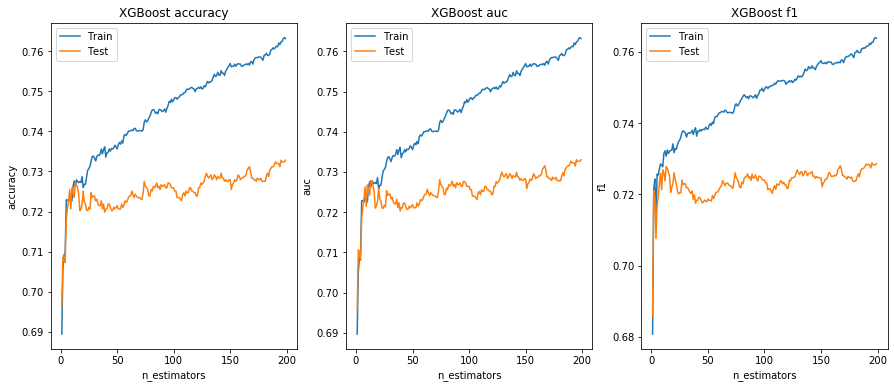

In [72]:
nb_estim = get_nb_estimators_XGB(XGBClassifier,
                                 gsearch_XG_wtgd,
                                 range(1, 200),
                                 test_x_wtgd,
                                 test_y,
                                 train_x_wtgd,
                                 train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(1, 200)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('XGBoost accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('XGBoost auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('XGBoost f1')
plt.show()

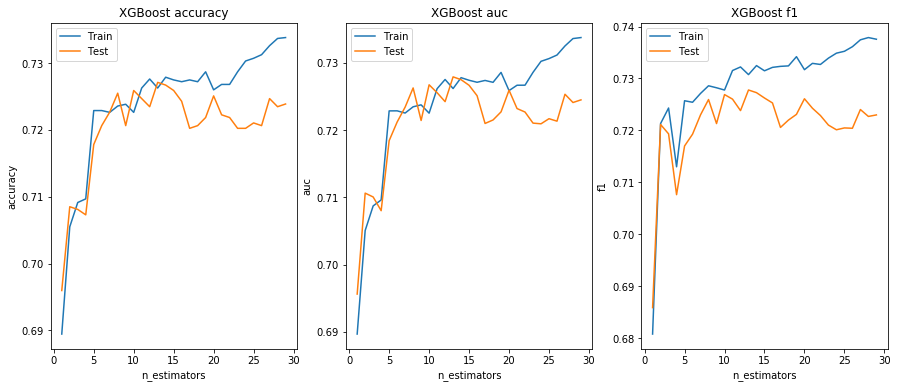

In [73]:
nb_estim = get_nb_estimators_XGB(XGBClassifier,
                                 gsearch_XG_wtgd,
                                 range(1, 30),
                                 test_x_wtgd,
                                 test_y,
                                 train_x_wtgd,
                                 train_y)

nb_iterations = len(nb_estim['train']['auc'])
x_axis = range(1, 30)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(x_axis, nb_estim['train']['accuracy'], label='Train')
ax[0].plot(x_axis, nb_estim['test']['accuracy'], label='Test')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('XGBoost accuracy')
ax[1].plot(x_axis, nb_estim['train']['auc'], label='Train')
ax[1].plot(x_axis, nb_estim['test']['auc'], label='Test')
ax[1].legend()
ax[1].set_ylabel('auc')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('XGBoost auc')
ax[2].plot(x_axis, nb_estim['train']['f1'], label='Train')
ax[2].plot(x_axis, nb_estim['test']['f1'], label='Test')
ax[2].legend()
ax[2].set_ylabel('f1')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('XGBoost f1')
plt.show()

In [74]:
model_XGB_tun_wtgd = XGBClassifier(max_depth = gsearch_XG_wtgd.best_params_['max_depth'],
                                   subsample = gsearch_XG_wtgd.best_params_['subsample'],
                                   colsample_bytree = gsearch_XG_wtgd.best_params_['colsample_bytree'],
                                   learning_rate = 0.05,
                                   n_estimators = 14)


model_XGB_tun_wtgd.fit(train_x_wtgd, train_y.values.ravel())

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=14, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)

##### Le modèle sur-apprend à partir de 20 arbres environ. Nous gardons un nombre d'arbres de 14 car les métriques se confondent pour notre train et notre test en plus d'être la valeur maximale pour chaque métrique sur nos données de test.

### Variables :

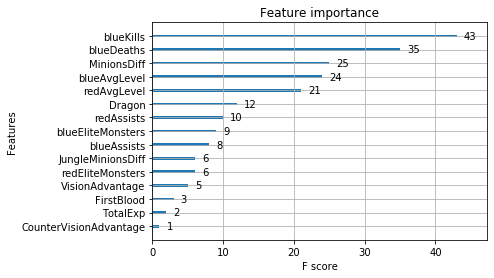

In [75]:
from xgboost import plot_importance

plot_importance(model_XGB_tun_wtgd)
plt.show()

##### Contrairement au RandomForest, ici les variables avec la plus forte importance sont "blueKills" et "blueDeaths" devant "blueAvgLevel" et "redAvgLevel". La variable "MinionsDiff" est égallement bien plus importante. On se souvient que le XGBoost utilisait principalement "GoldDiff" précédement, on sait que les 3 premières variables séléctionné ici sont celle qui sont les plus corrélées à la "GoldDiff". Le modèle a donc remplacer la GoldDiff par ces 3 indicateurs.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


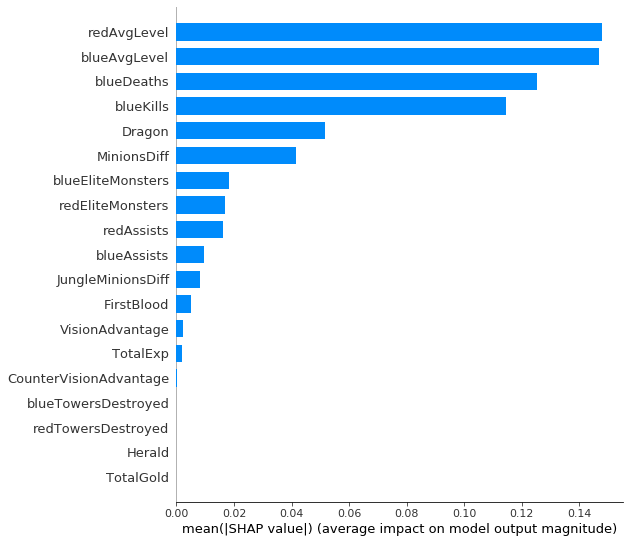

In [76]:
import shap

explainer = shap.TreeExplainer(model_XGB_tun_wtgd)

shap_values = explainer.shap_values(test_x_wtgd)

shap.summary_plot(shap_values, test_x_wtgd, plot_type="bar")

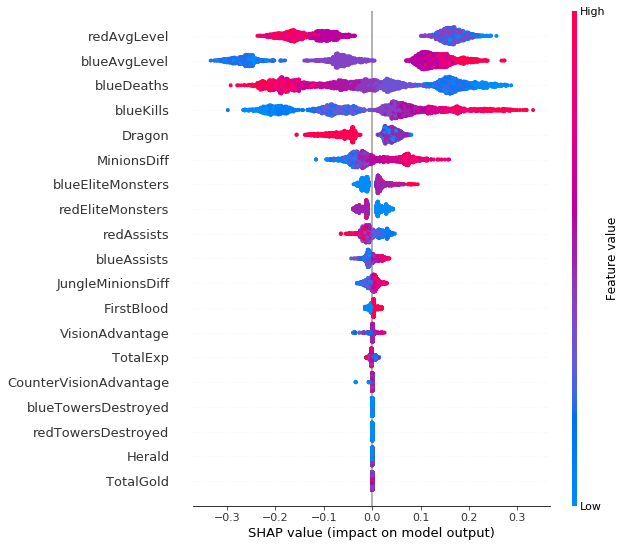

In [77]:
shap.summary_plot(shap_values, test_x_wtgd)

##### On remarque néanmoins que les variables "blueAvgLevel" et "redAvgLevel" sont celles qui influence le plus fortement la probabilité de gagner la partie. Pourtant ce sont pas les variables les plus choisis dans les arbres du modèle. Cela peut être du à un plus forte entropie dans les split sur "blueKills" et "blueDeaths".

# Cross-validation :

In [78]:
df_eval = eval_model(list_model = [model_RF_tun_wtgd, model_XGB_tun_wtgd, model_logreg_wtdg],
          list_metrics = ['accuracy', 'precision', 'recall', 'roc_auc'])

df_eval

,Metrics,Model,Min_Value,Max_Value
0,accuracy,RandomForestClassifier,0.720130,0.726721
1,accuracy,XGBClassifier,0.725911,0.730364
2,accuracy,LogisticRegression,0.724696,0.733198
3,precision,RandomForestClassifier,0.709408,0.743111
4,precision,XGBClassifier,0.723370,0.737245
5,precision,LogisticRegression,0.724980,0.735415
6,recall,RandomForestClassifier,0.691809,0.740470
7,recall,XGBClassifier,0.703163,0.738636
8,recall,LogisticRegression,0.722628,0.736201
9,roc_auc,RandomForestClassifier,0.789339,0.805330


##### Le RandomForest possède de gros écarts sur la précision et le recall, de plus c'est le modèle possedant les plus faibles valeur pour les métriques.
##### Le XGBoost possèdent pour ces données de meilleurs résultats que la régression logistique. Le modèle met néanmoins toujours plus de temps à tourner que la régression. Un arbitrage serait donc à faire si l'on voulait mettre en production un modèle.

##### Pour conclure on remarque que pour les modèles sans nos deux variables on obtient des métriques semblables que pour notre ancien jeu de données. On peut conclure qu'il y'avait redondance d'informations dans nos variables. Nous pouvons imaginer qu'en supprimant plus de variables nous pourrions avoir des modèles plus performant ou déduire des corrélations entre variables.